In [1]:
import os
from os.path import join
import nltk
import string
import pandas as pd
# import pymorphy2
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import pairwise_distances
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from utilits import calculate_metrics, generate_embeddings_lgbm
from sklearn.utils.class_weight import compute_class_weight
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
# from pymystem3 import Mystem
import re
import pickle
from scipy.stats.mstats import gmean
import plotly.graph_objects as go
from sklearn.metrics import classification_report
import matplotlib.image as mpimg
# from gensim.models.fasttext import FastText
# from nltk.tokenize.destructive import NLTKWordTokenizer
# tokenizer = NLTKWordTokenizer()
tqdm.pandas()

In [3]:
!jupyter nbextension disable --py widgetsnbextension
!jupyter nbextension enable --py widgetsnbextension

Disabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [6]:
def tokenize_text(s: str):
    """
    Токенизация строки - разбивка на токены, приведение к нижнему регистру и исключение стоп-слов
    """

#     tokenized_name = tokenizer.tokenize(s)
#     tokenized_name = make_normal_form(tokenized_name)
    tokenized_name = nltk.word_tokenize(s)
#     stopwords = nltk.corpus.stopwords.words('russian')
#     morph = pymorphy2.MorphAnalyzer()
    tokens = [i.lower() for i in tokenized_name if (i.translate(str.maketrans({'“': '"', 
                                                                               '”': '"',
                                                                               '«': '"',
                                                                               '»': '"',
                                                                               '`': '"',
                                                                               "'": '"'})) not in string.punctuation or i.strip() == '*') 
              and (not i.split('г')[0].isnumeric()) #and (i not in stopwords)
              and (not i.split('мл')[0].isnumeric()) and (not i.split('кг')[0].isnumeric())
              and (not i.split('л')[0].isnumeric()) and (not i.split('г')[0].isnumeric())
              and (not i.split('шт')[0].isnumeric()) and (not i.split('см')[0].isnumeric())
              and not i.translate(str.maketrans({'.': '', 
                                                 ',': '',
                                                 '-': '',
                                                 '~': '',
                                                 '/': '',
                                                 '№': '',
                                                 'г': '',
                                                 'к': '',
                                                 'м': '',
                                                 'л': ''})).isnumeric()
              and i not in ['кг', 'г', 'мл', 'л', 'шт', 'см', '``', "''", '*']]
#               and (len(set(['a','b','c','d','e','f','g','h','i','j',
#                             'k','l','m','n','o','p','q','r','s','t',
#                             'u','v','w','x','y','z']) & set(list(i.lower()))) == 0)
#               and (re.search('\d+', i) is None)]
              
    return tokens

def make_normal_form(tokens):
    """
    Приведение токенов к нормальной форме
    """
    morph = pymorphy2.MorphAnalyzer()
    normalized = []
    for word in tokens:
        parsed_token = morph.parse(word)
        normal_form = parsed_token[0].normal_form
        normalized.append(normal_form)
    return normalized

def decode_review(text):
    """
    Декодирование названий товаров из числового представления в словесный
    """
    return ' '.join([reverse_vocab.get(i, '?') for i in text])

def encode_review(text):
    """
    Кодирование названий товаров из словесного представления в числовой
    """
    return [vocab.get(word, vocab['<Unknown>']) for word in text]

def lemmatize(tokens):
    """
    Лемматизация слов в названии товаров
    """
    lemma = list()
    myst = Mystem()
    for word in tokens:
        lemma.append(myst.lemmatize(word)[0])
    return lemma

def matching(name):
    """
    Сопоставление названий категорий товаров по Росстату с его id по Росстату
    """
    try:
        return rosstat[rosstat['rosstat_name'] == name]['rosstat_id'].values[0]
    except:
        return '-'

def plot_multiple_ts(*args, **kwargs):
    """
    Отрисовка графиков ИПЦ Росстата и рассчитанного для визуального сопоставления
    """
    fig = go.Figure(data=[go.Scatter(x=list(ts.index),
                                     y=ts.values,
                                     name=str(ts.name[:45]), 
                                     mode='lines+markers', 
                                     showlegend=True) for ts in args])
    fig.update_layout(**kwargs)
    return fig

def price_normalizing(name):
    reg_expr = r'[0-9]+ л|[0-9]+ мл|[0-9]+ г|[0-9]+ кг|[0-9]+л|[0-9]+мл|[0-9]+г|[0-9]+кг|[0-9]+шт|[0-9]+ шт'
    compiled = re.compile(reg_expr)
    return ','.join(compiled.findall(name))

def replace_space(s):
    return s.replace('\xa0', ' ')

def split_number(mes):
    reg_expr = r'[0-9]+'
    compiled = re.compile(reg_expr)
    
    return ','.join(compiled.findall(mes))

def split_measure(mes):
    reg_expr = r'[а-я]+'
    compiled = re.compile(reg_expr)
    
    return ','.join(compiled.findall(mes))

def _get_products_py(p_yes, p_no, products=df1):
    '''
    p_yes: list of substrings (regex=True) to search for anywhere in the string. If any is found, string is valid. 
    p_no: list of substrings (regex=True) to search for anywhere in the string. If any is found, string is invalid.
    '''
    
    list_out = [s for s in products if (True
                # matches pattern p_yes
                & (True if p_yes==True else any(re.search(patt, s.lower()) is not None for patt in p_yes))  
                # does not match pattern p_no
                & (True if p_no==True else (~any(re.search(patt, s.lower()) is not None for patt in p_no)))    
                )
    ]

    return list_out

def get_products(p_yes, p_no):
    c1 = any([True if a in s else False for a in ['?=','?!','?<'] for s in p_yes])
    c2 = any([True if a in s else False for a in ['?=','?!','?<'] for s in p_no])
    if (c1 | c2):
        print('Zero-width assertion detected. Using python re engine')
        products_i = _get_products_py(p_yes,p_no)
    else:
        print('No zero-width assertion detected. Using CH re engine')
        # products_i = _get_products_sql(p_yes,p_no)
    return products_i

def padding(tokens, maxlen):
    return tf.keras.preprocessing.sequence.pad_sequences(tokens
                                              , value=vocab['<Pad>'], padding='post', maxlen=maxlen)

## Обучение модели

### Использование fasttext

In [190]:
%%time
ft = FastText.load_fasttext_format('cc.ru.300.bin')

CPU times: user 3min 38s, sys: 4min, total: 7min 38s
Wall time: 22min 8s


In [207]:
%%time
emb_size = 300
embedding_matrix = np.zeros((len(vocab.keys()), emb_size))
for word, i in tqdm(vocab.items()):
    if word in ft.wv:
        embedding_matrix[i] = ft.wv[word] 
    else:    
        embedding_matrix[i] = np.random.rand(emb_size)
        print(word)

100%|████████████████████████████████████| 19530/19530 [00:24<00:00, 801.44it/s]

CPU times: user 2.21 s, sys: 6.48 s, total: 8.7 s
Wall time: 24.4 s


In [208]:
embedding_matrix.shape

(19530, 300)

In [209]:
len(vocab)

19530

In [194]:
x_train.max()

13461

In [294]:
# загрузить в колаб: vocab, embedding_matrix, df1, label_to_names

f = open('embedding_matrix.bin', 'rb')
embedding_matrix = pickle.load(f)

# f = open('/content/drive/MyDrive/vocab.bin', 'rb')
# vocab = pickle.load(f)

# f = open('/content/drive/MyDrive/labels_to_names.bin', 'rb')
# labels_to_names = pickle.load(f)

In [36]:
embedding_matrix.shape

(22707, 300)

In [42]:
train_df.to_csv('train_df.csv', index=False)

In [43]:
x_train

array([[16944,  7563, 18858, ...,     0,     0,     0],
       [13978, 19558,  5327, ...,     0,     0,     0],
       [ 1255,  2283,  7854, ...,     0,     0,     0],
       ...,
       [15153, 14413,  5327, ...,     0,     0,     0],
       [20786, 14908, 17123, ...,     0,     0,     0],
       [ 2528, 10361, 16893, ...,     0,     0,     0]], dtype=int32)

In [316]:
def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]

A = [0,1,2,3,4,5,6,7,8,9]

# print split_list(A, wanted_parts=1)
split = split_list(embedding_matrix, wanted_parts=3)
for i in range(len(split)):
    f = open(f'embedding_matrix_{i}.bin', 'wb')
    pickle.dump(split[i], f)
    f.close()
# print split_list(A, wanted_parts=8)

In [210]:
f = open('embedding_matrix_lem.bin', 'wb')
pickle.dump(embedding_matrix, f)
f.close()

In [129]:
emb_file.shape

(20245, 300)

In [189]:
len(vocab)

20245

In [188]:
f = open('embedding_matrix.bin', 'rb')
emb_file = pickle.load(f)
emb_file

array([[-0.01767895,  0.06324721,  0.03565359, ...,  0.0190802 ,
        -0.07804494,  0.02329645],
       [-0.01073731,  0.00607343, -0.01083034, ...,  0.0325923 ,
         0.02859577, -0.04606003],
       [-0.04648508,  0.046736  ,  0.04360295, ...,  0.01171511,
        -0.01983516, -0.03224463],
       ...,
       [ 0.00893001,  0.01057879, -0.02241801, ...,  0.02687727,
         0.02050977, -0.03592685],
       [-0.03582219,  0.00649704,  0.02455403, ...,  0.02072163,
         0.05679995,  0.01306883],
       [ 0.19943179, -0.20755515, -0.15983942, ...,  0.15119761,
        -0.10205728, -0.28850526]])

In [595]:
def get_average_word2vec(tokens_list, vector, generate_missing=True, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector.wv[word] if word in vector.wv else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector.wv[word] if word in vector.wv else np.zeros(k) for word in tokens_list]
#     length = len(vectorized)
#     summed = np.sum(vectorized, axis=0)
#     averaged = np.divide(summed, length)
    return vectorized

# def get_word2vec_embeddings(ft, df, generate_missing=False):
#     embeddings = df['tokens'].apply(lambda x: get_average_word2vec(x, ft, 
#                                                                     generate_missing=generate_missing))
#     return list(embeddings)

def get_word2vec_embeddings(ft, df, generate_missing=False):
    embeddings = map(lambda x: get_average_word2vec(x, ft, 
                                                                    generate_missing=generate_missing), df)
    return list(embeddings)

In [596]:
def padding2(tokens, maxlen):
    return tf.keras.preprocessing.sequence.pad_sequences(tokens
                                              , value='<Pad>', padding='post', maxlen=8, dtype=object)
max_seq_len = train_df.assign(num=train_df.encoded_tokens.apply(len)).num.max()
x_padding = padding2(train_df.tokens, max_seq_len)
# train_df

In [597]:
# x_train, x_test, y_train, y_test = train_test_split(train_df.iloc[:, :-1], train_df['label'], test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_padding, train_df['label'], test_size=0.2)

In [ ]:
train_embeddings = get_word2vec_embeddings(ft, x_train)
test_embeddings = get_word2vec_embeddings(ft, x_test)

In [ ]:
train_embeddings = np.array(train_embeddings).reshape(-1, 31, 300)
test_embeddings = np.array(test_embeddings).reshape(-1, 31, 300)

In [ ]:
y_train = y_train.apply(int)
y_test = y_test.apply(int)

### Обучение

In [25]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.04)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

path = 'handle_saved_model_lem.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path, monitor='val_loss',
                                                verbose=1, save_best_only=True)

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.99232, saving model to handle_saved_model_lem.h5
485/485 - 15s - loss: 10.4119 - acc: 0.2096 - val_loss: 1.9923 - val_acc: 0.5114 - lr: 0.0050 - 15s/epoch - 31ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.99232 to 1.21005, saving model to handle_saved_model_lem.h5
485/485 - 11s - loss: 4.0940 - acc: 0.5104 - val_loss: 1.2100 - val_acc: 0.6907 - lr: 0.0050 - 11s/epoch - 22ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.21005 to 0.90895, saving model to handle_saved_model_lem.h5
485/485 - 11s - loss: 2.5488 - acc: 0.6496 - val_loss: 0.9090 - val_acc: 0.7646 - lr: 0.0050 - 11s/epoch - 22ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.90895 to 0.79522, saving model to handle_saved_model_lem.h5
485/485 - 11s - loss: 1.8779 - acc: 0.7168 - val_loss: 0.7952 - val_acc: 0.7904 - lr: 0.0050 - 11s/epoch - 22ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.79522 to 0.70387, saving model to handle_saved_model_lem.h5
485/4

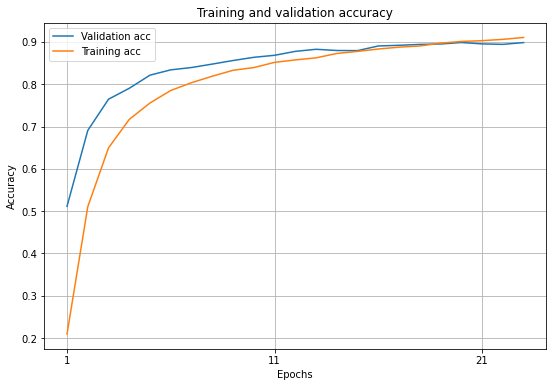

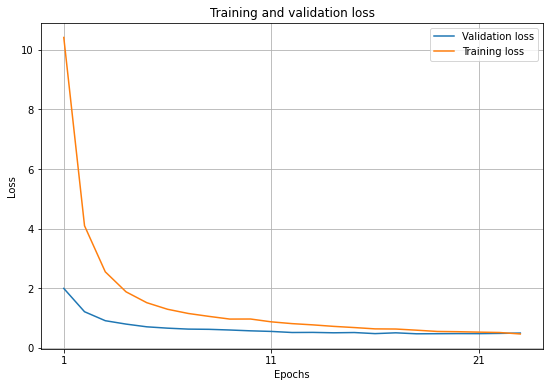

Accuracy score: 0.9022180931366857
F1 score: 0.9052844746999607

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       433
           1       0.90      0.93      0.91       127
           2       0.98      0.99      0.98        89
           3       0.97      0.85      0.91       370
           4       0.98      0.88      0.93        50
           5       0.81      0.71      0.76        24
           6       0.90      0.89      0.89       115
           7       0.98      0.94      0.96       258
           8       0.91      0.80      0.85        87
           9       0.76      0.70      0.73       724
          10       1.00      0.69      0.82        55
          11       0.96      0.97      0.97       119
          12       0.94      0.95      0.95       393
          13       0.95      0.91      0.93       691
          14       0.94      0.95      0.95       282
          15       1.00      0.99      0.99        98
          16    

In [26]:
%%time
emb_size = 32
# emb_size = train_embeddings.shape[2]
vocab_size = len(vocab)
n_outs = y.nunique()

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_df.label),
                                     y=train_df.label)
class_weights = dict(enumerate(class_weights))

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, emb_size),
    tf.keras.layers.LSTM(emb_size, return_sequences=False,
                         dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_outs, activation='softmax')
]
)

# model = tf.keras.models.load_model('handle_saved_model_lem.h5')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='sparse_categorical_crossentropy', metrics=['acc'])

batch_size = 128
epochs = 50

history = model.fit(x_train, y_train, validation_split=0.1,
                    epochs=epochs, batch_size=batch_size,
                    verbose=2, class_weight=class_weights,
                    callbacks=[lr_callback, cp_callback, es_callback])

y_pred = model.predict(x_test).argmax(axis=1)

plt.figure(figsize=(9, 6))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.xticks(range(1, len(history.history['val_acc']) + 1, 10))
plt.ylabel('Accuracy')
plt.grid()
plt.plot(range(1, len(history.history['val_acc']) + 1),
         history.history['val_acc'], label='Validation acc')
plt.plot(range(1, len(history.history['val_acc']) + 1),
         history.history['acc'], label='Training acc')
plt.legend()
plt.show()

plt.figure(figsize=(9, 6))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.xticks(range(1, len(history.history['val_acc']) + 1, 10))
plt.ylabel('Loss')
plt.grid()
plt.plot(range(1, len(history.history['val_acc']) + 1),
         history.history['val_loss'], label='Validation loss')
plt.plot(range(1, len(history.history['val_acc']) + 1),
         history.history['loss'], label='Training loss')
plt.legend()
plt.show()

calculate_metrics(y_pred, y_test)

In [141]:
%%time
# emb_size = 32#max_seq_len
emb_size = 300
vocab_size = len(vocab)
n_outs = y.nunique()

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_df.label),
                                     y=train_df.label)
class_weights = dict(enumerate(class_weights))

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=emb_size,
#                               input_length=emb_size,
                              weights=[embedding_matrix],
                              trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(emb_size, return_sequences=True,
                         dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(emb_size, return_sequences=False,
                         dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_outs, activation='softmax')
]
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.007),
              loss='sparse_categorical_crossentropy', metrics=['acc'])

batch_size = 128
epochs = 100

history = model.fit(x_train, y_train, validation_split=0.1,
                    epochs=epochs, batch_size=batch_size,
                    verbose=1, class_weight=class_weights,
                    callbacks=[lr_callback, es_callback])

y_pred = model.predict(x_test).argmax(axis=1)

plt.figure(figsize=(9, 6))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.xticks(range(1, len(history.history['val_acc']) + 1, 10))
plt.ylabel('Accuracy')
plt.grid()
plt.plot(range(1, len(history.history['val_acc']) + 1),
         history.history['val_acc'], label='Validation acc')
plt.plot(range(1, len(history.history['val_acc']) + 1),
         history.history['acc'], label='Training acc')
plt.legend()
plt.show()

plt.figure(figsize=(9, 6))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.xticks(range(1, len(history.history['val_acc']) + 1, 10))
plt.ylabel('Loss')
plt.grid()
plt.plot(range(1, len(history.history['val_acc']) + 1),
         history.history['val_loss'], label='Validation loss')
plt.plot(range(1, len(history.history['val_acc']) + 1),
         history.history['loss'], label='Training loss')
plt.legend()
plt.show()

calculate_metrics(y_pred, y_test)

Epoch 1/100
485/485 [==============================] - 330s 657ms/step - loss: 6.6320 - acc: 0.3176 - val_loss: 1.7033 - val_acc: 0.5552 - lr: 0.0070
Epoch 2/100
485/485 [==============================] - 314s 647ms/step - loss: 2.9509 - acc: 0.5515 - val_loss: 1.2547 - val_acc: 0.6521 - lr: 0.0070
Epoch 3/100
485/485 [==============================] - 311s 641ms/step - loss: 2.1564 - acc: 0.6374 - val_loss: 1.0095 - val_acc: 0.7078 - lr: 0.0070
Epoch 4/100
485/485 [==============================] - 314s 648ms/step - loss: 1.7528 - acc: 0.6860 - val_loss: 0.8777 - val_acc: 0.7541 - lr: 0.0070
Epoch 5/100
485/485 [==============================] - 315s 650ms/step - loss: 1.5175 - acc: 0.7201 - val_loss: 0.8222 - val_acc: 0.7650 - lr: 0.0070
Epoch 6/100
485/485 [==============================] - 307s 634ms/step - loss: 1.4148 - acc: 0.7409 - val_loss: 0.7363 - val_acc: 0.7950 - lr: 0.0070
Epoch 7/100
485/485 [==============================] - 306s 630ms/step - loss: 1.2264 - acc: 0.7637 

KeyboardInterrupt: 

In [334]:
report_df = pd.DataFrame(classification_report(y_pred,
                                   y_test,
                                   target_names=list(labels.keys()),
                                   output_dict=True)).transpose().reset_index()

# report_df.drop(labels=[123, 124, 125], axis=0, inplace=True)
report_df = report_df.assign(rosstat_id=report_df['index'].progress_apply(matching))
report_df['support'] = report_df['support'].apply(int)
report_df.rename(columns={'index': 'rosstat_name'}, inplace=True)

# report_df.to_excel('report_df.xlsx', index=False)
report_df

ValueError: Found input variables with inconsistent numbers of samples: [920366, 17222]

In [174]:
emb_size = 32#max_seq_len
vocab_size = len(vocab)
n_outs = y_train.nunique()
batch_size = 64
epochs = 50

for company_id in train_df.company_id.unique():
    max_seq_len = train_df.assign(num=train_df.encoded_tokens.apply(len)).num.max()

    x_train = padding(train_df[train_df['company_id'] != company_id].encoded_tokens)
    y_train = train_df[train_df['company_id'] != company_id].label.apply(int)
    
    x_test = padding(train_df[train_df['company_id'] == company_id].encoded_tokens)
    y_test = train_df[train_df['company_id'] == company_id].label.apply(int)
    
    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_size),
        tf.keras.layers.LSTM(emb_size, return_sequences=False,
                             dropout=0.5, recurrent_dropout=0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(n_outs, activation='softmax')
    ]
    )

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.006),
                  loss='sparse_categorical_crossentropy', metrics=['acc'])

    history = model.fit(x_train, y_train, validation_split=0.1, epochs=epochs,
                    batch_size=batch_size, verbose=1, class_weight=class_weights,
                    callbacks=[lr_callback, es_callback])

    y_pred = model.predict(x_test).argmax(axis=1)
    y_pred_names = [labels_to_names[l] for l in y_pred]
    calculate_metrics(y_pred, y_test)

Epoch 1/50
1094/1094 [==============================] - 28s 21ms/step - loss: 3.0131 - acc: 0.3654 - val_loss: 1.0843 - val_acc: 0.7059 - lr: 0.0060
Epoch 2/50
1094/1094 [==============================] - 23s 21ms/step - loss: 1.4927 - acc: 0.6389 - val_loss: 0.6640 - val_acc: 0.8334 - lr: 0.0060
Epoch 3/50
1094/1094 [==============================] - 23s 21ms/step - loss: 0.9985 - acc: 0.7263 - val_loss: 0.5888 - val_acc: 0.8598 - lr: 0.0060
Epoch 4/50
1094/1094 [==============================] - 23s 21ms/step - loss: 0.7723 - acc: 0.7663 - val_loss: 0.5885 - val_acc: 0.8525 - lr: 0.0060
Epoch 5/50
1094/1094 [==============================] - 23s 21ms/step - loss: 0.6460 - acc: 0.7918 - val_loss: 0.5078 - val_acc: 0.8823 - lr: 0.0060
Epoch 6/50
1094/1094 [==============================] - 23s 21ms/step - loss: 0.5584 - acc: 0.8083 - val_loss: 0.5204 - val_acc: 0.8769 - lr: 0.0060
Epoch 7/50
1094/1094 [==============================] - 23s 21ms/step - loss: 0.5334 - acc: 0.8154 - val_l

Epoch 1/50
954/954 [==============================] - 24s 22ms/step - loss: 3.1367 - acc: 0.3230 - val_loss: 1.0952 - val_acc: 0.6819 - lr: 0.0060
Epoch 2/50
954/954 [==============================] - 21s 22ms/step - loss: 1.5647 - acc: 0.6189 - val_loss: 0.7050 - val_acc: 0.8063 - lr: 0.0060
Epoch 3/50
954/954 [==============================] - 23s 24ms/step - loss: 1.0434 - acc: 0.7155 - val_loss: 0.6131 - val_acc: 0.8451 - lr: 0.0060
Epoch 4/50
954/954 [==============================] - 20s 21ms/step - loss: 0.8277 - acc: 0.7586 - val_loss: 0.5383 - val_acc: 0.8739 - lr: 0.0060
Epoch 5/50
954/954 [==============================] - 20s 21ms/step - loss: 0.6549 - acc: 0.7934 - val_loss: 0.5191 - val_acc: 0.8835 - lr: 0.0060
Epoch 6/50
954/954 [==============================] - 20s 21ms/step - loss: 0.5562 - acc: 0.8113 - val_loss: 0.4990 - val_acc: 0.8885 - lr: 0.0060
Epoch 7/50
954/954 [==============================] - 22s 23ms/step - loss: 0.4964 - acc: 0.8235 - val_loss: 0.5040 - 

Epoch 1/50
1023/1023 [==============================] - 27s 23ms/step - loss: 3.2783 - acc: 0.3006 - val_loss: 1.2557 - val_acc: 0.6468 - lr: 0.0060
Epoch 2/50
1023/1023 [==============================] - 21s 20ms/step - loss: 1.7689 - acc: 0.5837 - val_loss: 0.8300 - val_acc: 0.7839 - lr: 0.0060
Epoch 3/50
1023/1023 [==============================] - 21s 21ms/step - loss: 1.2217 - acc: 0.6931 - val_loss: 0.6992 - val_acc: 0.8043 - lr: 0.0060
Epoch 4/50
 154/1023 [===>..........................] - ETA: 19s - loss: 0.9187 - acc: 0.7337

KeyboardInterrupt: 

In [27]:
model.save('handle_saved_model.h5')

In [617]:
count = 0
for i in range(x_test.shape[0]):
    if y_pred[i] != y_test.values[i]:
        count += 1
        print(decode_review(x_test[i]),
              train_df[train_df['label'] == str(y_pred[i])]['query_goods'].values[0])
print(count)

перец кинто консервированный <Pad> <Pad> <Pad> <Pad> <Pad> Перец черный (горошек), кг
бзмж сырок глазир простоквашино сгущ молоко <Pad> <Pad> Сырки творожные, глазированные шоколадом, кг
морковь цветная <Pad> <Pad> <Pad> <Pad> <Pad> <Pad> Консервы овощные для детского питания, кг
рагу гороховое alnatura стерилизованное <Pad> <Pad> <Pad> <Pad> Крупа гречневая-ядрица, кг
апельсин с кусочками цедры и шоколадным бисквитом брауни Соки фруктовые, л
шампиньоны быстрозамороженные глобу ... <Pad> <Pad> <Pad> <Pad> Консервы рыбные натуральные и с добавлением масла, кг
окунь морской филе охлажденный <Pad> <Pad> <Pad> <Pad> Свинина (кроме бескостного мяса), кг
хлопья nordic два вида гречки и семена конопли Шоколад, кг
соломка картофельная бульба sticks кетчуп <Pad> <Pad> <Pad> Кетчуп, кг
зефира лафрель мини bubblegum <Pad> <Pad> <Pad> <Pad> Консервы овощные для детского питания, кг
палочки корицы sonnentor цейлонской <Pad> <Pad> <Pad> <Pad> Мясо индейки, кг
маргарин добавкин воронежский <Pad> <Pad

свёкла тульская нива первый класс <Pad> <Pad> <Pad> Консервы рыбные натуральные и с добавлением масла, кг
креветка сухогруз королевская сушеная <Pad> <Pad> <Pad> <Pad> Сельдь соленая, кг
готовый завтрак nesquik подушечки шоколадные <Pad> <Pad> <Pad> Майонез, кг
фруктовые пастилки disney frozen <Pad> <Pad> <Pad> <Pad> Вермишель, кг
голень куриная спб <Pad> <Pad> <Pad> <Pad> <Pad> Куры охлажденные и мороженные, кг
пюре агуша цыпленок/говядина ст/б <Pad> <Pad> <Pad> <Pad> Консервы овощные для детского питания, кг
мясо мидий афанасий холодного копчения <Pad> <Pad> <Pad> Рыба соленая, маринованная, копченая, кг
макаронные изделия makfa вермишель паутинка <Pad> <Pad> <Pad> Макаронные изделия из пшеничной муки высшего сорта, кг
из яблок черноплодной рябины малины клюквы и черники Йогурт, кг
ko co с портвейном и мускатным ор ... Йогурт, кг
манка элитная агро-альянс экстра <Pad> <Pad> <Pad> <Pad> Пшено, кг
ватрушка сдобная <Pad> <Pad> <Pad> <Pad> <Pad> <Pad> Огурцы свежие, кг
смесь компотная за

## Инференс модели

### Загрузка модели

In [29]:
my_model = tf.keras.models.load_model('handle_saved_model.h5')
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          789376    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 256)               8448      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 160)               41120     
                                                                 
Total params: 847,264
Trainable params: 847,264
Non-trainable params: 0
_________________________________________________________________


In [11]:
f = open('vocab.bin', 'rb')
vocab = pickle.load(f)

f = open('labels_to_names.bin', 'rb')
labels_to_names = pickle.load(f)

### Предобработка входных данных

In [179]:
# df_inference = df_vkusvill_moscow.copy()
vkusvill_perek = pd.read_csv('vkusvill_perek.csv')
df_inference = vkusvill_perek.copy()
# df_inference = df[df['units'] == 'Москва и область']

In [935]:
df_inference

,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units
223,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,Orbit Жевательная резинка Бабблминт белоснежны...,78.7,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область
232,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка ORBIT Bags клубника-банан,...",83.89,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область
233,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка ORBIT ягодный микс, 13,6г",34.9,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область
236,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка Orbit Клубника/Банан, 13,6г",34.9,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область
247,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,Резинка жевательная Orbit White освежающая мят...,34.9,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область
...,...,...,...,...,...,...,...,...,...,...
69357212,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный Бабаевский с фундуком 100г,"131,49","78,89 ₽",/msk/shokolad-temnyi-babaevskii-s-fundukom-100g,Москва и область
69357213,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный Вдохновение классический 100г К...,"132,99","79,79 ₽",/webapp/wcs/stores/servlet/ProductDisplay?urlR...,Москва и область
69357214,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный с помадно-сливочной начинкой Ба...,"50,99","30,59 ₽",/webapp/wcs/stores/servlet/ProductDisplay?urlR...,Москва и область
69357215,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад тёмный Red Классический 26г,"54,99","32,99 ₽",/msk/shokolad-temnyi-red-klassicheskii-26g,Москва и область


In [99]:
# df_inference['product_name'] = df_inference.product_name.apply(str)
df_inference.dropna(subset=['product_name'], axis=0, inplace=True)
df_inference = df_inference.assign(tokens=df_inference.product_name.progress_apply(tokenize_text))

df_inference = df_inference.assign(encoded_tokens=df_inference.tokens.progress_apply(encode_review))

100%|███████████████████████████████| 920347/920347 [00:03<00:00, 289630.16it/s]


In [100]:
# # max_seq_len = df_inference.assign(num=df_inference.encoded_tokens.apply(len)).num.max()
# train_df['doc_len'] = train_df['product_name'].apply(lambda words: len(words.split(" ")))
# max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

X = padding(df_inference.encoded_tokens, maxlen=9)

### Предсказание

In [101]:
y_pred = my_model.predict(X)
y_pred_names = [labels_to_names[l] for l in y_pred.argmax(axis=1)]

y_pred_conf = y_pred.max(axis=1)
# y_test_names = [labels_to_names[l] for l in y_test]
# calculate_metrics(y_pred_names, y_test_names)

28761/28761 [==============================] - 87s 3ms/step


In [102]:
df_inference.loc[:, 'pred_category'] = y_pred_names
df_inference.loc[:, 'pred_conf'] = y_pred_conf
df_inference

,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units,tokens,encoded_tokens,pred_category,pred_conf
0,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло бутербродное 61,5%",183.0,NaN,/goods/maslo-buterbrodnoe-61-5-16229.html,Москва и область,"[масло, бутербродное]","[1630, 18126]",Масло(прочее),0.996519
1,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло из козьего молока 82,5%",230.0,NaN,/goods/maslo-iz-kozego-moloka-82-5-12199.html,Москва и область,"[масло, из, козьего, молока]","[1630, 19961, 655, 12785]",Масло(прочее),0.990064
2,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло из козьего молока, вес",1390.0,NaN,/goods/maslo-iz-kozego-moloka-ves-21115.html,Москва и область,"[масло, из, козьего, молока, вес]","[1630, 19961, 655, 12785, 1711]",Масло(прочее),0.992362
3,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло крестьянское 72,5%, 200 г",210.0,NaN,/goods/maslo-krestyanskoe-72-5-200-g-23071.html,Москва и область,"[масло, крестьянское]","[1630, 23404]","Масло сливочное, кг",0.987406
4,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 72,5%_РП",190.0,NaN,/goods/maslo-slivochnoe-72-5-rp-63699.html,Москва и область,"[масло, сливочное, _рп]","[1630, 22243, 13727]","Масло сливочное, кг",0.984920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920361,8,2022-04-29 23:44:09,1591,1591,elektronnye-igry-i-igrushki,Трактор ABtoys с ковшом на проводном дистанцио...,445.0,NaN,/product/abtoys-trakt-s-kovsh-na-du-artc-00375...,Москва и область,"[трактор, abtoys, с, ковшом, на, проводном, ди...","[11105, 21538, 18248, 19705, 15364, 1, 1, 1]",Прочее,0.998730
920362,8,2022-04-29 23:51:09,3967,3967,hinkali,Хинкали ВкусВилл с говядиной и свининой 480г,450.0,NaN,/product/vkusvill-vv-hinkali-s-gov-i-sv-y-480g...,Москва и область,"[хинкали, вкусвилл, с, говядиной, и, свининой]","[11347, 2959, 18248, 546, 20873, 11643]","Пельмени, манты, равиоли, кг",0.999070
920363,8,2022-04-29 23:51:09,3967,3967,hinkali,Хинкали Ложкаревъ По-восточному 900г,320.0,NaN,/product/lojkarev-lojkar-hinkali-po-vostochnom...,Москва и область,"[хинкали, ложкаревъ, по-восточному]","[11347, 3611, 9420]","Пельмени, манты, равиоли, кг",0.999974
920364,8,2022-04-29 23:51:09,3967,3967,hinkali,Хинкали Мираторг по-грузински 800г,567.0,NaN,/product/miratorg-mirat-hinkali-po-gruzinski-8...,Москва и область,"[хинкали, мираторг, по-грузински]","[11347, 15608, 22576]","Пельмени, манты, равиоли, кг",0.999592


In [103]:
df_inference = df_inference.merge(right=train_df[['product_name', 'query_goods']], how='left', on='product_name')

In [17]:
rosstat = pd.read_excel('/Users/sergey/Downloads/food_prices/input/Name_id_matching.xlsx')
rosstat

,rosstat_name,rosstat_id,week cpi
0,"Фарш мясной, кг",105,NaN
1,"Пельмени, манты, равиоли, кг",106,NaN
2,"Печень говяжья, кг",107,NaN
3,"Говядина (кроме бескостного мяса), кг",111,1.0
4,"Говядина бескостная, кг",112,NaN
...,...,...,...
119,"Вино игристое отечественное, л",3102,NaN
120,"Пиво, л",3203,NaN
121,"Вода минеральная и питьевая, л",3303,NaN
122,"Напитки газированные, л",3305,NaN


In [104]:
# df_inference.loc[(df_inference['pred_conf'] < 0.8)|\
#                  (~df_inference['pred_category'].isin(rosstat['rosstat_name'].values)),
#                  'pred_category'] = 'Прочее'

df_inference.loc[~df_inference['pred_category'].isin(rosstat['rosstat_name'].values),
                 'pred_category'] = 'Прочее'
df_inference.loc[~df_inference['query_goods'].isin(rosstat['rosstat_name'].values),
                 'query_goods'] = 'Прочее'
df_inference

,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units,tokens,encoded_tokens,pred_category,pred_conf,query_goods
0,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло бутербродное 61,5%",183.0,NaN,/goods/maslo-buterbrodnoe-61-5-16229.html,Москва и область,"[масло, бутербродное]","[1630, 18126]",Прочее,0.996519,Прочее
1,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло из козьего молока 82,5%",230.0,NaN,/goods/maslo-iz-kozego-moloka-82-5-12199.html,Москва и область,"[масло, из, козьего, молока]","[1630, 19961, 655, 12785]",Прочее,0.990064,Прочее
2,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло из козьего молока, вес",1390.0,NaN,/goods/maslo-iz-kozego-moloka-ves-21115.html,Москва и область,"[масло, из, козьего, молока, вес]","[1630, 19961, 655, 12785, 1711]",Прочее,0.992362,Прочее
3,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло крестьянское 72,5%, 200 г",210.0,NaN,/goods/maslo-krestyanskoe-72-5-200-g-23071.html,Москва и область,"[масло, крестьянское]","[1630, 23404]","Масло сливочное, кг",0.987406,"Масло сливочное, кг"
4,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 72,5%_РП",190.0,NaN,/goods/maslo-slivochnoe-72-5-rp-63699.html,Москва и область,"[масло, сливочное, _рп]","[1630, 22243, 13727]","Масло сливочное, кг",0.984920,"Масло сливочное, кг"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920342,8,2022-04-29 23:44:09,1591,1591,elektronnye-igry-i-igrushki,Трактор ABtoys с ковшом на проводном дистанцио...,445.0,NaN,/product/abtoys-trakt-s-kovsh-na-du-artc-00375...,Москва и область,"[трактор, abtoys, с, ковшом, на, проводном, ди...","[11105, 21538, 18248, 19705, 15364, 1, 1, 1]",Прочее,0.998730,Прочее
920343,8,2022-04-29 23:51:09,3967,3967,hinkali,Хинкали ВкусВилл с говядиной и свининой 480г,450.0,NaN,/product/vkusvill-vv-hinkali-s-gov-i-sv-y-480g...,Москва и область,"[хинкали, вкусвилл, с, говядиной, и, свининой]","[11347, 2959, 18248, 546, 20873, 11643]","Пельмени, манты, равиоли, кг",0.999070,"Пельмени, манты, равиоли, кг"
920344,8,2022-04-29 23:51:09,3967,3967,hinkali,Хинкали Ложкаревъ По-восточному 900г,320.0,NaN,/product/lojkarev-lojkar-hinkali-po-vostochnom...,Москва и область,"[хинкали, ложкаревъ, по-восточному]","[11347, 3611, 9420]","Пельмени, манты, равиоли, кг",0.999974,"Пельмени, манты, равиоли, кг"
920345,8,2022-04-29 23:51:09,3967,3967,hinkali,Хинкали Мираторг по-грузински 800г,567.0,NaN,/product/miratorg-mirat-hinkali-po-gruzinski-8...,Москва и область,"[хинкали, мираторг, по-грузински]","[11347, 15608, 22576]","Пельмени, манты, равиоли, кг",0.999592,"Пельмени, манты, равиоли, кг"


In [105]:
df_inference['query_goods'] = df_inference['query_goods'].fillna('Прочее')
df_inference

,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units,tokens,encoded_tokens,pred_category,pred_conf,query_goods
0,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло бутербродное 61,5%",183.0,NaN,/goods/maslo-buterbrodnoe-61-5-16229.html,Москва и область,"[масло, бутербродное]","[1630, 18126]",Прочее,0.996519,Прочее
1,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло из козьего молока 82,5%",230.0,NaN,/goods/maslo-iz-kozego-moloka-82-5-12199.html,Москва и область,"[масло, из, козьего, молока]","[1630, 19961, 655, 12785]",Прочее,0.990064,Прочее
2,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло из козьего молока, вес",1390.0,NaN,/goods/maslo-iz-kozego-moloka-ves-21115.html,Москва и область,"[масло, из, козьего, молока, вес]","[1630, 19961, 655, 12785, 1711]",Прочее,0.992362,Прочее
3,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло крестьянское 72,5%, 200 г",210.0,NaN,/goods/maslo-krestyanskoe-72-5-200-g-23071.html,Москва и область,"[масло, крестьянское]","[1630, 23404]","Масло сливочное, кг",0.987406,"Масло сливочное, кг"
4,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 72,5%_РП",190.0,NaN,/goods/maslo-slivochnoe-72-5-rp-63699.html,Москва и область,"[масло, сливочное, _рп]","[1630, 22243, 13727]","Масло сливочное, кг",0.984920,"Масло сливочное, кг"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920342,8,2022-04-29 23:44:09,1591,1591,elektronnye-igry-i-igrushki,Трактор ABtoys с ковшом на проводном дистанцио...,445.0,NaN,/product/abtoys-trakt-s-kovsh-na-du-artc-00375...,Москва и область,"[трактор, abtoys, с, ковшом, на, проводном, ди...","[11105, 21538, 18248, 19705, 15364, 1, 1, 1]",Прочее,0.998730,Прочее
920343,8,2022-04-29 23:51:09,3967,3967,hinkali,Хинкали ВкусВилл с говядиной и свининой 480г,450.0,NaN,/product/vkusvill-vv-hinkali-s-gov-i-sv-y-480g...,Москва и область,"[хинкали, вкусвилл, с, говядиной, и, свининой]","[11347, 2959, 18248, 546, 20873, 11643]","Пельмени, манты, равиоли, кг",0.999070,"Пельмени, манты, равиоли, кг"
920344,8,2022-04-29 23:51:09,3967,3967,hinkali,Хинкали Ложкаревъ По-восточному 900г,320.0,NaN,/product/lojkarev-lojkar-hinkali-po-vostochnom...,Москва и область,"[хинкали, ложкаревъ, по-восточному]","[11347, 3611, 9420]","Пельмени, манты, равиоли, кг",0.999974,"Пельмени, манты, равиоли, кг"
920345,8,2022-04-29 23:51:09,3967,3967,hinkali,Хинкали Мираторг по-грузински 800г,567.0,NaN,/product/miratorg-mirat-hinkali-po-gruzinski-8...,Москва и область,"[хинкали, мираторг, по-грузински]","[11347, 15608, 22576]","Пельмени, манты, равиоли, кг",0.999592,"Пельмени, манты, равиоли, кг"


In [507]:
# df_inference[['download_dt', 'product_name', 'pred_category']] \
# .assign(rosstat_id=df_inference.pred_category.progress_apply(matching)) \
# .to_excel('Инференс_ВкусВилл_Москва.xlsx', index=False)

  0%|          | 0/442649 [00:00<?, ?it/s]

In [225]:
# inference_july = df_inference[(pd.to_datetime(df_inference['download_dt']) > pd.to_datetime('2022-07-01'))& \
#             (pd.to_datetime(df_inference['download_dt']) < pd.to_datetime('2022-08-01'))][['product_name',
#                                                                                           'pred_category']]
# inference_july = inference_july.assign(rosstat_id=inference_july.pred_category.progress_apply(matching))
# inference_july.to_excel('Классификация_ВкусВилл_июль_2022.xlsx', index=False)

  0%|          | 0/142625 [00:00<?, ?it/s]

In [106]:
df_inference_unique = df_inference.drop_duplicates(subset=['product_name']).copy()
calculate_metrics(df_inference_unique['pred_category'], df_inference_unique['query_goods'])

Accuracy score: 0.9103513129023703
F1 score: 0.903550111981566

                                                                                                                    precision    recall  f1-score   support

                                                                                                     Апельсины, кг       0.95      0.76      0.84        25
                                                                                                        Бананы, кг       0.67      0.67      0.67         6
                                                                             Баранина (кроме бескостного мяса), кг       1.00      0.33      0.50        63
                                                                                            Бараночные изделия, кг       0.98      0.71      0.82       146
                                                        Булочные изделия сдобные из муки высшего сорта штучные, кг       0.89      0.76      0.82        78

In [43]:
df_inference['pred_category'].value_counts()

Прочее                                                                                                                603007
Соки фруктовые, л                                                                                                      29579
Вода минеральная и питьевая, л                                                                                         24559
Напитки газированные, л                                                                                                14917
Сухофрукты, кг                                                                                                         13987
                                                                                                                       ...  
Пшено, кг                                                                                                                 32
Лимоны, кг                                                                                                                15


In [32]:
df_inference[df_inference['pred_category'] == 'Яйца куриные, 10 шт.']['product_name'].unique()

array(['Яйцо куриное домашнее шт.', 'Яйцо куриное С0',
       'Яйцо куриное С0, 20 шт', 'Яйцо куриное С1',
       'Яйцо куриное С1 белое, 20 шт', 'Яйцо куриное С2',
       'Яйца куриные Волжанин С1 10шт', 'Яйца куриные Волжанин С1 30шт',
       'Яйца куриные Волжанин СО 10шт', 'Яйца куриные Волжанин СО 6шт',
       'Яйца куриные Волжанин белые С1 10шт',
       'Яйца куриные Волжанин белые С1 20шт'], dtype=object)

In [784]:
set(rosstat.rosstat_name.values) - set(df_inference.pred_category.unique())

{'Баранина (кроме бескостного мяса), кг',
 'Вино виноградное крепленое крепостью до 20% об.спирта, л',
 'Вино игристое отечественное, л',
 'Водка крепостью 40% об.спирта и выше, л',
 'Молоко сгущенное с сахаром, кг',
 'Рыба мороженая неразделанная, кг'}

In [786]:
df_inference[df_inference['query_goods'].isin(['Баранина (кроме бескостного мяса), кг',
 'Вино виноградное крепленое крепостью до 20% об.спирта, л',
 'Вино игристое отечественное, л',
 'Водка крепостью 40% об.спирта и выше, л',
 'Молоко сгущенное с сахаром, кг',
 'Рыба мороженая неразделанная, кг'])].query_goods.unique()

array(['Рыба мороженая неразделанная, кг',
       'Баранина (кроме бескостного мяса), кг',
       'Молоко сгущенное с сахаром, кг'], dtype=object)

In [788]:
df_inference[df_inference['pred_category'] == 'Масло подсолнечное, л'].company_id.unique()

array([8])

In [789]:
df_inference[df_inference['query_goods'] == 'Масло подсолнечное, л'].company_id.unique()

array([8])

In [782]:
df_inference.pred_category.nunique()

119

### Исследование цены внутри дня

In [129]:
%%time
globus = pd.read_csv('globus_20220921.csv', header=None)
globus

CPU times: user 40.3 s, sys: 11.4 s, total: 51.7 s
Wall time: 53.7 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Globus,2022-09-21 00:15:04,5018,Москва и область,"Ангус бургер Мираторг с горчичным соусом, 160 г",Отдел Ресторан,000000000000640592_ST,119.99,149.99,NaN,20.0,1,шт.,piece,1,кг,749.94,9.0
1,Globus,2022-09-21 00:15:04,5018,Москва и область,"Бедро-гриль куриное 2 шт., 1 кг",Отдел Кулинария,000000000093211146_KG,37.99,49.99,2022-09-30T00:00:00+03:00,24.0,100,г,weight-by-piece,100,г,37.99,-1.0
2,Globus,2022-09-21 00:15:04,5018,Москва и область,"Зелень Ассорти ЛоКарно лук, укроп, петрушка, 1...","Отдел Овощи, фрукты",000000000000092096_ST,44.99,59.99,2022-09-26T00:00:00+03:00,25.0,1,шт.,piece,1,кг,449.90,35.0
3,Globus,2022-09-21 00:15:04,5018,Москва и область,"Зелень свежая Ассорти Глобус, 100 г","Отдел Овощи, фрукты",000000000000383499_ST,47.99,57.99,NaN,17.0,1,шт.,piece,1,кг,479.90,113.0
4,Globus,2022-09-21 00:15:04,5018,Москва и область,Капуста квашеная Белоручка Фитнес без содержан...,"Отдел Овощи, фрукты",000000000000346107_ST,124.99,159.99,NaN,21.0,1,шт.,piece,1,кг,124.99,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869626,Globus,2022-09-21 23:18:15,5012,Тверская обл.,Шумовка Tefal Inicia 2744574,Отдел Товары для дома,000000000000577256_ST,189.99,199.99,2022-09-26T00:00:00+03:00,NaN,1,шт.,piece,1,шт.,189.99,0.0
7869627,Globus,2022-09-21 23:18:15,5012,Тверская обл.,Щипцы Tefal Ingenio,Отдел Товары для дома,000000000000531373_ST,0.00,0.00,2099-01-02T00:00:00+03:00,NaN,1,шт.,piece,1,шт.,0.00,0.0
7869628,Globus,2022-09-21 23:18:15,5012,Тверская обл.,Щипцы для салата Tefal Ingenio,Отдел Товары для дома,000000000000531476_ST,0.00,0.00,2099-01-02T00:00:00+03:00,NaN,1,шт.,piece,1,шт.,0.00,0.0
7869629,Globus,2022-09-21 23:18:15,5012,Тверская обл.,Яблокорезка Nouvelle 16х14х4см,Отдел Товары для дома,000000000000697041_ST,135.00,NaN,2022-11-06T00:00:00+03:00,NaN,1,шт.,piece,1,шт.,135.00,0.0


In [130]:
globus.columns = ['company_name', 'download_dt', 'store_id', 'region', 'name', 'category', 'product_id',
                      'price', 'original_price', 'discount_ends_at', 'discount', 'volume', 'volume_type',
                      'price_type', 'unit_volume', 'unit_type',  'unit_price', "quantity"]

In [180]:
globus = globus[globus['region'] == 'Москва и область']

In [181]:
globus.groupby('name').agg({'price': 'nunique'}).sort_values(by='price', ascending=False).head(20)

,price
name,
"Коврик придверный,",6
"Сырок творожный глазированный Ростагроэкспорт с варёной сгущёнкой 15%, 45 г",4
Носки женские Conte Classic цвет: светло-серый размер: 23,4
"Горбуша слабосолёная, тушка, 1 кг",4
Лоток Phibo,3
"Сырок творожный глазированный Ростагроэкспорт с начинкой со вкусом Кокос-миндаль 15%, 45 г",3
"Тилапия охлаждённая, филе, 1 кг",3
"Перец фаршированный, 1 кг",3
Корзинка Phibo,3


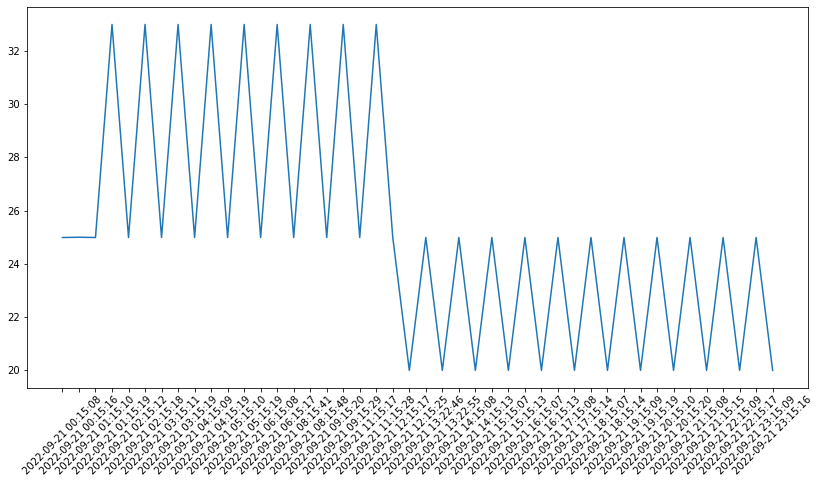

Median: 24.99


,price
count,44.000000
mean,25.265682
std,4.501827
min,20.000000
25%,20.000000
50%,24.990000
75%,24.990000
max,32.990000


In [192]:
product = 'Сырок творожный глазированный Ростагроэкспорт с варёной сгущёнкой 15%, 45 г'

pure = globus.loc[globus['name'] == product,
           ['download_dt', 'price']].sort_values(by='download_dt', ascending=True)

plt.figure(figsize=(14, 7))
plt.plot(pure['download_dt'], pure['price'])
plt.xticks(rotation=45)
plt.show()

print('Median: {}'.format(globus.loc[globus['name'] == product, 'price'].median()))
globus[globus['name'] == product][['name', 'price']].describe()

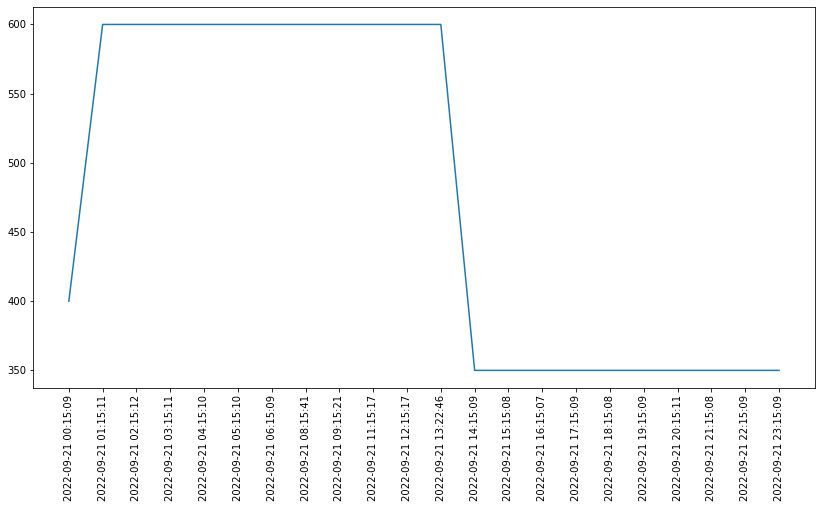

Median: 499.995


,price
count,22.000000
mean,477.267727
std,126.040312
min,350.000000
25%,350.000000
50%,499.995000
75%,599.990000
max,599.990000


In [193]:
product = 'Филе грудки индейки охлажденное Глобус малое, 1 кг'

pure = globus.loc[globus['name'] == product,
           ['download_dt', 'price']].sort_values(by='download_dt', ascending=True)

plt.figure(figsize=(14, 7))
plt.plot(pure['download_dt'], pure['price'])
plt.xticks(rotation=90)
plt.show()

print('Median: {}'.format(globus.loc[globus['name'] == product, 'price'].median()))
globus[globus['name'] == product][['name', 'price']].describe()

### Сравнение предсказаний модели и регулярок

In [395]:
different_cats = pd.read_excel('different_cats.xlsx')

different_cats['product_name'] = different_cats.product_name.apply(str)
different_cats = different_cats.assign(tokens=different_cats.product_name.progress_apply(tokenize_text))

different_cats = different_cats.assign(encoded_tokens=different_cats.tokens.progress_apply(encode_review))

max_seq_len = different_cats.assign(num=different_cats.encoded_tokens.apply(len)).num.max()

X = padding(different_cats.encoded_tokens)

y_pred = model.predict(X)
y_pred_names = [labels_to_names[l] for l in y_pred.argmax(axis=1)]

y_pred_conf = y_pred.max(axis=1)

different_cats.loc[:, 'pred_category'] = y_pred_names
different_cats.loc[:, 'pred_conf'] = y_pred_conf
different_cats[['product_name', 'rosstat_cats_regex', 'rosstat_cats_catalog', 'pred_category', 'pred_conf']]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


,product_name,rosstat_cats_regex,rosstat_cats_catalog,pred_category,pred_conf
0,Крекер Акконд Крекерсы итальянский сыр 180 г,"Сыры сычужные твердые и мягкие, кг","Печенье, кг",Печенье(прочее),0.988685
1,Сыр полутвердый Барановичский МК Маасдам 45%,"Баранина (кроме бескостного мяса), кг","Сыры сычужные твердые и мягкие, кг",Сыры(прочее),0.998471
2,Печенье Петродиет сдобное шоколадное с добавле...,"Консервы овощные для детского питания, кг","Печенье, кг",Шоколад(прочее),0.897124
3,Чай черный Nadin Сицилийское печенье листовой ...,"Печенье, кг","Чай черный байховый, кг",Печенье(прочее),0.522523
4,Сахар-рафинад Русский сахар свекловичный белый...,"Свёкла столовая, кг","Сахар-песок, кг",Чай/кофе(прочее),0.997136
5,Белок яичный куриный МясновЪ ФЕРМА пастеризова...,"Куры охлажденные и мороженые, кг","Яйца куриные, 10 шт.",Прочее,0.999991
6,Мука Алтайкрупа гречневая высшего сорта 500 г,"Крупа гречневая-ядрица, кг","Мука пшеничная, кг",Прочее,0.999886
7,Печенье Пастарель Овсяное Цельнозерновое с яго...,Консервы фруктово-ягодные для детского питания...,"Печенье, кг",Печенье(прочее),0.515022
8,Сыр полутвердый Барановичский МК Монарх 45%,"Баранина (кроме бескостного мяса), кг","Сыры сычужные твердые и мягкие, кг",Сыры(прочее),0.996841
9,Сыр Барановичский МК Монарх БЗМЖ 45%,"Баранина (кроме бескостного мяса), кг","Сыры сычужные твердые и мягкие, кг",Сыры(прочее),0.984361


In [398]:
eggs = pd.read_excel('яйца_класс_прочее.xlsx')

eggs['product_name'] = eggs.product_name.apply(str)
eggs = eggs.assign(tokens=eggs.product_name.progress_apply(tokenize_text))

eggs = eggs.assign(encoded_tokens=eggs.tokens.progress_apply(encode_review))

max_seq_len = eggs.assign(num=eggs.encoded_tokens.apply(len)).num.max()

X = padding(eggs.encoded_tokens)

y_pred = model.predict(X)
y_pred_names = [labels_to_names[l] for l in y_pred.argmax(axis=1)]

y_pred_conf = y_pred.max(axis=1)

eggs.loc[:, 'pred_category'] = y_pred_names
eggs.loc[:, 'pred_conf'] = y_pred_conf
eggs.iloc[:, [0, 1, 5, 6]]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

7/7 [==============================] - 0s 5ms/step


,category_name,product_name,pred_category,pred_conf
0,Яйца,Яйцо перепелиное Шатроэко 20 шт,Яйца(прочее),0.637728
1,Яйца,Яйцо куриное Прово С1 360 шт,"Яйца куриные, 10 шт.",0.999928
2,Яйца,Яйцо перепелиное Тульский перепел 20 шт,Яйца(прочее),0.999841
3,Яйца,Яйцо Птицефабрика Свердловская Кировское Эконо...,"Пельмени, манты, равиоли(прочее)",0.250406
4,Яйца,Яйцо куриное Красногорка C0 360 шт,"Яйца куриные, 10 шт.",0.999905
...,...,...,...,...
213,Яйца,Яйцо Птицефабрика Свердловская Кировское Эконо...,Прочее,0.498292
214,Яйца,Яйцо куриное HoReCa C1 180 шт,"Яйца куриные, 10 шт.",0.995594
215,Яйца,Яйцо куриное Роскар Пользики С0 6 шт,"Яйца куриные, 10 шт.",0.999656
216,Яйца,Яйцо перепелиное Царь-птица 20 шт,Яйца(прочее),0.637728


In [399]:
cheese = pd.read_excel('сыр_класс_прочее.xlsx')

cheese['product_name'] = cheese.product_name.apply(str)
cheese = cheese.assign(tokens=cheese.product_name.progress_apply(tokenize_text))

cheese = cheese.assign(encoded_tokens=cheese.tokens.progress_apply(encode_review))

max_seq_len = cheese.assign(num=cheese.encoded_tokens.apply(len)).num.max()

X = padding(cheese.encoded_tokens)

y_pred = model.predict(X)
y_pred_names = [labels_to_names[l] for l in y_pred.argmax(axis=1)]

y_pred_conf = y_pred.max(axis=1)

cheese.loc[:, 'pred_category'] = y_pred_names
cheese.loc[:, 'pred_conf'] = y_pred_conf
cheese.iloc[:, [0, 1, 5, 6]]

  0%|          | 0/3040 [00:00<?, ?it/s]

  0%|          | 0/3040 [00:00<?, ?it/s]

95/95 [==============================] - 0s 3ms/step


,category_name,product_name,pred_category,pred_conf
0,Твердые и полутвердые сыры,Сыр полутвердый Продукты из Елани Голландский ...,Сыры(прочее),0.999781
1,Мягкие сыры,Сыр мягкий Ришелье Бри с белой плесенью 45% 125 г,Сыры(прочее),0.999988
2,Мягкие сыры,Сыр мягкий Калачево Шевротон выдержанный из ко...,Сыры(прочее),0.999998
3,Мягкие сыры,Сыр мягкий МясновЪ Буррата классическая 60% 150 г,Сыры(прочее),0.989940
4,Твердые и полутвердые сыры,Сыр полутвердый Кобринские сыры Тильзитер 50% ...,"Сыры сычужные твердые и мягкие, кг",0.999999
...,...,...,...,...
3035,Твердые и полутвердые сыры,Сыр полутвердый Киприно Один сыр Российский те...,Сыры(прочее),0.999994
3036,Мягкие сыры,Сыр мягкий Ваша Ферма Кавказский с изюмом 45%,Сыры(прочее),0.999489
3037,Мягкие сыры,Сыр мягкий GrandBlu Intense 56%,Сыры(прочее),0.996360
3038,Твердые и полутвердые сыры,Сыр полутвердый Fratelli Spirin Скаморца с роз...,Сыры(прочее),0.999951


In [401]:
milk = pd.read_excel('молоко_класс_прочее.xlsx')

milk['product_name'] = milk.product_name.apply(str)
milk = milk.assign(tokens=milk.product_name.progress_apply(tokenize_text))

milk = milk.assign(encoded_tokens=milk.tokens.progress_apply(encode_review))

max_seq_len = milk.assign(num=milk.encoded_tokens.apply(len)).num.max()

X = padding(milk.encoded_tokens)

y_pred = model.predict(X)
y_pred_names = [labels_to_names[l] for l in y_pred.argmax(axis=1)]

y_pred_conf = y_pred.max(axis=1)

milk.loc[:, 'pred_category'] = y_pred_names
milk.loc[:, 'pred_conf'] = y_pred_conf
milk.iloc[:, [0, 1, 5, 6]]

  0%|          | 0/997 [00:00<?, ?it/s]

  0%|          | 0/997 [00:00<?, ?it/s]

32/32 [==============================] - 0s 3ms/step


,category_name,product_name,pred_category,pred_conf
0,Молоко,Молоко 6% коровье ультрапастеризованное 928 мл...,Кисломолочные продукты(прочее),0.998461
1,Молоко,"Молоко 2,5% пастеризованное 950 мл Дмитрогорск...","Молоко питьевое цельное пастеризованное 2,5-3,...",0.774898
2,Молоко,"Молоко 1,5% ультрапастеризованное безлактозное...",Кисломолочные продукты(прочее),0.999384
3,Молоко,"Молоко 2,5% пастеризованное 1,4 л Черлакский м...",Прочее,0.800863
4,Молоко,"Молоко детское 3,2% стерилизованное 200 мл Кре...",Кисломолочные продукты(прочее),0.695162
...,...,...,...,...
992,Молоко,"Молоко для детей 3,2% ультрапастеризованное 20...",Кисломолочные продукты(прочее),0.914773
993,Молоко,Молоко 6% ультрапастеризованное 1 л Янта Байка...,Кисломолочные продукты(прочее),0.998744
994,Молоко,"Молоко 3,5% топленое 450 мл Залесский Фермер",Кисломолочные продукты(прочее),0.997225
995,Молоко,"Молоко 2,5% топленое 500 мл",Кисломолочные продукты(прочее),0.995422


## Нормировка единиц измерения товаров

In [48]:
def replace_comma(s):
    return s.replace(',', '.')
    
df_inference['product_name'] = df_inference['product_name'].apply(replace_space)
df_test = df_inference[df_inference['pred_category'] != 'Прочее'].copy()
df_test = df_test.assign(meas_list=df_test.product_name.apply(price_normalizing))
df_test = df_test.assign(number=df_test.meas_list.apply(split_number))
df_test = df_test.assign(measure=df_test.meas_list.apply(split_measure))
df_test['price_current'] = df_test['price_current'].apply(str).apply(replace_comma).apply(float)
df_test

,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units,tokens,encoded_tokens,pred_category,pred_conf,query_goods,meas_list,number,measure
0,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,Orbit Жевательная резинка Бабблминт белоснежны...,78.70,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[orbit, жевательная, резинка, бабблминт, белос...","[15222, 19963, 6462, 12739, 13993]","Жевательная резинка, упаковка",1.000000,"Жевательная резинка, упаковка",30 г,30,г
1,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка ORBIT Bags клубника-банан,...",83.89,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[жевательная, резинка, orbit, bags, клубника-б...","[19963, 6462, 15222, 20784, 12665]","Жевательная резинка, упаковка",0.999999,"Жевательная резинка, упаковка",34г,34,г
2,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка ORBIT ягодный микс, 13,6г",34.90,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[жевательная, резинка, orbit, ягодный, микс]","[19963, 6462, 15222, 11172, 12214]","Жевательная резинка, упаковка",0.999995,"Жевательная резинка, упаковка",6г,6,г
3,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка Orbit Клубника/Банан, 13,6г",34.90,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[жевательная, резинка, orbit, клубника/банан]","[19963, 6462, 15222, 224]","Жевательная резинка, упаковка",1.000000,"Жевательная резинка, упаковка",6г,6,г
4,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,Резинка жевательная Orbit White освежающая мят...,34.90,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[резинка, жевательная, orbit, white, освежающа...","[6462, 19963, 15222, 8830, 24004, 10944, 20687...","Жевательная резинка, упаковка",1.000000,"Жевательная резинка, упаковка",6г,6,г
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6612552,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный Бабаевский с фундуком 100г,131.49,"78,89 ₽",/msk/shokolad-temnyi-babaevskii-s-fundukom-100g,Москва и область,"[шоколад, темный, бабаевский, с, фундуком]","[15374, 11311, 77, 18248, 11673]","Шоколад, кг",0.999974,"Шоколад, кг",100г,100,г
6612553,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный Вдохновение классический 100г К...,132.99,"79,79 ₽",/webapp/wcs/stores/servlet/ProductDisplay?urlR...,Москва и область,"[шоколад, темный, вдохновение, классический, к...","[15374, 11311, 2061, 7273, 20681, 77]","Шоколад, кг",0.999988,"Шоколад, кг",100г,100,г
6612554,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный с помадно-сливочной начинкой Ба...,50.99,"30,59 ₽",/webapp/wcs/stores/servlet/ProductDisplay?urlR...,Москва и область,"[шоколад, темный, с, помадно-сливочной, начинк...","[15374, 11311, 18248, 23171, 22523, 77]","Шоколад, кг",0.999931,"Шоколад, кг",50г,50,г
6612555,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад тёмный Red Классический 26г,54.99,"32,99 ₽",/msk/shokolad-temnyi-red-klassicheskii-26g,Москва и область,"[шоколад, тёмный, red, классический]","[15374, 12117, 10906, 7273]","Шоколад, кг",0.999971,"Шоколад, кг",26г,26,г


In [49]:
df_test.loc[df_test['measure'] == 'л', 'measure_coef'] = 1 / df_test[df_test['measure'] == 'л']['number'].apply(float)
df_test.loc[df_test['measure'] == 'мл', 'measure_coef'] = 1000 / df_test[df_test['measure'] == 'мл']['number'].apply(float)
df_test.loc[df_test['measure'] == 'г', 'measure_coef'] = 1000 / df_test[df_test['measure'] == 'г']['number'].apply(float)
df_test.loc[df_test['measure'] == 'кг', 'measure_coef'] = 1 / df_test[df_test['measure'] == 'кг']['number'].apply(float)
df_test.loc[df_test['measure'] == 'шт', 'measure_coef'] = 10 / df_test[df_test['measure'] == 'шт']['number'].apply(float)
df_test

,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units,tokens,encoded_tokens,pred_category,pred_conf,query_goods,meas_list,number,measure,measure_coef
0,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,Orbit Жевательная резинка Бабблминт белоснежны...,78.70,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[orbit, жевательная, резинка, бабблминт, белос...","[15222, 19963, 6462, 12739, 13993]","Жевательная резинка, упаковка",1.000000,"Жевательная резинка, упаковка",30 г,30,г,33.333333
1,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка ORBIT Bags клубника-банан,...",83.89,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[жевательная, резинка, orbit, bags, клубника-б...","[19963, 6462, 15222, 20784, 12665]","Жевательная резинка, упаковка",0.999999,"Жевательная резинка, упаковка",34г,34,г,29.411765
2,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка ORBIT ягодный микс, 13,6г",34.90,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[жевательная, резинка, orbit, ягодный, микс]","[19963, 6462, 15222, 11172, 12214]","Жевательная резинка, упаковка",0.999995,"Жевательная резинка, упаковка",6г,6,г,166.666667
3,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка Orbit Клубника/Банан, 13,6г",34.90,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[жевательная, резинка, orbit, клубника/банан]","[19963, 6462, 15222, 224]","Жевательная резинка, упаковка",1.000000,"Жевательная резинка, упаковка",6г,6,г,166.666667
4,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,Резинка жевательная Orbit White освежающая мят...,34.90,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[резинка, жевательная, orbit, white, освежающа...","[6462, 19963, 15222, 8830, 24004, 10944, 20687...","Жевательная резинка, упаковка",1.000000,"Жевательная резинка, упаковка",6г,6,г,166.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6612552,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный Бабаевский с фундуком 100г,131.49,"78,89 ₽",/msk/shokolad-temnyi-babaevskii-s-fundukom-100g,Москва и область,"[шоколад, темный, бабаевский, с, фундуком]","[15374, 11311, 77, 18248, 11673]","Шоколад, кг",0.999974,"Шоколад, кг",100г,100,г,10.000000
6612553,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный Вдохновение классический 100г К...,132.99,"79,79 ₽",/webapp/wcs/stores/servlet/ProductDisplay?urlR...,Москва и область,"[шоколад, темный, вдохновение, классический, к...","[15374, 11311, 2061, 7273, 20681, 77]","Шоколад, кг",0.999988,"Шоколад, кг",100г,100,г,10.000000
6612554,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный с помадно-сливочной начинкой Ба...,50.99,"30,59 ₽",/webapp/wcs/stores/servlet/ProductDisplay?urlR...,Москва и область,"[шоколад, темный, с, помадно-сливочной, начинк...","[15374, 11311, 18248, 23171, 22523, 77]","Шоколад, кг",0.999931,"Шоколад, кг",50г,50,г,20.000000
6612555,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад тёмный Red Классический 26г,54.99,"32,99 ₽",/msk/shokolad-temnyi-red-klassicheskii-26g,Москва и область,"[шоколад, тёмный, red, классический]","[15374, 12117, 10906, 7273]","Шоколад, кг",0.999971,"Шоколад, кг",26г,26,г,38.461538


In [50]:
df_test.loc[~df_test['measure_coef'].isnull(), 'norm_price'] = df_test['price_current'].apply(float) * df_test['measure_coef']
df_test.loc[df_test['measure_coef'].isnull(), 'norm_price'] = df_test['price_current']
df_test

,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units,tokens,encoded_tokens,pred_category,pred_conf,query_goods,meas_list,number,measure,measure_coef,norm_price
0,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,Orbit Жевательная резинка Бабблминт белоснежны...,78.70,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[orbit, жевательная, резинка, бабблминт, белос...","[15222, 19963, 6462, 12739, 13993]","Жевательная резинка, упаковка",1.000000,"Жевательная резинка, упаковка",30 г,30,г,33.333333,2623.333333
1,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка ORBIT Bags клубника-банан,...",83.89,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[жевательная, резинка, orbit, bags, клубника-б...","[19963, 6462, 15222, 20784, 12665]","Жевательная резинка, упаковка",0.999999,"Жевательная резинка, упаковка",34г,34,г,29.411765,2467.352941
2,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка ORBIT ягодный микс, 13,6г",34.90,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[жевательная, резинка, orbit, ягодный, микс]","[19963, 6462, 15222, 11172, 12214]","Жевательная резинка, упаковка",0.999995,"Жевательная резинка, упаковка",6г,6,г,166.666667,5816.666667
3,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,"Жевательная резинка Orbit Клубника/Банан, 13,6г",34.90,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[жевательная, резинка, orbit, клубника/банан]","[19963, 6462, 15222, 224]","Жевательная резинка, упаковка",1.000000,"Жевательная резинка, упаковка",6г,6,г,166.666667,5816.666667
4,1,2022-06-07 01:24:51,NaN,Жевательная резинка,Жевательная резинка,Резинка жевательная Orbit White освежающая мят...,34.90,NaN,category/hleb-vypechka-konditerskie-izdeliya/z...,Москва и область,"[резинка, жевательная, orbit, white, освежающа...","[6462, 19963, 15222, 8830, 24004, 10944, 20687...","Жевательная резинка, упаковка",1.000000,"Жевательная резинка, упаковка",6г,6,г,166.666667,5816.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6612552,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный Бабаевский с фундуком 100г,131.49,"78,89 ₽",/msk/shokolad-temnyi-babaevskii-s-fundukom-100g,Москва и область,"[шоколад, темный, бабаевский, с, фундуком]","[15374, 11311, 77, 18248, 11673]","Шоколад, кг",0.999974,"Шоколад, кг",100г,100,г,10.000000,1314.900000
6612553,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный Вдохновение классический 100г К...,132.99,"79,79 ₽",/webapp/wcs/stores/servlet/ProductDisplay?urlR...,Москва и область,"[шоколад, темный, вдохновение, классический, к...","[15374, 11311, 2061, 7273, 20681, 77]","Шоколад, кг",0.999988,"Шоколад, кг",100г,100,г,10.000000,1329.900000
6612554,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад темный с помадно-сливочной начинкой Ба...,50.99,"30,59 ₽",/webapp/wcs/stores/servlet/ProductDisplay?urlR...,Москва и область,"[шоколад, темный, с, помадно-сливочной, начинк...","[15374, 11311, 18248, 23171, 22523, 77]","Шоколад, кг",0.999931,"Шоколад, кг",50г,50,г,20.000000,1019.800000
6612555,16,2022-04-29 10:36:20,sladosti-khleb,shokoladnaia-plitka,shokoladnaia-plitka,Шоколад тёмный Red Классический 26г,54.99,"32,99 ₽",/msk/shokolad-temnyi-red-klassicheskii-26g,Москва и область,"[шоколад, тёмный, red, классический]","[15374, 12117, 10906, 7273]","Шоколад, кг",0.999971,"Шоколад, кг",26г,26,г,38.461538,2115.000000


## Вычисление средней цены по категориям

In [57]:
df_test['download_dt'] = pd.to_datetime(df_test['download_dt'])
df_test.head()

,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units,tokens,encoded_tokens,pred_category,pred_conf,query_goods,meas_list,number,measure,measure_coef,norm_price
3,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло крестьянское 72,5%, 200 г",210.0,NaN,/goods/maslo-krestyanskoe-72-5-200-g-23071.html,Москва и область,"[масло, крестьянское]","[7031, 9099]","Масло сливочное, кг",0.996751,"Масло сливочное, кг",200 г,200,г,5.0,1050.0
4,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 72,5%_РП",190.0,NaN,/goods/maslo-slivochnoe-72-5-rp-63699.html,Москва и область,"[масло, сливочное, _рп]","[7031, 13701, 10796]","Масло сливочное, кг",0.999956,"Масло сливочное, кг",,,,NaN,190.0
5,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 82,5%",1190.0,NaN,/goods/maslo-slivochnoe-82-5-46.html,Москва и область,"[масло, сливочное]","[7031, 13701]","Масло сливочное, кг",0.999590,"Масло сливочное, кг",,,,NaN,1190.0
6,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 82,5%, 100г",131.0,NaN,/goods/maslo-slivochnoe-82-5-100g-43701.html,Москва и область,"[масло, сливочное]","[7031, 13701]","Масло сливочное, кг",0.999590,"Масло сливочное, кг",100г,100,г,10.0,1310.0
7,4,2022-06-07 19:04:53,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 82,5%, 200 г",236.0,NaN,/goods/maslo-slivochnoe-82-5-200-g-16306.html,Москва и область,"[масло, сливочное]","[7031, 13701]","Масло сливочное, кг",0.999590,"Масло сливочное, кг",200 г,200,г,5.0,1180.0


In [58]:
grouped = df_test.groupby([pd.Grouper(freq='W-FRI', key='download_dt'), 'pred_category'])\
            .agg({'norm_price': 'median'})
grouped

norm_price
download_dt pred_category                                     
2022-01-07  Варенье, джем, повидло, кг              184.000000
            Вода минеральная и питьевая, л           95.000000
            Говядина бескостная, кг                 679.000000
            Икра лососевых рыб, отечественная, кг   959.259259
            Йогурт, кг                               43.000000
...                                                        ...
2022-08-12  Чеснок, кг                              910.000000
            Шоколад, кг                            1635.294118
            Яблоки, кг                              157.500000
            Ягоды замороженные, кг                  670.833333
            Яйца куриные, 10 шт.                     80.000000

[2930 rows x 1 columns]

In [59]:
grouped_uns = grouped.unstack()
grouped_uns.fillna(method='ffill')
# grouped_uns

norm_price                                                    \
pred_category Апельсины, кг  Бананы, кг Баранина (кроме бескостного мяса), кг   
download_dt                                                                     
2022-01-07              NaN         NaN                                   NaN   
2022-01-14            150.0   12.333333                                   NaN   
2022-01-21            152.5   12.333333                            436.142857   
2022-01-28            191.5   12.333333                            436.142857   
2022-02-04            150.0   12.333333                            436.142857   
2022-02-11            150.0   14.000000                            436.142857   
2022-02-18            150.0   14.833333                            436.142857   
2022-02-25             54.5   14.833333                            436.142857   
2022-03-04             54.5   14.833333                            436.142857   
2022-03-11             54.5   14.833333                            436.142857   
2022-03-18             54.5  145.000000                            436.142857   
2022-03-25             54.5  145.000000                            436.142857   
2022-04-01            118.0  145.000000                           1299.000000   
2022-04-08            118.0  145.000000                           1299.000000   
2022-04-15            190.0  145.000000                           1299.000000   
2022-04-22            162.0  145.000000                           1299.000000   
2022-04-29            184.0   98.000000                           1299.000000   
2022-05-06            178.0   98.000000                           1299.000000   
2022-05-13            181.0  106.500000                           1299.000000   
2022-05-20            184.0  119.000000                           1299.000000   
2022-05-27            178.0  106.750000                            162.857143   
2022-06-03            201.0   98.000000                            750.000000   
2022-06-10            198.0  100.000000                           1299.000000   
2022-06-17            198.0   93.250000                           1299.000000   
2022-06-24            233.0   89.000000                           1024.500000   
2022-07-01            236.5   82.000000                           1299.000000   
2022-07-08            156.0   78.000000                           1299.000000   
2022-07-15            156.0   78.000000                           1299.000000   
2022-07-22            129.0   78.000000                           1299.000000   
2022-07-29            138.0   79.000000                           1299.000000   
2022-08-05            167.0   79.000000                           1299.000000   
2022-08-12            167.0   79.000000                           1299.000000   

                                      \
pred_category Бараночные изделия, кг   
download_dt                            
2022-01-07                       NaN   
2022-01-14                245.000000   
2022-01-21                266.666667   
2022-01-28                311.250000   
2022-02-04                210.000000   
2022-02-11                 63.000000   
2022-02-18                 59.000000   
2022-02-25                215.000000   
2022-03-04                 55.000000   
2022-03-11                 55.000000   
2022-03-18                236.666667   
2022-03-25                 62.500000   
2022-04-01               1250.000000   
2022-04-08                 61.000000   
2022-04-15                 70.000000   
2022-04-22                295.000000   
2022-04-29                 70.000000   
2022-05-06                 61.000000   
2022-05-13                 70.000000   
2022-05-20                 61.000000   
2022-05-27                236.363636   
2022-06-03                 70.000000   
2022-06-10                 70.000000   
2022-06-17                 70.000000   
2022-06-24                 61.000000   
2022-07-01                 61.000000   
2022-07-08           

In [63]:
grouped_uns.to_excel('ВкусВилл_средние_цены_по_неделям_2408.xlsx')

In [338]:
df_test.groupby('pred_category').agg({'norm_price': 'median'})#['norm_price'].reset_index()

,norm_price
pred_category,
"Апельсины, кг",178.000000
"Бананы, кг",96.250000
"Баранина (кроме бескостного мяса), кг",1299.000000
"Бараночные изделия, кг",62.000000
"Булочные изделия сдобные из муки высшего сорта штучные, кг",320.000000
...,...
"Чеснок, кг",745.000000
"Шоколад, кг",1000.000000
"Яблоки, кг",194.500000


## Вычисление ИПЦ

### Генерация временных рядов для отдельных товаров

In [51]:
dt_index = pd.date_range(start='20220101', end='20220810', freq='D')
dt_index

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
               '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08',
               '2022-08-09', '2022-08-10'],
              dtype='datetime64[ns]', length=222, freq='D')

In [52]:
time_ser = pd.DataFrame(index=dt_index).reset_index()
time_ser['index'] = pd.to_datetime(time_ser['index']).dt.date
time_ser

,index
0,2022-01-01
1,2022-01-02
2,2022-01-03
3,2022-01-04
4,2022-01-05
...,...
217,2022-08-06
218,2022-08-07
219,2022-08-08
220,2022-08-09


In [53]:
df_test['download_dt'] = pd.to_datetime(df_test['download_dt']).dt.date

In [54]:
time_ser['index'] = time_ser['index'].apply(str)
df_test['download_dt'] = df_test['download_dt'].apply(str)
df_test['price_current'] = df_test['price_current'].apply(float)
df_test = df_test[df_test['price_current'] > 0]

In [55]:
time_ser = time_ser.merge(right=df_test, left_on='index', right_on='download_dt', how='left')
time_ser

,index,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,...,tokens,encoded_tokens,pred_category,pred_conf,query_goods,meas_list,number,measure,measure_coef,norm_price
0,2022-01-01,1.0,2022-01-01,NaN,myasnaya-gastronomiya,pashtety-sneki,"Hame Паштет деликатесный из индейки, 105г",47.91,NaN,/category/myasnaya-gastronomiya/pashtety-sneki...,...,"[hame, паштет, деликатесный, из, индейки]","[10873, 11277, 9767, 19961, 11396]","Мясо индейки, кг",0.602919,Прочее,105г,105,г,9.523810,456.285714
1,2022-01-01,1.0,2022-01-01,NaN,myasnaya-gastronomiya,delikatesy,"Балык ВЕЛКОМ сырокопченый, 350г",299.00,NaN,/category/myasnaya-gastronomiya/delikatesy/bal...,...,"[балык, велком, сырокопченый]","[18935, 16469, 6677]","Помидоры свежие, кг",0.912943,Прочее,350г,350,г,2.857143,854.285714
2,2022-01-01,1.0,2022-01-01,NaN,myasnaya-gastronomiya,delikatesy,"Бекон Велком сырокопченый, 500г",329.00,NaN,/category/myasnaya-gastronomiya/delikatesy/bek...,...,"[бекон, велком, сырокопченый]","[10420, 16469, 6677]","Мясокопчености, кг",0.532722,Прочее,500г,500,г,2.000000,658.000000
3,2022-01-01,1.0,2022-01-01,NaN,myasnaya-gastronomiya,delikatesy,Бекон Дымов Датский копчено-вареный 500г,460.00,NaN,/category/myasnaya-gastronomiya/delikatesy/500...,...,"[бекон, дымов, датский, копчено-вареный]","[10420, 11523, 19809, 10829]","Мясокопчености, кг",0.818874,"Мясокопчености, кг",500г,500,г,2.000000,920.000000
4,2022-01-01,1.0,2022-01-01,NaN,myasnaya-gastronomiya,delikatesy,"Бужане КЛИНСКИЙ, 550г",399.00,NaN,/category/myasnaya-gastronomiya/delikatesy/buz...,...,"[бужане, клинский]","[14875, 18704]","Молоко питьевое цельное стерилизованное 2,5-3,...",0.999927,Прочее,550г,550,г,1.818182,725.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066038,2022-08-10,8.0,2022-08-10,4360,4360,frukty-v-shokolade,Конфеты Самарский Кондитер Чернослив в шоколад...,363.00,NaN,/product/samarskiy-konditer-konf-cher-v-shok-s...,...,"[конфеты, самарский, кондитер, чернослив, в, ш...","[5062, 4625, 7930, 4939, 2606, 22815, 18248, 3...","Конфеты мягкие, глазированные шоколадом, кг",0.991417,"Конфеты мягкие, глазированные шоколадом, кг",240г,240,г,4.166667,1512.500000
3066039,2022-08-10,8.0,2022-08-10,4360,4360,frukty-v-shokolade,Конфеты Фруже Инжир с трюфельной начинкой в шо...,295.00,NaN,/product/fruje-fruje-konf-injir-s-tryuf-nach19...,...,"[конфеты, фруже, инжир, с, трюфельной, начинко...","[5062, 16385, 11115, 18248, 810, 22523, 2606, ...","Конфеты мягкие, глазированные шоколадом, кг",0.999483,"Конфеты мягкие, глазированные шоколадом, кг",190г,190,г,5.263158,1552.631579
3066040,2022-08-10,8.0,2022-08-10,4360,4360,frukty-v-shokolade,Конфеты Фруже Фрукты в шоколаде 190г,149.00,299.0,/product/fruje-fruje-konfety-frukty-v-shok-gl-...,...,"[конфеты, фруже, фрукты, в, шоколаде]","[5062, 16385, 21640, 2606, 22815]","Конфеты мягкие, глазированные шоколадом, кг",0.999443,"Конфеты мягкие, глазированные шоколадом, кг",190г,190,г,5.263158,784.210526
3066041,2022-08-10,8.0,2022-08-10,4360,4360,frukty-v-shokolade,Конфеты Фруже Чернослив в шоколаде 190г,149.00,329.0,/product/fruje-fruje-konfety-chernosliv-v-shok...,...,"[конфеты, фруже, чернослив, в, шоколаде]","[5062, 16385, 4939, 2606, 22815]","Конфеты мягкие, глазированные шоколадом, кг",0.999287,"Конфеты мягкие, глазированные шоколадом, кг",190г,190,г,5.263158,784.210526


In [56]:
time_ser = time_ser.fillna(method='ffill')

In [57]:
time_ser['index'] = pd.to_datetime(time_ser['index'])

### Группировка цен по товарам и дням

In [87]:
time_grouped = time_ser.groupby(['index', 'product_name'])\
            .agg({'price_current': 'median'}).unstack()
time_grouped

price_current  \
product_name  Биойогурт Bio-Max Super Food Красный апельсин-персик-алоэ 1.5% 270г   
index                                                                               
2022-01-01                                                  NaN                     
2022-01-02                                                  NaN                     
2022-01-03                                                  NaN                     
2022-01-04                                                  NaN                     
2022-01-05                                                  NaN                     
...                                                         ...                     
2022-08-06                                                  NaN                     
2022-08-07                                                  NaN                     
2022-08-08                                                  NaN                     
2022-08-09                                                  NaN                     
2022-08-10                                                  NaN                     

                                                                                     \
product_name  Биойогурт Bio-Max Super Food Крыжовник-киви-семена базилика 1.5% 270г   
index                                                                                 
2022-01-01                                                  NaN                       
2022-01-02                                                  NaN                       
2022-01-03                                                  NaN                       
2022-01-04                                                  NaN                       
2022-01-05                                                  NaN                       
...                                                         ...                       
2022-08-06                                                  NaN                       
2022-08-07                                                  NaN                       
2022-08-08                                                  NaN                       
2022-08-09                                                  NaN                       
2022-08-10                                                  NaN                       

                                                                                  \
product_name  Веселая энциклопедия в картинках обо всем на свете / Тьерри Лаваль   
index                                                                              
2022-01-01                                                  NaN                    
2022-01-02                                                  NaN                    
2022-01-03                                                  NaN                    
2022-01-04                                                  NaN                    
2022-01-05                                                  NaN                    
...                                                         ...                    
2022-08-06                                                  NaN                    
2022-08-07                                                  NaN                    
2022-08-08                                                  NaN                    
2022-08-09                                                  NaN                    
2022-08-10                                                  NaN                    

                                                                                                              \
product_name  Вино Gunko Winery Совиньон Блан геогр. указ. бел. сух. 12,0-13,5% 0,75л (Россия) / ВИНО РОССИИ   
index                                                                                                          
2022-01-01                                                  NaN                                                
2022-01-02                       

In [88]:
# time_grouped = time_grouped.fillna(method='ffill', limit=7).fillna(method='bfill', limit=7)
time_grouped = time_grouped.fillna(method='bfill').fillna(method='ffill')
time_grouped.columns = time_grouped.columns.droplevel(0)
time_grouped

product_name,Биойогурт Bio-Max Super Food Красный апельсин-персик-алоэ 1.5% 270г,Биойогурт Bio-Max Super Food Крыжовник-киви-семена базилика 1.5% 270г,Веселая энциклопедия в картинках обо всем на свете / Тьерри Лаваль,"Вино Gunko Winery Совиньон Блан геогр. указ. бел. сух. 12,0-13,5% 0,75л (Россия) / ВИНО РОССИИ","Вино Кубань Рислинг геогр. указ. бел. сух. 12,0-13,5% 0,75л (Россия) / ВИНО РОССИИ",Вода Arctic артезианская питьевая негазированная 500мл,Джем «Клубничный» с эритритом,Икра трески атлантическая Nord Pilgrim 270 г,Йогурт Epica Яблоко-корица 4.8% 190г,Йогурт Valio Clean label Сицилийский смусси Мандарин-Лайм 2.6% 140г,...,"Яйцо куриное столовое 2 категории, 10 шт","Яйцо куриное столовое Волжанин Двухжелтковое, 10...","Яйцо куриное столовое отборное, 10 шт","Яйцо столовое ОКСКОЕ С0, 30шт","Янтарная рыбка ""Мореслав"", соломка, с перцем, 70 г","Янтарная рыбка Мореслав, соломка, с перцем, 70 г","Янтарная рыбка сушёная BEERka с перцем, 40 г",Янтарная рыбка сушёно-вяленая Хэппи-Фиш с перце...,"Янтарная форель охлаждённая, тушка, Армени...",Ячмень Всем на пользу в оболочке 500г
index,,,,,,,,,,,,,,,,,,,,,
2022-01-01,39.0,39.0,665.0,1149.0,1099.0,27.0,148.0,164.0,89.0,69.0,...,80.33,144.99,93.72,326.0,92.69,82.30,73.99,65.99,749.9,63.0
2022-01-02,39.0,39.0,665.0,1149.0,1099.0,27.0,148.0,164.0,89.0,69.0,...,80.33,144.99,93.72,326.0,92.69,82.30,73.99,65.99,749.9,63.0
2022-01-03,39.0,39.0,665.0,1149.0,1099.0,27.0,148.0,164.0,89.0,69.0,...,80.33,144.99,93.72,326.0,92.69,82.30,73.99,65.99,749.9,63.0
2022-01-04,39.0,39.0,665.0,1149.0,1099.0,27.0,148.0,164.0,89.0,69.0,...,80.33,144.99,93.72,326.0,92.69,82.30,73.99,65.99,749.9,63.0
2022-01-05,39.0,39.0,665.0,1149.0,1099.0,27.0,148.0,164.0,89.0,69.0,...,80.33,144.99,93.72,326.0,92.69,82.30,73.99,65.99,749.9,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-06,59.0,59.0,1299.0,1149.0,1099.0,41.0,148.0,164.0,84.0,69.0,...,41.19,144.99,76.21,349.0,92.69,92.69,73.99,75.99,749.9,75.0
2022-08-07,59.0,59.0,1299.0,1149.0,1099.0,41.0,148.0,164.0,84.0,69.0,...,41.19,144.99,76.21,349.0,92.69,92.69,73.99,155.99,749.9,75.0
2022-08-08,59.0,59.0,1299.0,1149.0,1099.0,41.0,148.0,164.0,84.0,69.0,...,41.19,144.99,75.18,349.0,92.69,92.69,73.99,155.99,749.9,75.0


### Мэтчинг товаров Парсинг-СберМаркет

In [69]:
sbermarket = pd.read_excel('products_purchase.xlsx')
sbermarket

,month_dt,retailer,product_name,n_order,n_user,money_spent,quantity
0,2022-07-01,ВКУСВИЛЛ,Бананы Эквадор,1609,1243,94103.450197,1854
1,2022-07-01,ВКУСВИЛЛ,Яйцо Вкусвилл куриное С0 10 шт,954,794,91584.000000,1104
2,2022-07-01,ВКУСВИЛЛ,Картофель молодой,670,590,49938.310019,1146
3,2022-07-01,ВКУСВИЛЛ,Помидоры Махито Азербайджан,697,589,76184.869946,908
4,2022-07-01,ВКУСВИЛЛ,Лук репчатый ВкусВилл ~600 г,601,542,27435.780083,655
...,...,...,...,...,...,...,...
19255,2022-08-01,ПЕРЕКРЕСТОК,Сырок творожный Ростагроэкспорт с сахаром и ар...,1,1,51.990002,2
19256,2022-08-01,ПЕРЕКРЕСТОК,Сыр полутвердый Киприно Мастер 50% БЗМЖ,1,1,694.390015,1
19257,2022-08-01,ПЕРЕКРЕСТОК,"Йогурт Epica Crispy Фисташки 4,8% БЗМЖ 140 г",1,1,75.989998,1
19258,2022-08-01,ПЕРЕКРЕСТОК,Мармелад Каждый День со вкусом лимона 300 г,1,1,65.989998,3


In [89]:
import difflib
my_str = 'Хинкали ВкусВилл с говядиной и свининой 480г'
match = difflib.get_close_matches(my_str, sbermarket['product_name'].values)
match

['Хинкали ВкусВилл с говядиной и свининой 480 г',
 'Хинкали ВкусВилл с говядиной и свининой 480 г',
 'Пельмени ВкусВилл с говядиной и свининой 800 г']

In [91]:
difflib.SequenceMatcher(None, my_str, match[2]).ratio() 

0.8444444444444444

In [71]:
match_df = df_test.copy()
for name in tqdm(match_df.product_name.unique()):
    try:
        match_df. \
            loc[match_df['product_name'] == name,
                'sber_name'] = difflib.get_close_matches(name, sbermarket['product_name'].values)[0]
    except:
        continue

match_df

100%|██████████████████████████████████| 12787/12787 [17:33:02<00:00,  4.94s/it]


,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units,...,encoded_tokens,pred_category,pred_conf,query_goods,meas_list,number,measure,measure_coef,norm_price,sber_name
3,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло крестьянское 72,5%, 200 г",210.0,NaN,/goods/maslo-krestyanskoe-72-5-200-g-23071.html,Москва и область,...,"[7031, 9099]","Масло сливочное, кг",0.996751,"Масло сливочное, кг",200 г,200,г,5.000000,1050.000000,"Сливочное масло ВкусВилл Крестьянское 72,5% 100 г"
4,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 72,5%_РП",190.0,NaN,/goods/maslo-slivochnoe-72-5-rp-63699.html,Москва и область,...,"[7031, 13701, 10796]","Масло сливочное, кг",0.999956,"Масло сливочное, кг",,,,NaN,190.000000,NaN
5,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 82,5%",1190.0,NaN,/goods/maslo-slivochnoe-82-5-46.html,Москва и область,...,"[7031, 13701]","Масло сливочное, кг",0.999590,"Масло сливочное, кг",,,,NaN,1190.000000,NaN
6,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 82,5%, 100г",131.0,NaN,/goods/maslo-slivochnoe-82-5-100g-43701.html,Москва и область,...,"[7031, 13701]","Масло сливочное, кг",0.999590,"Масло сливочное, кг",100г,100,г,10.000000,1310.000000,Масло ВкусВилл селедочное 100 г
7,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 82,5%, 200 г",236.0,NaN,/goods/maslo-slivochnoe-82-5-200-g-16306.html,Москва и область,...,"[7031, 13701]","Масло сливочное, кг",0.999590,"Масло сливочное, кг",200 г,200,г,5.000000,1180.000000,Масло ВкусВилл селедочное 100 г
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920326,8,2022-04-29,1591,1591,elektronnye-igry-i-igrushki,Игрушка Три кота Коржик со звуком 15.7см,1475.0,NaN,/product/tri-kota-tri-kota-korjik-15-7sm-zv--1...,Москва и область,...,"[11261, 180, 11681, 5368, 24434, 21574, 1]",Булочные изделия сдобные из муки высшего сорта...,0.997866,Прочее,,,,NaN,1475.000000,NaN
920362,8,2022-04-29,3967,3967,hinkali,Хинкали ВкусВилл с говядиной и свининой 480г,450.0,NaN,/product/vkusvill-vv-hinkali-s-gov-i-sv-y-480g...,Москва и область,...,"[17866, 24156, 9270, 17039, 10228, 5611]","Пельмени, манты, равиоли, кг",0.997018,"Пельмени, манты, равиоли, кг",480г,480,г,2.083333,937.500000,Хинкали ВкусВилл с говядиной и свининой 480 г
920363,8,2022-04-29,3967,3967,hinkali,Хинкали Ложкаревъ По-восточному 900г,320.0,NaN,/product/lojkarev-lojkar-hinkali-po-vostochnom...,Москва и область,...,"[17866, 18204, 19610]","Пельмени, манты, равиоли, кг",0.999998,"Пельмени, манты, равиоли, кг",900г,900,г,1.111111,355.555556,NaN
920364,8,2022-04-29,3967,3967,hinkali,Хинкали Мираторг по-грузински 800г,567.0,NaN,/product/miratorg-mirat-hinkali-po-gruzinski-8...,Москва и область,...,"[17866, 9527, 4770]","Пельмени, манты, равиоли, кг",0.999983,"Пельмени, манты, равиоли, кг",800г,800,г,1.250000,708.750000,Пельмени Мираторг Фермерские 800 г


In [74]:
match_df[~match_df['sber_name'].isnull()].product_name.nunique()

9368

In [76]:
match_df.product_name.nunique()

12787

In [77]:
match_df[~match_df['sber_name'].isnull()]

,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units,...,encoded_tokens,pred_category,pred_conf,query_goods,meas_list,number,measure,measure_coef,norm_price,sber_name
3,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло крестьянское 72,5%, 200 г",210.0,NaN,/goods/maslo-krestyanskoe-72-5-200-g-23071.html,Москва и область,...,"[7031, 9099]","Масло сливочное, кг",0.996751,"Масло сливочное, кг",200 г,200,г,5.000000,1050.000000,"Сливочное масло ВкусВилл Крестьянское 72,5% 100 г"
6,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 82,5%, 100г",131.0,NaN,/goods/maslo-slivochnoe-82-5-100g-43701.html,Москва и область,...,"[7031, 13701]","Масло сливочное, кг",0.999590,"Масло сливочное, кг",100г,100,г,10.000000,1310.000000,Масло ВкусВилл селедочное 100 г
7,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 82,5%, 200 г",236.0,NaN,/goods/maslo-slivochnoe-82-5-200-g-16306.html,Москва и область,...,"[7031, 13701]","Масло сливочное, кг",0.999590,"Масло сливочное, кг",200 г,200,г,5.000000,1180.000000,Масло ВкусВилл селедочное 100 г
9,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное безлактозное 72,5%",203.0,NaN,/goods/maslo-slivochnoe-bezlaktoznoe-72-5-3699...,Москва и область,...,"[7031, 13701, 11468]","Масло сливочное, кг",0.999700,"Масло сливочное, кг",,,,NaN,203.000000,Сливочное масло сладкосливочное Тысяча Озер бе...
21,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Молоко 2,5% 900мл_РП",104.0,NaN,/goods/moloko-2-5-900ml-rp-63768.html,Москва и область,...,[5661],"Молоко питьевое цельное стерилизованное 2,5-3,...",0.999663,"Молоко питьевое цельное стерилизованное 2,5-3,...",900мл,900,мл,1.111111,115.555556,"Биолакт Простоквашино 2,5% 900 мл"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920211,8,2022-04-29,4376,4376,jevatelnye-i-iriski,Конфеты Fazer Dumle Original Ирис в молочном ш...,308.0,NaN,/product/fazer-fazer-konfety-dumle-origin-150g...,Москва и область,...,"[714, 23570, 16479, 20765, 1616, 8844, 14759, ...","Конфеты мягкие, глазированные шоколадом, кг",0.999849,"Конфеты мягкие, глазированные шоколадом, кг",150г,150,г,6.666667,2053.333333,Конфеты Malibu кокос в молочном шоколаде 140 г
920233,8,2022-04-29,1359,1359,griby-sushenye,Подосиновики Кедровый Бор сушеные 45г,353.0,NaN,/product/kedrovyy-bor-kedrovyy-bor-griby-podos...,Москва и область,...,"[17458, 187, 6345, 6925]","Зелень свежая, кг",0.831786,Прочее,45г,45,г,22.222222,7844.444444,Подосиновики сушеные Кедровый бор резаные 45 г
920362,8,2022-04-29,3967,3967,hinkali,Хинкали ВкусВилл с говядиной и свининой 480г,450.0,NaN,/product/vkusvill-vv-hinkali-s-gov-i-sv-y-480g...,Москва и область,...,"[17866, 24156, 9270, 17039, 10228, 5611]","Пельмени, манты, равиоли, кг",0.997018,"Пельмени, манты, равиоли, кг",480г,480,г,2.083333,937.500000,Хинкали ВкусВилл с говядиной и свининой 480 г
920364,8,2022-04-29,3967,3967,hinkali,Хинкали Мираторг по-грузински 800г,567.0,NaN,/product/miratorg-mirat-hinkali-po-gruzinski-8...,Москва и область,...,"[17866, 9527, 4770]","Пельмени, манты, равиоли, кг",0.999983,"Пельмени, манты, равиоли, кг",800г,800,г,1.250000,708.750000,Пельмени Мираторг Фермерские 800 г


In [83]:
match_df.drop_duplicates(subset='product_name')

,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units,...,encoded_tokens,pred_category,pred_conf,query_goods,meas_list,number,measure,measure_coef,norm_price,sber_name
3,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло крестьянское 72,5%, 200 г",210.0,NaN,/goods/maslo-krestyanskoe-72-5-200-g-23071.html,Москва и область,...,"[7031, 9099]","Масло сливочное, кг",0.996751,"Масло сливочное, кг",200 г,200,г,5.000000,1050.000000,"Сливочное масло ВкусВилл Крестьянское 72,5% 100 г"
4,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 72,5%_РП",190.0,NaN,/goods/maslo-slivochnoe-72-5-rp-63699.html,Москва и область,...,"[7031, 13701, 10796]","Масло сливочное, кг",0.999956,"Масло сливочное, кг",,,,NaN,190.000000,NaN
5,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 82,5%",1190.0,NaN,/goods/maslo-slivochnoe-82-5-46.html,Москва и область,...,"[7031, 13701]","Масло сливочное, кг",0.999590,"Масло сливочное, кг",,,,NaN,1190.000000,NaN
6,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 82,5%, 100г",131.0,NaN,/goods/maslo-slivochnoe-82-5-100g-43701.html,Москва и область,...,"[7031, 13701]","Масло сливочное, кг",0.999590,"Масло сливочное, кг",100г,100,г,10.000000,1310.000000,Масло ВкусВилл селедочное 100 г
7,4,2022-06-07,NaN,molochnye-produkty-yaytso/?PAGEN_1=7,NaN,"Масло сливочное 82,5%, 200 г",236.0,NaN,/goods/maslo-slivochnoe-82-5-200-g-16306.html,Москва и область,...,"[7031, 13701]","Масло сливочное, кг",0.999590,"Масло сливочное, кг",200 г,200,г,5.000000,1180.000000,Масло ВкусВилл селедочное 100 г
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908714,4,2022-04-28,NaN,syry/?PAGEN_1=6,NaN,Сыр полутвердый «Фиорентина Фреско»,895.0,NaN,/goods/syr-polutverdyy-fiorentina-fresko-44259...,Москва и область,...,"[12877, 15205, 1404, 2986]","Сыры сычужные твердые и мягкие, кг",0.974674,"Сыры сычужные твердые и мягкие, кг",,,,NaN,895.000000,Сыр полутвердый Костромской
908715,4,2022-04-28,NaN,syry/?PAGEN_1=6,NaN,Сыр полутвердый «Янтарное солнце»,298.0,NaN,/goods/syr-polutverdyy-yantarnoe-solntse-53814...,Москва и область,...,"[12877, 15205, 1583, 15264]","Сыры сычужные твердые и мягкие, кг",0.992899,"Сыры сычужные твердые и мягкие, кг",,,,NaN,298.000000,Сыр полутвердый Бон-Дари Эстонский 45%
916175,8,2022-04-29,1382,1382,tvorog-syrki,Десерт творожный Б.Ю.Александров с ванилью в м...,73.0,NaN,/product/b-yu-aleksandrov-bzmj-aleks-des-x-l-v...,Москва и область,...,"[6866, 19390, 1745, 9270, 17040, 8844, 14759, ...","Сырки творожные, глазированные шоколадом, кг",0.998298,Прочее,50г,50,г,20.000000,1460.000000,Сырок творожный ВкусВилл С ванилью в молочном ...
916211,8,2022-04-29,1382,1382,tvorog-syrki,Творог Буренкино 9% 180г,49.0,NaN,/product/burenkino-burenkino-tvorog-9-180g--30...,Москва и область,...,"[23131, 4714]","Творог, кг",0.999982,"Творог, кг",180г,180,г,5.555556,272.222222,Творог зерненый Буренкино 9% 180 г


In [84]:
match_df.drop_duplicates(subset='product_name').to_excel('match_df.xlsx', index=False)

### Недельный индекс по категориям

In [522]:
index = time_grouped.reset_index().groupby(pd.Grouper(freq='W-FRI', key='index')).agg('median').index
week_change = pd.DataFrame(columns=time_grouped.columns, index=index)

for col in tqdm(time_grouped.columns):
    week_change[col] = np.exp(np.log((time_grouped.reset_index().\
               groupby(pd.Grouper(freq='W-FRI', key='index')). \
               agg('median')[col].fillna(method='ffill', limit=2). \
               pct_change()+1)))
week_change

  0%|          | 0/13265 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [89]:
week_change = np.exp(np.log((time_grouped.pct_change(freq='W-FRI')+1)))
week_change = week_change[~week_change['Творог 5%'].isnull()]
week_change = week_change.dropna(axis=1)
week_change

product_name,Биойогурт Bio-Max Super Food Красный апельсин-персик-алоэ 1.5% 270г,Биойогурт Bio-Max Super Food Крыжовник-киви-семена базилика 1.5% 270г,Веселая энциклопедия в картинках обо всем на свете / Тьерри Лаваль,"Вино Gunko Winery Совиньон Блан геогр. указ. бел. сух. 12,0-13,5% 0,75л (Россия) / ВИНО РОССИИ","Вино Кубань Рислинг геогр. указ. бел. сух. 12,0-13,5% 0,75л (Россия) / ВИНО РОССИИ",Вода Arctic артезианская питьевая негазированная 500мл,Джем «Клубничный» с эритритом,Икра трески атлантическая Nord Pilgrim 270 г,Йогурт Epica Яблоко-корица 4.8% 190г,Йогурт Valio Clean label Сицилийский смусси Мандарин-Лайм 2.6% 140г,...,"Яйцо куриное столовое 2 категории, 10 шт","Яйцо куриное столовое Волжанин Двухжелтковое, 10...","Яйцо куриное столовое отборное, 10 шт","Яйцо столовое ОКСКОЕ С0, 30шт","Янтарная рыбка ""Мореслав"", соломка, с перцем, 70 г","Янтарная рыбка Мореслав, соломка, с перцем, 70 г","Янтарная рыбка сушёная BEERka с перцем, 40 г",Янтарная рыбка сушёно-вяленая Хэппи-Фиш с перце...,"Янтарная форель охлаждённая, тушка, Армени...",Ячмень Всем на пользу в оболочке 500г
index,,,,,,,,,,,,,,,,,,,,,
2022-01-07,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,...,0.897423,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
2022-01-14,1.000000,1.000000,0.748872,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,...,1.100014,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
2022-01-21,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,...,0.896091,1.0,0.945049,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
2022-01-28,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,...,1.014495,1.0,0.976742,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
2022-02-04,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,...,0.957137,1.0,0.964282,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.158730
2022-02-11,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,...,1.014928,1.0,1.061736,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
2022-02-18,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,...,1.026417,1.0,1.034888,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
2022-02-25,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,...,1.017251,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
2022-03-04,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,...,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000


In [90]:
week_geom_mean = pd.DataFrame(columns=df_test.pred_category.unique())

for cat in tqdm(df_test.pred_category.unique()):
    product_unique = df_test[df_test['pred_category'] == cat]['product_name'].unique()
    product_unique = list(set(product_unique) & set(week_change.columns))
    change_product = week_change.loc[:, product_unique]

    for index in change_product.index:
        q75,q25 = np.percentile(change_product.loc[index, :],[75,25])
        intr_qr = q75-q25

        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)

        change_product.loc[index, ((change_product.loc[index, :] < min)&(change_product.loc[index, :] <= 0.6))|\
                  ((change_product.loc[index, :] > max)&(change_product.loc[index, :] >= 1.4))] = np.nan

        week_geom_mean.loc[index, cat] = gmean(change_product.loc[index, :].dropna()) - 1

week_geom_mean

100%|█████████████████████████████████████████| 124/124 [01:16<00:00,  1.61it/s]


,"Жевательная резинка, упаковка","Фарш мясной, кг","Говядина (кроме бескостного мяса), кг","Говядина бескостная, кг","Сосиски, сардельки, кг","Овощи замороженные, кг","Окорочка куриные, кг","Куры охлажденные и мороженые, кг","Кальмары мороженые, кг","Баранина (кроме бескостного мяса), кг",...,"Крупа гречневая-ядрица, кг","Мука пшеничная, кг","Соль поваренная пищевая, кг","Сельдь соленая, кг","Сахар-песок, кг","Масло оливковое, л","Вино виноградное крепленое крепостью до 20% об.спирта, л","Молоко сгущенное с сахаром, кг","Масло подсолнечное, л","Водка крепостью 40% об.спирта и выше, л"
2022-01-07,0.0,0.001154,-0.004064,0.005676,-0.008343,0.001358,0.001005,0.001519,0.004893,-0.001734,...,0.000396,-0.005853,0.00271,0.007223,0.0,-0.001167,0.0,-0.024963,0.000509,0.0
2022-01-14,0.0,-0.001279,-0.007075,-0.01409,0.001958,0.002162,-0.000258,-0.001383,-0.000001,0.001786,...,0.0,0.00294,0.0,-0.002307,-0.016563,-0.001112,0.0,-0.000575,0.000789,0.0
2022-01-21,-0.002283,0.006633,0.013402,0.019369,0.004665,0.014314,0.005994,0.005041,0.009076,0.003268,...,0.000707,0.008507,0.021817,0.006582,0.015963,0.009805,0.0,0.0,0.013873,0.0
2022-01-28,0.001026,-0.000676,0.003154,0.000989,-0.000733,0.0,0.00171,0.000005,-0.002991,0.000918,...,-0.003213,0.000532,-0.001746,-0.005585,0.0,0.001149,0.0,0.0,0.001759,0.0
2022-02-04,-0.008238,-0.002216,-0.002202,-0.000225,-0.001773,-0.00125,-0.000507,0.00156,0.000034,0.007543,...,-0.016106,0.018009,-0.000282,0.002199,-0.00161,-0.000349,0.0,-0.024963,-0.000755,0.0
2022-02-11,0.005362,0.001722,-0.000263,-0.001383,0.000279,0.000216,-0.000653,-0.000553,0.00157,0.001418,...,0.00251,0.001255,0.002144,0.0,0.0,-0.000048,0.0,0.001709,0.00122,0.0
2022-02-18,0.0,0.000775,-0.003519,-0.014464,-0.002565,-0.000507,0.000613,-0.000313,-0.000719,0.000109,...,-0.001825,-0.002475,0.0,-0.001832,0.0,0.003653,0.0,0.0,0.008296,0.0
2022-02-25,0.002654,0.001447,0.010532,0.018948,-0.001748,0.004489,0.00259,0.001274,0.005275,0.00155,...,-0.001782,0.004739,0.001949,0.003372,0.0,0.000456,0.0,0.011922,0.0,0.0
2022-03-04,0.00242,0.001566,0.001435,0.012647,-0.001733,0.003154,0.001291,0.001528,0.001107,0.001252,...,0.008501,0.000516,0.0,-0.00093,0.0,0.000002,0.0,0.005073,0.001216,0.0
2022-03-11,0.005537,-0.003468,0.013986,0.001785,0.001346,0.001184,0.003313,0.002515,0.002563,0.001991,...,-0.002631,0.005004,-0.000987,0.0,0.0,-0.000314,0.0,0.0,0.000099,0.0


In [159]:
week_geom_mean = pd.DataFrame(columns=df_test.pred_category.unique())

for cat in tqdm(df_test.pred_category.unique()):
    product_unique = df_test[df_test['pred_category'] == cat]['product_name'].unique()
    change_product = week_change.loc[:, product_unique]
    
    for index in change_product.index:
        week_geom_mean.loc[index, cat] = gmean(change_product.loc[index, 
                   (change_product.loc[index, :] >= change_product.quantile(0.05, axis=1)[index])&\
                  (change_product.loc[index, :] <= change_product.quantile(0.95, axis=1)[index])]) - 1
#         week_geom_mean.loc[index, cat] = gmean(change_product.loc[index, :].dropna()) - 1

week_geom_mean.index = week_change.index
week_geom_mean

  0%|          | 0/114 [00:00<?, ?it/s]

,"Масло сливочное, кг","Молоко питьевое цельное стерилизованное 2,5-3,2% жирности, л","Сухофрукты, кг","Кексы, рулеты, кг","Бараночные изделия, кг","Мясо индейки, кг","Мороженое сливочное, кг","Пряники, кг","Зефир, пастила, кг","Говядина бескостная, кг",...,"Пиво, л","Чай черный байховый, кг","Молоко сгущенное с сахаром, кг","Бананы, кг","Сахар-песок, кг","Чай зеленый, кг","Масло подсолнечное, л","Мука пшеничная, кг","Маргарин, кг","Вино виноградное столовое (сухое, полусухое, полусладкое) крепостью до 14% об.спирта и содержанием до 8% сахара, л"
index,,,,,,,,,,,,,,,,,,,,,
2022-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-14,0.0,0.0,0.0,0.000017,0.0,0.000402,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-21,0.0,-0.000122,0.02666,0.001656,-0.004699,0.001304,-0.000309,0.0,0.044374,0.0,...,0.0,0.0,-0.047524,0.065427,0.0,0.0,0.002366,0.0,0.0,0.0
2022-01-28,0.011963,0.001219,0.0,0.0,-0.000976,0.00216,0.000668,0.040692,0.056293,0.0,...,0.0,0.0,0.013196,0.0,0.0,0.0,-0.003666,0.029028,0.0,0.0
2022-02-04,0.010331,0.001659,0.0,0.007362,0.003449,0.008036,-0.000658,0.01852,0.002158,0.0,...,0.0,0.0,0.054504,-0.032163,0.0,0.0,0.0,0.053488,0.033084,0.0
2022-02-11,0.0,0.0,0.003946,0.0,0.002647,0.000121,0.000886,0.0,0.000666,-0.010588,...,-0.013798,0.0,0.0,0.065427,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-18,0.0,0.000509,0.0,0.0,0.0,0.001801,0.0,0.0,0.0,0.010702,...,0.0,0.0,-0.011392,0.324107,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-25,0.0,0.000124,0.0,0.0,0.0,0.006037,0.000498,0.0,0.000666,0.0,...,0.0,0.0,0.0,0.054685,0.0,0.0,0.074959,0.0,0.0,0.0
2022-03-04,0.0,0.000719,0.008986,0.012984,0.008417,0.011717,0.001202,0.013196,0.018696,0.020902,...,0.013991,0.0,0.008102,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
week_geom_mean = pd.DataFrame(columns=df_test.pred_category.unique())

for cat in tqdm(df_test.pred_category.unique()):
    product_unique = df_test[df_test['pred_category'] == cat]['product_name'].unique()
    week_geom_mean.loc[:, cat] = gmean(week_change.loc[:, product_unique], axis=1) - 1

week_geom_mean.index = week_change.index
week_geom_mean

,"Жевательная резинка, упаковка","Фарш мясной, кг","Говядина (кроме бескостного мяса), кг","Говядина бескостная, кг","Сосиски, сардельки, кг","Овощи замороженные, кг","Окорочка куриные, кг","Куры охлажденные и мороженые, кг","Кальмары мороженые, кг","Баранина (кроме бескостного мяса), кг",...,"Крупа гречневая-ядрица, кг","Мука пшеничная, кг","Соль поваренная пищевая, кг","Сельдь соленая, кг","Сахар-песок, кг","Масло оливковое, л","Вино виноградное крепленое крепостью до 20% об.спирта, л","Молоко сгущенное с сахаром, кг","Масло подсолнечное, л","Водка крепостью 40% об.спирта и выше, л"
index,,,,,,,,,,,,,,,,,,,,,
2022-01-07,0.000000,0.008713,-0.004064,0.006533,-0.003860,0.003050,0.001005,0.002363,0.004893,-0.001734,...,0.000396,-0.005853,0.002710,0.007223,0.000000,-0.003495,0.000000,-0.024963,0.000509,0.000000
2022-01-14,0.000000,-0.001279,-0.007075,-0.013015,0.004968,0.002162,-0.000258,-0.001383,0.004254,0.001786,...,0.000000,0.002940,0.000000,-0.002307,-0.016563,0.003824,0.000000,-0.000575,0.000789,0.000000
2022-01-21,-0.002283,0.012243,0.018634,0.030931,0.012629,0.036710,0.005994,0.012021,0.012347,0.016208,...,0.000707,0.011757,0.028747,0.013155,0.068817,0.019952,0.000000,0.025602,0.015335,0.000000
2022-01-28,0.012368,-0.002562,0.003154,-0.005822,0.001836,-0.000298,0.001710,-0.000497,-0.002991,0.000918,...,-0.003213,0.000532,-0.001746,-0.005585,0.000000,0.003330,0.000000,0.000000,0.001759,0.000000
2022-02-04,0.003205,0.001197,0.008565,0.007725,-0.000384,0.002027,-0.000507,0.003564,0.000034,0.007543,...,-0.005496,0.017002,-0.000282,0.009430,-0.001610,-0.000595,0.000000,-0.024963,-0.000755,0.000000
2022-02-11,0.015471,0.001722,-0.000263,0.011361,0.003885,0.000729,-0.000653,-0.000822,0.001570,0.006064,...,0.002510,0.003321,0.002144,0.000000,0.000000,0.000301,0.000000,0.001709,0.001220,0.000000
2022-02-18,0.000000,0.000775,-0.003519,-0.014464,-0.002412,0.000111,0.000613,-0.000903,-0.000719,0.001614,...,-0.001825,-0.002475,0.000000,-0.001832,0.000000,0.007067,0.000000,0.023659,0.011378,0.000000
2022-02-25,0.002654,0.001447,0.010532,0.031956,-0.003604,0.007440,0.002590,0.001274,0.011068,0.003375,...,-0.001782,0.006728,0.014699,0.003372,0.000000,0.000456,0.000000,0.011922,0.000000,0.000000
2022-03-04,0.015860,0.001566,0.001435,0.043687,0.001577,0.005419,0.001291,0.003263,0.005405,0.001252,...,0.008501,0.000516,0.000000,-0.000930,0.000000,0.000002,0.000000,0.005073,0.001216,0.000000


In [91]:
week_index = ((week_geom_mean + 1) * 100).stack().reset_index()
week_index.columns = ['report_dt', 'rosstat_name', 'cpi']
week_index

,report_dt,rosstat_name,cpi
0,2022-01-07,"Жевательная резинка, упаковка",100.0
1,2022-01-07,"Фарш мясной, кг",100.115357
2,2022-01-07,"Говядина (кроме бескостного мяса), кг",99.593582
3,2022-01-07,"Говядина бескостная, кг",100.56764
4,2022-01-07,"Сосиски, сардельки, кг",99.165677
...,...,...,...
3839,2022-08-05,"Масло оливковое, л",100.070691
3840,2022-08-05,Вино виноградное крепленое крепостью до 20% об...,100.0
3841,2022-08-05,"Молоко сгущенное с сахаром, кг",100.55955
3842,2022-08-05,"Масло подсолнечное, л",100.008768


In [92]:
week_index = week_index.assign(rosstat_id=week_index.rosstat_name.progress_apply(matching))
week_index = week_index.sort_values(by=['rosstat_id', 'report_dt'])
week_index

100%|█████████████████████████████████████| 3844/3844 [00:02<00:00, 1484.76it/s]


,report_dt,rosstat_name,cpi,rosstat_id
1,2022-01-07,"Фарш мясной, кг",100.115357,105
125,2022-01-14,"Фарш мясной, кг",99.872082,105
249,2022-01-21,"Фарш мясной, кг",100.663315,105
373,2022-01-28,"Фарш мясной, кг",99.932401,105
497,2022-02-04,"Фарш мясной, кг",99.778389,105
...,...,...,...,...
3245,2022-07-08,"Мороженое сливочное, кг",100.689925,3403
3369,2022-07-15,"Мороженое сливочное, кг",99.845272,3403
3493,2022-07-22,"Мороженое сливочное, кг",99.274099,3403
3617,2022-07-29,"Мороженое сливочное, кг",99.731519,3403


In [93]:
regions = pd.read_csv('/Users/sergey/Downloads/food_prices/input/dict_regions_220812.csv')
id_moscow = regions[regions['region_name'] == 'Город Москва столица Российской Федерации город федерального значения']['region_id'].values[0]

goods_weights = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_weights_220812.csv')
goods_weights = goods_weights[goods_weights['region_id'] == id_moscow]
goods_weights.loc[goods_weights['rosstat_id'] == 119, 'rosstat_name_weight'] = 'Мясо индейки, кг'
goods_weights.loc[goods_weights['rosstat_id'] == 415, 'rosstat_name_weight'] = 'Кальмары мороженые, кг'
goods_weights

,rosstat_id,rosstat_name_weight,year_dt,weight,region_id,insert_dt,effective_dt
10621,1,Все товары и услуги,2022,100.000,45000000000,2022-08-12,2022-04-01
10622,111,"Говядина (кроме бескостного мяса), кг",2022,0.386,45000000000,2022-08-12,2022-04-01
10623,112,"Говядина бескостная, кг",2022,0.615,45000000000,2022-08-12,2022-04-01
10624,113,"Свинина (кроме бескостного мяса), кг",2022,0.261,45000000000,2022-08-12,2022-04-01
10625,117,"Свинина бескостная, кг",2022,0.783,45000000000,2022-08-12,2022-04-01
...,...,...,...,...,...,...,...
11175,9901,"Занятия в плавательных бассейнах, месяц",2022,0.337,45000000000,2022-08-12,2022-04-01
11176,9903,"Клубная карта в фитнес-клуб, месяц",2022,0.561,45000000000,2022-08-12,2022-04-01
11177,9991,Повторное получение гербового документа в орга...,2022,0.063,45000000000,2022-08-12,2022-04-01
11178,9992,"Ксерокопирование документа, лист",2022,0.077,45000000000,2022-08-12,2022-04-01


In [94]:
rosstat_cpi = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_cpi_220812+.csv')
rosstat_cpi['report_dt'] = pd.to_datetime(rosstat_cpi['report_dt'])

rosstat_cpi = rosstat_cpi[(rosstat_cpi['report_dt'] > pd.to_datetime('2022-01-01'))& \
                          (rosstat_cpi['region_id'] == id_moscow)&(rosstat_cpi['rosstat_id'] >= 105)& \
                          (rosstat_cpi['rosstat_id'] <= 3403)]
rosstat_cpi
# rosstat_cpi['cpi'] = rosstat_cpi['cpi'] * 100

,rosstat_id,report_dt,period_type,region_id,cpi
100048,111,2022-01-10,W,45000000000,NaN
100049,111,2022-01-14,W,45000000000,100.156336
100050,111,2022-01-21,W,45000000000,100.401652
100051,111,2022-01-28,W,45000000000,99.842636
100052,111,2022-02-04,W,45000000000,100.936177
...,...,...,...,...,...
101333,2811,2022-07-01,W,45000000000,99.618990
101334,2811,2022-07-08,W,45000000000,100.047643
101335,2811,2022-07-15,W,45000000000,100.379640
101336,2811,2022-07-22,W,45000000000,100.245108


In [95]:
week_index = rosstat_cpi.merge(right=week_index, on=['report_dt', 'rosstat_id'], how='left')
week_index = week_index[~week_index['rosstat_name'].isnull()]
week_index.rename(columns={'cpi_x': 'cpi_rosstat',
                          'cpi_y': 'my_cpi'}, inplace=True)

week_index['difference'] = abs(week_index['cpi_rosstat'] - week_index['my_cpi'])
week_index.index = week_index['report_dt']
week_index

,rosstat_id,report_dt,period_type,region_id,cpi_rosstat,rosstat_name,my_cpi,difference
report_dt,,,,,,,,
2022-01-14,111,2022-01-14,W,45000000000,100.156336,"Говядина (кроме бескостного мяса), кг",99.292468,0.863869
2022-01-21,111,2022-01-21,W,45000000000,100.401652,"Говядина (кроме бескостного мяса), кг",101.340194,0.938542
2022-01-28,111,2022-01-28,W,45000000000,99.842636,"Говядина (кроме бескостного мяса), кг",100.315401,0.472765
2022-02-04,111,2022-02-04,W,45000000000,100.936177,"Говядина (кроме бескостного мяса), кг",99.77982,1.156357
2022-02-11,111,2022-02-11,W,45000000000,100.332995,"Говядина (кроме бескостного мяса), кг",99.973734,0.359261
...,...,...,...,...,...,...,...,...
2022-06-24,2811,2022-06-24,W,45000000000,100.005274,"Водка крепостью 40% об.спирта и выше, л",97.759035,2.246239
2022-07-01,2811,2022-07-01,W,45000000000,99.618990,"Водка крепостью 40% об.спирта и выше, л",100.0,0.38101
2022-07-08,2811,2022-07-08,W,45000000000,100.047643,"Водка крепостью 40% об.спирта и выше, л",100.106225,0.058582


In [401]:
# week_index.merge(right=goods_weights[['rosstat_id', 'weight']],
#                  on='rosstat_id',
#                  how='left')
#.to_excel('Недельный индекс по категориям_2408.xlsx', index=False)#.sort_values(by=['weight', 'difference'], ascending=False)

,rosstat_id,report_dt,period_type,region_id,cpi_rosstat,rosstat_name,my_cpi,difference,weight
0,111,2022-01-14,W,45000000000,100.156336,"Говядина (кроме бескостного мяса), кг",101.827232,1.670896,0.386
1,111,2022-01-21,W,45000000000,100.401652,"Говядина (кроме бескостного мяса), кг",100.000000,0.401652,0.386
2,111,2022-01-28,W,45000000000,99.842636,"Говядина (кроме бескостного мяса), кг",100.000000,0.157364,0.386
3,111,2022-02-04,W,45000000000,100.936177,"Говядина (кроме бескостного мяса), кг",99.070309,1.865867,0.386
4,111,2022-02-11,W,45000000000,100.332995,"Говядина (кроме бескостного мяса), кг",110.331396,9.998402,0.386
...,...,...,...,...,...,...,...,...,...
1115,2711,2022-06-24,W,45000000000,97.485297,"Бананы, кг",99.468966,1.983669,0.186
1116,2711,2022-07-01,W,45000000000,94.684835,"Бананы, кг",95.799061,1.114227,0.186
1117,2711,2022-07-08,W,45000000000,97.473360,"Бананы, кг",100.561868,3.088508,0.186
1118,2711,2022-07-15,W,45000000000,98.568692,"Бананы, кг",100.000000,1.431308,0.186


In [96]:
MAE_df = pd.DataFrame(columns=['rosstat_id', 'MAE'])
for id in tqdm(week_index['rosstat_id'].unique()):
    MAE_df = MAE_df.append({'rosstat_id': id, 
                            'MAE': week_index.loc[week_index['rosstat_id'] == id, 'difference'].sum() / week_index.loc[week_index['rosstat_id'] == id, 'difference'].shape[0]},
                          ignore_index=True)
    
MAE_df['rosstat_id'] = MAE_df['rosstat_id'].apply(int)
MAE_df = MAE_df.merge(right=rosstat[['rosstat_name', 'rosstat_id']], on='rosstat_id')
MAE_df

100%|██████████████████████████████████████████| 43/43 [00:00<00:00, 242.26it/s]


,rosstat_id,MAE,rosstat_name
0,111,0.801098,"Говядина (кроме бескостного мяса), кг"
1,113,0.485846,"Свинина (кроме бескостного мяса), кг"
2,114,0.417418,"Куры охлажденные и мороженые, кг"
3,116,0.522898,"Баранина (кроме бескостного мяса), кг"
4,201,1.160137,"Колбаса вареная, кг"
5,202,0.768228,"Сосиски, сардельки, кг"
6,204,1.184206,"Колбаса полукопченая и варено-копченая, кг"
7,302,0.885947,"Консервы мясные для детского питания, кг"
8,411,0.515567,"Рыба мороженая неразделанная, кг"
9,701,0.870387,"Масло сливочное, кг"


In [460]:
id = 1124
MAE = week_index.loc[week_index['rosstat_id'] == id, 'difference'].iloc[24:29].sum() /\
        week_index.loc[week_index['rosstat_id'] == id, 'difference'].iloc[24:29].shape[0]
plot_multiple_ts(week_index[week_index['rosstat_id'] == id].iloc[24:29, :].cpi_rosstat,
                 week_index[week_index['rosstat_id'] == id].iloc[24:29, :].my_cpi,
                 title_text=f'Недельный индекс: Творог, кг без квантилей. MAE = {MAE}')

In [97]:
id = 1124
MAE = MAE_df.loc[MAE_df['rosstat_id'] == id, 'MAE'].values[0]
plot_multiple_ts(week_index[week_index['rosstat_id'] == id].cpi_rosstat,
                 week_index[week_index['rosstat_id'] == id].my_cpi,
                 title_text=f'Недельный индекс: Творог, кг без квантилей. MAE = {MAE}')

In [380]:
df_inference['download_dt'] = pd.to_datetime(df_inference['download_dt'])
df_inference[df_inference['pred_category'] == 'Творог, кг']. \
sort_values(by='download_dt').groupby([pd.Grouper(freq='W-FRI', key='download_dt')]). \
agg({'product_name': 'unique'})

,product_name
download_dt,
2022-01-07,"[Биотворог детский 5%, 50 г, Биотворог детский..."
2022-01-14,"[Биотворог детский с вишней 4,2%, Биотворог де..."
2022-01-21,[Цикорий растворимый Большая Чашка Классически...
2022-01-28,"[Биотворог детский с вишней 4,2%, Биотворог де..."
2022-02-04,"[Биотворог детский 5%, 50 г, Биотворог детский..."
2022-02-11,"[Творог Село Зеленое 5% 500г, Творог Вкуснотее..."
2022-02-18,"[Биотворог детский 5%, 50 г, Биотворог детский..."
2022-02-25,"[Биотворог детский с вишней 4,2%, Биотворог де..."
2022-03-04,[Творог детский Агуша Мультифрукт 3.9% 2шт*100...


In [100]:
plot_multiple_ts(week_index[week_index['rosstat_id'] == 1124].cpi_rosstat,
                 week_index[week_index['rosstat_id'] == 1124].my_cpi,
                 title_text='Недельный индекс: Творог, кг с 1 и 99 квантилями по категориям')

### Цепной недельный индекс

In [547]:
week_change = np.exp(np.log((time_grouped.pct_change(freq='W-FRI')+1)))
week_change = week_change[~week_change['Творог 5%'].isnull()]
week_change = week_change.dropna(axis=1)
week_change = week_change.iloc[25:29, :]
week_change

product_name,Биойогурт Bio-Max Super Food Красный апельсин-персик-алоэ 1.5% 270г,Биойогурт Bio-Max Super Food Крыжовник-киви-семена базилика 1.5% 270г,Вода Arctic артезианская питьевая негазированная 500мл,Джем «Клубничный» с эритритом,Йогурт Epica Яблоко-корица 4.8% 190г,Йогурт Valio Clean label Сицилийский смусси Мандарин-Лайм 2.6% 140г,Каша Gerber Овсяная с тыквой и абрикосом безмолочная 180г,Макаронные изделия Market Collection Farfalle 450г,Масло сладко-сливочное Традиционное 82.5% 180г,Мороженое сливочное «Жареный арахис в карамели»,...,Яйца куриные Волжанин белые С1 10шт,Яйца куриные Волжанин белые С1 20шт,Яйца куриные Волжанин белые СО 10шт,Яйцо домашнее от кур бесклеточного содержания,Яйцо куриное С0,"Яйцо куриное С0, 20 шт",Яйцо куриное С1,"Яйцо куриное С1 белое, 20 шт",Яйцо куриное С2,Яйцо куриное домашнее шт.
index,,,,,,,,,,,,,,,,,,,,,
2022-07-01,1.0,1.0,1.00000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.000000,0.941558,0.941176,1.0,1.0,1.0,1.0,1.0
2022-07-08,1.0,1.0,1.00000,1.0,0.903614,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.868421,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
2022-07-15,1.0,1.0,1.00000,1.0,1.120000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0
2022-07-22,1.0,1.0,1.28125,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0


In [548]:
week_geom_mean = pd.DataFrame(columns=df_test.pred_category.unique())
df_test['download_dt'] = pd.to_datetime(df_test['download_dt'])
for cat in df_test.pred_category.unique():
# cat = 'Творог, кг'
    chain = df_test[df_test['pred_category'] == cat]. \
        sort_values(by='download_dt').groupby([pd.Grouper(freq='W-FRI', key='download_dt')]). \
        agg({'product_name': 'unique'}).iloc[25:29, :]
#     print(cat, chain.product_name.values)
    try:
        product_unique = list(set(chain.product_name.values[0]) &\
            set(chain.product_name.values[1]) &\
            set(chain.product_name.values[2]) &\
            set(chain.product_name.values[3]))

        week_geom_mean.loc[:, cat] = gmean(week_change.loc[:, product_unique], axis=1) - 1
    except:
        week_geom_mean.loc[:, cat] = np.nan

week_geom_mean.index = week_change.index
week_geom_mean = week_geom_mean.dropna(axis=1)
week_geom_mean

,"Масло сливочное, кг","Молоко питьевое цельное стерилизованное 2,5-3,2% жирности, л","Сухофрукты, кг","Хлеб из ржаной муки и из смеси муки ржаной и пшеничной, кг","Хлеб и булочные изделия из пшеничной муки различных сортов, кг","Кексы, рулеты, кг","Бараночные изделия, кг","Зелень свежая, кг","Куры охлажденные и мороженые, кг","Мороженое сливочное, кг",...,"Баранина (кроме бескостного мяса), кг","Хлопья из злаков (сухие завтраки), кг","Масло оливковое, л","Мука пшеничная, кг","Крупы овсяная и перловая, кг","Чай черный байховый пакетированный, 25 пакетиков","Сельдь соленая, кг","Пиво, л","Чай зеленый, кг","Масло подсолнечное, л"
index,,,,,,,,,,,,,,,,,,,,,
2022-07-01,0.007575,0.003340,-0.006882,0.000000,0.013159,-0.006306,-0.050085,-0.004380,-0.013752,0.001762,...,0.0,0.000000,0.000000,0.00000,0.000000,0.0,-0.004107,0.003945,0.0,0.000000
2022-07-08,-0.012942,-0.000016,0.003443,0.051674,-0.012988,0.005672,0.004445,-0.036091,0.002537,-0.003808,...,0.0,0.040413,0.026855,0.00000,0.464646,0.0,-0.010969,0.000000,0.0,0.000000
2022-07-15,0.018604,0.000461,-0.011867,0.000000,0.000000,0.000003,0.000000,-0.006436,0.001267,0.000283,...,0.0,0.000000,0.004577,0.00000,-0.103448,0.0,0.036072,-0.029966,0.0,0.003781
2022-07-22,0.000000,-0.000461,0.000000,-0.010882,0.000000,-0.012104,-0.018469,0.009741,-0.004034,-0.001373,...,0.0,-0.043416,-0.061575,0.02963,-0.007692,0.0,-0.035926,0.000000,0.0,0.004124


In [549]:
week_index = ((week_geom_mean + 1) * 100).stack().reset_index()
week_index.columns = ['report_dt', 'rosstat_name', 'cpi']

week_index = week_index.assign(rosstat_id=week_index.rosstat_name.progress_apply(matching))
week_index = week_index.sort_values(by=['rosstat_id', 'report_dt'])
week_index

  0%|          | 0/372 [00:00<?, ?it/s]

,report_dt,rosstat_name,cpi,rosstat_id
43,2022-07-01,"Фарш мясной, кг",99.790426,105
136,2022-07-08,"Фарш мясной, кг",99.323729,105
229,2022-07-15,"Фарш мясной, кг",100.977327,105
322,2022-07-22,"Фарш мясной, кг",100.000000,105
78,2022-07-01,"Пельмени, манты, равиоли, кг",100.000000,106
...,...,...,...,...
345,2022-07-22,"Напитки газированные, л",106.474723,3305
9,2022-07-01,"Мороженое сливочное, кг",100.176222,3403
102,2022-07-08,"Мороженое сливочное, кг",99.619247,3403
195,2022-07-15,"Мороженое сливочное, кг",100.028323,3403


In [550]:
rosstat_cpi = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_cpi_220812+.csv')
rosstat_cpi['report_dt'] = pd.to_datetime(rosstat_cpi['report_dt'])

rosstat_cpi = rosstat_cpi[(rosstat_cpi['report_dt'] > pd.to_datetime('2022-01-01'))& \
                          (rosstat_cpi['region_id'] == id_moscow)&(rosstat_cpi['rosstat_id'] >= 105)& \
                          (rosstat_cpi['rosstat_id'] <= 3403)]
rosstat_cpi
# rosstat_cpi['cpi'] = rosstat_cpi['cpi'] * 100

,rosstat_id,report_dt,period_type,region_id,cpi
100048,111,2022-01-10,W,45000000000,NaN
100049,111,2022-01-14,W,45000000000,100.156336
100050,111,2022-01-21,W,45000000000,100.401652
100051,111,2022-01-28,W,45000000000,99.842636
100052,111,2022-02-04,W,45000000000,100.936177
...,...,...,...,...,...
101333,2811,2022-07-01,W,45000000000,99.618990
101334,2811,2022-07-08,W,45000000000,100.047643
101335,2811,2022-07-15,W,45000000000,100.379640
101336,2811,2022-07-22,W,45000000000,100.245108


In [551]:
week_index = rosstat_cpi.merge(right=week_index, on=['report_dt', 'rosstat_id'], how='left')
week_index = week_index[~week_index['rosstat_name'].isnull()]
week_index.rename(columns={'cpi_x': 'cpi_rosstat',
                          'cpi_y': 'my_cpi'}, inplace=True)

week_index['difference'] = abs(week_index['cpi_rosstat'] - week_index['my_cpi'])
week_index.index = week_index['report_dt']
week_index

,rosstat_id,report_dt,period_type,region_id,cpi_rosstat,rosstat_name,my_cpi,difference
report_dt,,,,,,,,
2022-07-01,111,2022-07-01,W,45000000000,99.847596,"Говядина (кроме бескостного мяса), кг",100.634748,0.787151
2022-07-08,111,2022-07-08,W,45000000000,99.771046,"Говядина (кроме бескостного мяса), кг",99.369256,0.401790
2022-07-15,111,2022-07-15,W,45000000000,99.690701,"Говядина (кроме бескостного мяса), кг",100.000000,0.309299
2022-07-22,111,2022-07-22,W,45000000000,100.393661,"Говядина (кроме бескостного мяса), кг",100.000000,0.393661
2022-07-01,113,2022-07-01,W,45000000000,100.326051,"Свинина (кроме бескостного мяса), кг",100.000000,0.326051
...,...,...,...,...,...,...,...,...
2022-07-22,2623,2022-07-22,W,45000000000,97.375923,"Помидоры свежие, кг",99.868980,2.493057
2022-07-01,2701,2022-07-01,W,45000000000,98.420357,"Яблоки, кг",98.761362,0.341005
2022-07-08,2701,2022-07-08,W,45000000000,97.589148,"Яблоки, кг",98.181277,0.592129


In [552]:
id = 1124
MAE = week_index.loc[week_index['rosstat_id'] == id, 'difference'].sum() /\
        week_index.loc[week_index['rosstat_id'] == id, 'difference'].shape[0]
plot_multiple_ts(week_index[week_index['rosstat_id'] == id].cpi_rosstat,
                 week_index[week_index['rosstat_id'] == id].my_cpi,
                 title_text=f'Цепной недельный индекс: Творог, кг без квантилей. MAE = {MAE}')

In [516]:
regions = pd.read_csv('/Users/sergey/Downloads/food_prices/input/dict_regions_220812.csv')
id_moscow = regions[regions['region_name'] == 'Город Москва столица Российской Федерации город федерального значения']['region_id'].values[0]

goods_weights = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_weights_220812.csv')
goods_weights = goods_weights[goods_weights['region_id'] == id_moscow]
goods_weights.loc[goods_weights['rosstat_id'] == 119, 'rosstat_name_weight'] = 'Мясо индейки, кг'
goods_weights.loc[goods_weights['rosstat_id'] == 415, 'rosstat_name_weight'] = 'Кальмары мороженые, кг'
week_geom_mean = week_geom_mean[set(week_geom_mean.columns) &\
                                set(rosstat.loc[rosstat['week cpi'] == 1,
                                                'rosstat_name'].values)]
goods_weights = goods_weights[goods_weights['rosstat_name_weight'].isin(week_geom_mean.columns)]

weight_scale = 100 / (goods_weights['weight']).sum()
goods_weights['weight'] = goods_weights['weight'] * weight_scale

goods_weights

,rosstat_id,rosstat_name_weight,year_dt,weight,region_id,insert_dt,effective_dt
10622,111,"Говядина (кроме бескостного мяса), кг",2022,4.009140,45000000000,2022-08-12,2022-04-01
10624,113,"Свинина (кроме бескостного мяса), кг",2022,2.710843,45000000000,2022-08-12,2022-04-01
10626,116,"Баранина (кроме бескостного мяса), кг",2022,1.744911,45000000000,2022-08-12,2022-04-01
10627,114,"Куры охлажденные и мороженые, кг",2022,8.070212,45000000000,2022-08-12,2022-04-01
10633,202,"Сосиски, сардельки, кг",2022,6.429165,45000000000,2022-08-12,2022-04-01
10649,411,"Рыба мороженая неразделанная, кг",2022,0.976319,45000000000,2022-08-12,2022-04-01
10655,701,"Масло сливочное, кг",2022,4.902368,45000000000,2022-08-12,2022-04-01
10656,803,"Масло подсолнечное, л",2022,1.848774,45000000000,2022-08-12,2022-04-01
10659,1111,"Молоко питьевое цельное пастеризованное 2,5-3,...",2022,1.848774,45000000000,2022-08-12,2022-04-01
10660,1112,"Молоко питьевое цельное стерилизованное 2,5-3,...",2022,3.261321,45000000000,2022-08-12,2022-04-01


In [517]:
week_gen_index = week_geom_mean['Масло сливочное, кг'] * 0
week_geom_mean.rename(columns={'Куры охлажденные и мороженные, кг': 'Куры охлажденные и мороженые, кг',
                         'Колбаса полукопченая и варено-копчная, кг': 'Колбаса полукопченая и варено-копченая, кг',
                         'Икра лососевых рыб отечественная, кг': 'Икра лососевых рыб, отечественная, кг',
                         'Креветки мороженые, неразделанные, кг': 'Креветки мороженые неразделанные, кг',
                         'Капуста белокачанная свежая, кг': 'Капуста белокочанная свежая, кг'},
                 inplace=True)
for colname, data in week_geom_mean.items():
    week_gen_index += data * \
    float(goods_weights[goods_weights['rosstat_name_weight'] == colname]['weight'].values[0]) / 100
    
week_gen_index = ((week_gen_index + 1) * 100).reset_index()
week_gen_index.columns = ['report_dt', 'cpi']
week_gen_index

,report_dt,cpi
0,2022-07-01,99.893762
1,2022-07-08,98.042363
2,2022-07-15,100.630700
3,2022-07-22,99.506332


In [518]:
rosstat_cpi = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_cpi_220812+.csv')

rosstat_cpi['report_dt'] = pd.to_datetime(rosstat_cpi['report_dt'])
rosstat_cpi = rosstat_cpi[(rosstat_cpi['report_dt'] > pd.to_datetime('2022-01-01'))& \
                          (rosstat_cpi['region_id'] == id_moscow)&(rosstat_cpi['rosstat_id'] == 6)& \
                          (rosstat_cpi['period_type'] == 'W')]

rosstat_cpi

,rosstat_id,report_dt,period_type,region_id,cpi
168658,6,2022-01-10,W,45000000000,0.000000
168659,6,2022-01-14,W,45000000000,100.372310
168660,6,2022-01-21,W,45000000000,100.338716
168661,6,2022-01-28,W,45000000000,100.257305
168662,6,2022-02-04,W,45000000000,100.952082
168663,6,2022-02-11,W,45000000000,100.681280
168664,6,2022-02-18,W,45000000000,100.582562
168665,6,2022-02-25,W,45000000000,100.364409
168666,6,2022-03-04,W,45000000000,100.656714
168667,6,2022-03-11,W,45000000000,101.322725


In [519]:
week_gen_index = rosstat_cpi.merge(right=week_gen_index, on='report_dt', how='left')
week_gen_index.rename(columns={'cpi_x': 'cpi_rosstat',
                          'cpi_y': 'my_cpi'}, inplace=True)

week_gen_index['difference'] = abs(week_gen_index['cpi_rosstat'] - week_gen_index['my_cpi'])

week_gen_index.index = week_gen_index['report_dt']
# week_gen_index.drop('2022-01-10', axis=0, inplace=True)
week_gen_index.dropna(axis=0, inplace=True)
week_gen_index

,rosstat_id,report_dt,period_type,region_id,cpi_rosstat,my_cpi,difference
report_dt,,,,,,,
2022-07-01,6,2022-07-01,W,45000000000,98.958884,99.893762,0.934878
2022-07-08,6,2022-07-08,W,45000000000,99.243603,98.042363,1.201241
2022-07-15,6,2022-07-15,W,45000000000,99.165680,100.630700,1.465020
2022-07-22,6,2022-07-22,W,45000000000,99.385338,99.506332,0.120994


In [520]:
MAE = week_gen_index.loc[:, 'difference'].sum() / week_gen_index.loc[:, 'difference'].shape[0]
plot_multiple_ts(week_gen_index.cpi_rosstat,
                 week_gen_index.my_cpi, title_text=f'Недельный индекс общий без квантилей. MAE = {MAE}')

In [496]:
plot_multiple_ts((week_gen_index.loc[week_gen_index['report_dt'] >= pd.to_datetime('2022-07-01'), 'cpi_rosstat'] - 100).cumsum(),
                 (week_gen_index.loc[week_gen_index['report_dt'] >= pd.to_datetime('2022-07-01'), 'my_cpi'] - 100).cumsum(), title_text='Кумулятивный индекс общий без квантилей')

### Месячный индекс по категориям

In [357]:
month_change = np.exp(np.log((time_grouped.pct_change(freq='M')+1)))
month_change = month_change[~month_change['Творог 5%'].isnull()]
month_change = month_change.dropna(axis=1)
month_change

product_name,Биойогурт Bio-Max Super Food Красный апельсин-персик-алоэ 1.5% 270г,Биойогурт Bio-Max Super Food Крыжовник-киви-семена базилика 1.5% 270г,Вода Arctic артезианская питьевая негазированная 500мл,Джем «Клубничный» с эритритом,Йогурт Epica Яблоко-корица 4.8% 190г,Йогурт Valio Clean label Сицилийский смусси Мандарин-Лайм 2.6% 140г,Каша Gerber Овсяная с тыквой и абрикосом безмолочная 180г,Макаронные изделия Market Collection Farfalle 450г,Масло сладко-сливочное Традиционное 82.5% 180г,Мороженое сливочное «Жареный арахис в карамели»,...,Яйца куриные Волжанин белые С1 10шт,Яйца куриные Волжанин белые С1 20шт,Яйца куриные Волжанин белые СО 10шт,Яйцо домашнее от кур бесклеточного содержания,Яйцо куриное С0,"Яйцо куриное С0, 20 шт",Яйцо куриное С1,"Яйцо куриное С1 белое, 20 шт",Яйцо куриное С2,Яйцо куриное домашнее шт.
index,,,,,,,,,,,,,,,,,,,,,
2022-01-31,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,...,1.0,1.0,1.00000,1.0,1.0,1.0,1.000000,1.00000,1.000000,1.0
2022-02-28,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.096154,1.000000,1.0,...,1.0,1.0,1.00000,1.0,1.0,1.0,1.000000,1.00000,1.000000,1.0
2022-03-31,1.153846,1.153846,1.148148,1.0,0.887640,1.0,1.045902,1.000000,1.086207,1.0,...,1.0,1.0,1.00000,1.0,1.0,1.0,1.000000,1.00000,1.000000,1.0
2022-04-30,1.088889,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.105820,1.0,...,1.0,1.0,1.00000,1.0,1.0,1.0,1.057143,1.00000,1.000000,1.0
2022-05-31,1.204082,1.311111,1.000000,1.0,1.050633,1.0,1.000000,1.008772,1.000000,1.0,...,1.0,1.0,1.00000,1.0,0.8,1.0,0.747748,1.00000,0.886364,1.0
2022-06-30,1.000000,1.000000,1.032258,1.0,1.000000,1.0,0.902821,1.000000,1.000000,1.0,...,1.0,1.0,1.00000,1.0,1.0,1.0,1.000000,0.69378,1.000000,1.0
2022-07-31,1.000000,1.000000,1.281250,1.0,1.012048,1.0,1.003472,1.000000,1.000000,1.0,...,1.0,1.0,0.95614,1.0,1.0,1.0,1.000000,1.00000,1.000000,1.0


In [358]:
month_geom_mean = pd.DataFrame(columns=df_test.pred_category.unique())

for cat in df_test.pred_category.unique():
    product_unique = df_test[df_test['pred_category'] == cat]['product_name'].unique()
    month_geom_mean.loc[:, cat] = gmean(month_change.loc[:, product_unique].values, axis=1) - 1

month_geom_mean.index = month_change.index
month_geom_mean

,"Масло сливочное, кг","Молоко питьевое цельное стерилизованное 2,5-3,2% жирности, л","Сухофрукты, кг","Хлеб из ржаной муки и из смеси муки ржаной и пшеничной, кг","Хлеб и булочные изделия из пшеничной муки различных сортов, кг","Кексы, рулеты, кг","Бараночные изделия, кг","Зелень свежая, кг","Куры охлажденные и мороженые, кг","Мороженое сливочное, кг",...,"Соль поваренная пищевая, кг","Сельдь соленая, кг","Пиво, л","Чай зеленый, кг","Бананы, кг","Кофе натуральный растворимый, кг","Сахар-песок, кг","Масло подсолнечное, л","Маргарин, кг","Вино виноградное столовое (сухое, полусухое, полусладкое) крепостью до 14% об.спирта и содержанием до 8% сахара, л"
index,,,,,,,,,,,,,,,,,,,,,
2022-01-31,0.021879,0.000446,0.012164,0.064084,0.000000,0.018232,-0.004294,0.006677,0.005016,0.001236,...,0.051325,-0.031670,-0.005862,0.000000,0.043156,0.000000,0.000000,-0.001116,0.033084,0.0
2022-02-28,0.000000,0.006661,0.007331,0.027140,0.000000,0.018780,0.006614,0.020282,0.012473,0.002639,...,0.109499,0.040577,0.005897,-0.000631,0.056295,0.014384,0.000000,0.072861,0.000000,0.0
2022-03-31,0.052366,0.055538,0.017859,0.038684,0.041973,0.037330,0.038208,0.008015,0.021278,0.003123,...,0.016831,0.044119,0.001907,0.003362,0.000000,0.015846,0.000000,-0.002488,0.149901,0.0
2022-04-30,0.012238,0.009035,-0.004992,-0.007508,0.000000,0.007525,-0.013712,0.001468,0.001524,0.003520,...,0.031331,0.026547,0.017848,0.035610,0.000000,-0.010822,0.071960,0.000000,0.054839,0.0
2022-05-31,-0.003718,0.007664,-0.002024,-0.017013,0.006219,0.010735,-0.003884,0.006168,0.005737,0.003200,...,-0.064580,-0.017397,0.068774,0.006527,-0.072464,-0.005581,-0.026768,-0.003533,0.000000,0.0
2022-06-30,-0.021929,0.004803,0.007358,0.023894,0.019021,-0.002045,0.026508,-0.003829,-0.019485,0.000338,...,-0.026837,-0.048384,0.035403,-0.026019,0.040529,0.049675,0.024631,0.010177,0.000000,0.0
2022-07-31,0.017378,-0.013950,-0.000175,-0.012351,-0.004891,-0.002400,-0.007523,-0.012778,0.003842,0.151852,...,0.042170,-0.007584,-0.030525,0.010081,-0.065280,-0.004922,0.100500,-0.054759,-0.021630,0.0


In [359]:
month_index = ((month_geom_mean + 1) * 100).stack().reset_index()
month_index.columns = ['report_dt', 'rosstat_name', 'cpi']
month_index

,report_dt,rosstat_name,cpi
0,2022-01-31,"Масло сливочное, кг",102.187921
1,2022-01-31,"Молоко питьевое цельное стерилизованное 2,5-3,...",100.044624
2,2022-01-31,"Сухофрукты, кг",101.216432
3,2022-01-31,Хлеб из ржаной муки и из смеси муки ржаной и п...,106.408410
4,2022-01-31,Хлеб и булочные изделия из пшеничной муки разл...,100.000000
...,...,...,...
821,2022-07-31,"Кофе натуральный растворимый, кг",99.507788
822,2022-07-31,"Сахар-песок, кг",110.049970
823,2022-07-31,"Масло подсолнечное, л",94.524071
824,2022-07-31,"Маргарин, кг",97.836968


In [360]:
month_index = month_index.assign(rosstat_id=month_index.rosstat_name.progress_apply(matching))
month_index = month_index.sort_values(by=['rosstat_id', 'report_dt'])
month_index

  0%|          | 0/826 [00:00<?, ?it/s]

,report_dt,rosstat_name,cpi,rosstat_id
47,2022-01-31,"Фарш мясной, кг",100.056790,105
165,2022-02-28,"Фарш мясной, кг",101.888047,105
283,2022-03-31,"Фарш мясной, кг",99.619941,105
401,2022-04-30,"Фарш мясной, кг",102.230906,105
519,2022-05-31,"Фарш мясной, кг",100.619678,105
...,...,...,...,...
245,2022-03-31,"Мороженое сливочное, кг",100.312344,3403
363,2022-04-30,"Мороженое сливочное, кг",100.351984,3403
481,2022-05-31,"Мороженое сливочное, кг",100.319965,3403
599,2022-06-30,"Мороженое сливочное, кг",100.033754,3403


In [361]:
rosstat_cpi = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_cpi_220908+.csv')
rosstat_cpi['report_dt'] = pd.to_datetime(rosstat_cpi['report_dt'])

In [362]:
rosstat_cpi = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_cpi_220908+.csv')
rosstat_cpi['report_dt'] = pd.to_datetime(rosstat_cpi['report_dt'])

rosstat_cpi = rosstat_cpi[(rosstat_cpi['report_dt'] > pd.to_datetime('2022-01-01'))& \
                          (rosstat_cpi['region_id'] == id_moscow)&(rosstat_cpi['rosstat_id'] >= 105)& \
                          (rosstat_cpi['rosstat_id'] <= 3403)]
rosstat_cpi
# rosstat_cpi['cpi'] = rosstat_cpi['cpi'] * 100

,rosstat_id,report_dt,period_type,region_id,cpi
306472,111,2022-01-10,W,45000000000,NaN
306473,111,2022-01-14,W,45000000000,100.156336
306474,111,2022-01-21,W,45000000000,100.401652
306475,111,2022-01-28,W,45000000000,99.842636
306476,111,2022-02-04,W,45000000000,100.936177
...,...,...,...,...,...
1107267,2501,2022-07-31,M,45000000000,77.840000
1107269,2600,2022-07-31,M,45000000000,87.570000
1107270,2601,2022-07-31,M,45000000000,65.280000
1107271,2603,2022-07-31,M,45000000000,90.360000


In [363]:
month_index = rosstat_cpi.merge(right=month_index, on=['report_dt', 'rosstat_id'], how='left')
month_index = month_index[~month_index['rosstat_name'].isnull()]
month_index.rename(columns={'cpi_x': 'cpi_rosstat',
                          'cpi_y': 'my_cpi'}, inplace=True)

month_index['difference'] = abs(month_index['cpi_rosstat'] - month_index['my_cpi'])
month_index.index = month_index['report_dt']
month_index

,rosstat_id,report_dt,period_type,region_id,cpi_rosstat,rosstat_name,my_cpi,difference
report_dt,,,,,,,,
2022-01-31,111,2022-01-31,M,45000000000,100.69,"Говядина (кроме бескостного мяса), кг",97.927752,2.762248
2022-01-31,112,2022-01-31,M,45000000000,100.46,"Говядина бескостная, кг",99.328324,1.131676
2022-01-31,113,2022-01-31,M,45000000000,100.71,"Свинина (кроме бескостного мяса), кг",100.238711,0.471289
2022-01-31,117,2022-01-31,M,45000000000,100.71,"Свинина бескостная, кг",100.381809,0.328191
2022-01-31,116,2022-01-31,M,45000000000,100.95,"Баранина (кроме бескостного мяса), кг",102.301183,1.351183
...,...,...,...,...,...,...,...,...
2022-07-31,2403,2022-07-31,M,45000000000,99.14,Макаронные изделия из пшеничной муки высшего с...,100.249765,1.109765
2022-07-31,2501,2022-07-31,M,45000000000,77.84,"Картофель, кг",95.474913,17.634913
2022-07-31,2601,2022-07-31,M,45000000000,65.28,"Капуста белокочанная свежая, кг",96.432838,31.152838


In [364]:
month_index.merge(right=goods_weights[['rosstat_id', 'weight']],
                 on='rosstat_id',
                 how='left').sort_values(by=['weight', 'difference'], ascending=False)

,rosstat_id,report_dt,period_type,region_id,cpi_rosstat,rosstat_name,my_cpi,difference,weight
295,1201,2022-03-31,M,45000000000,103.63,"Сыры сычужные твердые и мягкие, кг",100.365868,3.264132,1.151
499,1201,2022-05-31,M,45000000000,103.78,"Сыры сычужные твердые и мягкие, кг",100.723951,3.056049,1.151
163,1201,2022-02-28,M,45000000000,102.88,"Сыры сычужные твердые и мягкие, кг",99.924150,2.955850,1.151
45,1201,2022-01-31,M,45000000000,100.11,"Сыры сычужные твердые и мягкие, кг",102.980868,2.870868,1.151
396,1201,2022-04-30,M,45000000000,102.03,"Сыры сычужные твердые и мягкие, кг",100.078764,1.951236,1.151
...,...,...,...,...,...,...,...,...,...
136,302,2022-02-28,M,45000000000,102.36,"Консервы мясные для детского питания, кг",103.256956,0.896956,0.007
750,302,2022-07-31,M,45000000000,100.19,"Консервы мясные для детского питания, кг",101.034288,0.844288,0.007
724,1303,2022-07-31,M,45000000000,99.81,"Консервы овощные для детского питания, кг",100.000000,0.190000,0.007
167,1303,2022-02-28,M,45000000000,104.25,"Консервы овощные для детского питания, кг",104.271436,0.021436,0.007


In [365]:
id = 1124
# MAE = MAE_df.loc[MAE_df['rosstat_id'] == id, 'MAE'].values[0]
plot_multiple_ts(month_index[month_index['rosstat_id'] == id].cpi_rosstat,
                 month_index[month_index['rosstat_id'] == id].my_cpi,
                 title_text=f'Недельный индекс: Творог, кг без квантилей.')

In [852]:
month_index.to_excel('Месячный индекс по категориям_2408.xlsx', index=False)

### Недельный индекс общий

In [69]:
regions = pd.read_csv('/Users/sergey/Downloads/food_prices/input/dict_regions_220812.csv')
id_moscow = regions[regions['region_name'] == 'Город Москва столица Российской Федерации город федерального значения']['region_id'].values[0]

goods_weights = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_weights_220812.csv')
goods_weights = goods_weights[goods_weights['region_id'] == id_moscow]
goods_weights.loc[goods_weights['rosstat_id'] == 119, 'rosstat_name_weight'] = 'Мясо индейки, кг'
goods_weights.loc[goods_weights['rosstat_id'] == 415, 'rosstat_name_weight'] = 'Кальмары мороженые, кг'
week_geom_mean = week_geom_mean[set(week_geom_mean.columns) &\
                                set(rosstat.loc[rosstat['week cpi'] == 1,
                                                'rosstat_name'].values)]
goods_weights = goods_weights[goods_weights['rosstat_name_weight'].isin(week_geom_mean.columns)]
goods_weights

,rosstat_id,rosstat_name_weight,year_dt,weight,region_id,insert_dt,effective_dt
10622,111,"Говядина (кроме бескостного мяса), кг",2022,0.386,45000000000,2022-08-12,2022-04-01
10624,113,"Свинина (кроме бескостного мяса), кг",2022,0.261,45000000000,2022-08-12,2022-04-01
10626,116,"Баранина (кроме бескостного мяса), кг",2022,0.168,45000000000,2022-08-12,2022-04-01
10627,114,"Куры охлажденные и мороженые, кг",2022,0.777,45000000000,2022-08-12,2022-04-01
10633,202,"Сосиски, сардельки, кг",2022,0.619,45000000000,2022-08-12,2022-04-01
10634,204,"Колбаса полукопченая и варено-копченая, кг",2022,0.496,45000000000,2022-08-12,2022-04-01
10636,201,"Колбаса вареная, кг",2022,0.583,45000000000,2022-08-12,2022-04-01
10640,302,"Консервы мясные для детского питания, кг",2022,0.007,45000000000,2022-08-12,2022-04-01
10649,411,"Рыба мороженая неразделанная, кг",2022,0.094,45000000000,2022-08-12,2022-04-01
10655,701,"Масло сливочное, кг",2022,0.472,45000000000,2022-08-12,2022-04-01


In [74]:
goods_weights = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_weights_220812.csv')
goods_weights = goods_weights[goods_weights['region_id'] == id_moscow]

In [80]:
goods_weights[goods_weights['rosstat_id'] == 2811].rosstat_name_weight.values[0]

'Водка крепостью 40% об. спирта и выше, л'

In [70]:
weight_scale = 100 / (goods_weights['weight']).sum()
goods_weights['weight'] = goods_weights['weight'] * weight_scale

In [73]:
goods_weights[goods_weights['rosstat_name_weight'] == 'Водка крепостью 40% об.спирта и выше, л']

,rosstat_id,rosstat_name_weight,year_dt,weight,region_id,insert_dt,effective_dt


In [81]:
week_gen_index = week_geom_mean['Масло сливочное, кг'] * 0
week_geom_mean.rename(columns={'Куры охлажденные и мороженные, кг': 'Куры охлажденные и мороженые, кг',
                         'Колбаса полукопченая и варено-копчная, кг': 'Колбаса полукопченая и варено-копченая, кг',
                         'Икра лососевых рыб отечественная, кг': 'Икра лососевых рыб, отечественная, кг',
                         'Креветки мороженые, неразделанные, кг': 'Креветки мороженые неразделанные, кг',
                         'Капуста белокачанная свежая, кг': 'Капуста белокочанная свежая, кг',
                         'Водка крепостью 40% об.спирта и выше, л': 'Водка крепостью 40% об. спирта и выше, л'},
                 inplace=True)
for colname, data in week_geom_mean.items():
    print(colname)
    week_gen_index += data * \
    float(goods_weights[goods_weights['rosstat_name_weight'] == colname]['weight'].values[0]) / 100
    
week_gen_index = ((week_gen_index + 1) * 100).reset_index()
week_gen_index.columns = ['report_dt', 'cpi']
week_gen_index

Молоко питьевое цельное пастеризованное 2,5-3,2% жирности, л
Молоко питьевое цельное стерилизованное 2,5-3,2% жирности, л
Маргарин, кг
Лук репчатый, кг
Картофель, кг
Огурцы свежие, кг
Капуста белокочанная свежая, кг
Свёкла столовая, кг
Колбаса вареная, кг
Смеси сухие молочные для детского питания, кг
Сахар-песок, кг
Сметана, кг
Морковь, кг
Говядина (кроме бескостного мяса), кг
Свинина (кроме бескостного мяса), кг
Консервы овощные для детского питания, кг
Колбаса полукопченая и варено-копченая, кг
Куры охлажденные и мороженые, кг
Хлеб из ржаной муки и из смеси муки ржаной и пшеничной, кг
Консервы фруктово-ягодные для детского питания, кг
Масло сливочное, кг
Конфеты мягкие, глазированные шоколадом, кг
Сосиски, сардельки, кг
Рыба мороженая неразделанная, кг
Масло подсолнечное, л
Макаронные изделия из пшеничной муки высшего сорта, кг
Мука пшеничная, кг
Хлеб и булочные изделия из пшеничной муки различных сортов, кг
Помидоры свежие, кг
Водка крепостью 40% об. спирта и выше, л
Рис шлифованный

,report_dt,cpi
0,2022-01-07,100.028530
1,2022-01-14,100.025185
2,2022-01-21,100.092645
3,2022-01-28,100.021893
4,2022-02-04,100.021022
5,2022-02-11,100.035882
6,2022-02-18,100.000213
7,2022-02-25,100.049672
8,2022-03-04,100.058367
9,2022-03-11,100.003357


In [82]:
rosstat_cpi = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_cpi_220812+.csv')

rosstat_cpi['report_dt'] = pd.to_datetime(rosstat_cpi['report_dt'])
rosstat_cpi = rosstat_cpi[(rosstat_cpi['report_dt'] > pd.to_datetime('2022-01-01'))& \
                          (rosstat_cpi['region_id'] == id_moscow)&(rosstat_cpi['rosstat_id'] == 6)& \
                          (rosstat_cpi['period_type'] == 'W')]

rosstat_cpi

,rosstat_id,report_dt,period_type,region_id,cpi
168658,6,2022-01-10,W,45000000000,0.000000
168659,6,2022-01-14,W,45000000000,100.372310
168660,6,2022-01-21,W,45000000000,100.338716
168661,6,2022-01-28,W,45000000000,100.257305
168662,6,2022-02-04,W,45000000000,100.952082
168663,6,2022-02-11,W,45000000000,100.681280
168664,6,2022-02-18,W,45000000000,100.582562
168665,6,2022-02-25,W,45000000000,100.364409
168666,6,2022-03-04,W,45000000000,100.656714
168667,6,2022-03-11,W,45000000000,101.322725


In [83]:
week_gen_index = rosstat_cpi.merge(right=week_gen_index, on='report_dt', how='left')
week_gen_index.rename(columns={'cpi_x': 'cpi_rosstat',
                          'cpi_y': 'my_cpi'}, inplace=True)

week_gen_index['difference'] = abs(week_gen_index['cpi_rosstat'] - week_gen_index['my_cpi'])

week_gen_index.index = week_gen_index['report_dt']
week_gen_index.drop('2022-01-10', axis=0, inplace=True)

week_gen_index

,rosstat_id,report_dt,period_type,region_id,cpi_rosstat,my_cpi,difference
report_dt,,,,,,,
2022-01-14,6,2022-01-14,W,45000000000,100.372310,100.025185,0.347125
2022-01-21,6,2022-01-21,W,45000000000,100.338716,100.092645,0.246071
2022-01-28,6,2022-01-28,W,45000000000,100.257305,100.021893,0.235412
2022-02-04,6,2022-02-04,W,45000000000,100.952082,100.021022,0.931060
2022-02-11,6,2022-02-11,W,45000000000,100.681280,100.035882,0.645398
2022-02-18,6,2022-02-18,W,45000000000,100.582562,100.000213,0.582348
2022-02-25,6,2022-02-25,W,45000000000,100.364409,100.049672,0.314737
2022-03-04,6,2022-03-04,W,45000000000,100.656714,100.058367,0.598346
2022-03-11,6,2022-03-11,W,45000000000,101.322725,100.003357,1.319368


In [84]:
(week_gen_index.loc[:, 'cpi_rosstat'] - 100).cumsum()

report_dt
2022-01-14     0.372310
2022-01-21     0.711026
2022-01-28     0.968331
2022-02-04     1.920414
2022-02-11     2.601694
2022-02-18     3.184255
2022-02-25     3.548664
2022-03-04     4.205378
2022-03-11     5.528103
2022-03-18     7.334250
2022-03-25     9.075610
2022-04-01    10.417605
2022-04-08    11.078743
2022-04-15    11.532683
2022-04-22    12.128946
2022-04-29    12.476378
2022-05-06    12.626648
2022-05-13    13.089568
2022-05-20    13.152555
2022-05-27    12.925276
2022-06-03    12.577256
2022-06-10    11.980436
2022-06-17    11.294087
2022-06-24    11.036292
2022-07-01     9.995176
2022-07-08     9.238779
2022-07-15     8.404459
2022-07-22     7.789797
2022-08-01     7.068192
Name: cpi_rosstat, dtype: float64

In [85]:
(week_gen_index.loc[:, 'my_cpi'] - 100).cumsum()

report_dt
2022-01-14    0.025185
2022-01-21    0.117830
2022-01-28    0.139723
2022-02-04    0.160745
2022-02-11    0.196627
2022-02-18    0.196840
2022-02-25    0.246512
2022-03-04    0.304880
2022-03-11    0.308237
2022-03-18    0.325045
2022-03-25    0.333865
2022-04-01    0.350939
2022-04-08    0.359746
2022-04-15    0.371913
2022-04-22    0.376733
2022-04-29    0.368400
2022-05-06    0.354733
2022-05-13    0.336258
2022-05-20    0.320653
2022-05-27    0.256738
2022-06-03    0.237765
2022-06-10    0.231269
2022-06-17    0.183209
2022-06-24    0.117512
2022-07-01    0.075265
2022-07-08    0.056323
2022-07-15    0.048708
2022-07-22    0.040679
2022-08-01         NaN
Name: my_cpi, dtype: float64

In [86]:
MAE = week_gen_index.loc[:, 'difference'].sum() / week_gen_index.loc[:, 'difference'].shape[0]
plot_multiple_ts(week_gen_index.cpi_rosstat,
                 week_gen_index.my_cpi, title_text=f'Недельный индекс общий без квантилей. MAE = {MAE}')

In [544]:
week_gen_index.iloc[24:29, :].my_cpi

report_dt
2022-07-01     99.845949
2022-07-08     99.601731
2022-07-15    100.026056
2022-07-22     99.869510
2022-08-01           NaN
Name: my_cpi, dtype: float64

In [545]:
MAE = week_gen_index.iloc[24:28, 6].sum() /\
        week_gen_index.iloc[24:28, 6].shape[0]
plot_multiple_ts(week_gen_index.iloc[24:28, :].cpi_rosstat,
                 week_gen_index.iloc[24:29, :].my_cpi,
                 title_text=f'Недельный индекс. MAE = {MAE}')

In [374]:
plot_multiple_ts((week_gen_index.loc[week_gen_index['report_dt'] >= pd.to_datetime('2022-05-06'), 'cpi_rosstat'] - 100).cumsum(),
                 (week_gen_index.loc[week_gen_index['report_dt'] >= pd.to_datetime('2022-05-06'), 'my_cpi'] - 100).cumsum(), title_text='Кумулятивный индекс общий без квантилей')

In [604]:
print('MAE for geom_mean: {}'.format(week_gen_index['difference'].sum() / week_gen_index['difference'].shape[0]))

MAE for geom_mean: 0.5038888600837633


In [746]:
print('MAE for geom_mean: {}'.format(week_gen_index['difference'].sum() / week_gen_index['difference'].shape[0]))

MAE for geom_mean: 0.5122265144849389


In [290]:
print('MAE for mean: {}'.format(week_gen_index['difference'].sum() / week_gen_index['difference'].shape[0]))

MAE for mean: 0.5915030787953961


In [307]:
print('MAE for median: {}'.format(week_gen_index['difference'].sum() / week_gen_index['difference'].shape[0]))

MAE for median: 0.6322613290817057


In [858]:
week_gen_index.to_excel('Недельный индекс общий_2408.xlsx', index=False)

### Месячный индекс общий

In [375]:
regions = pd.read_csv('/Users/sergey/Downloads/food_prices/input/dict_regions_220812.csv')
id_moscow = regions[regions['region_name'] == 'Город Москва столица Российской Федерации город федерального значения']['region_id'].values[0]

goods_weights = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_weights_220812.csv')
goods_weights = goods_weights[goods_weights['region_id'] == id_moscow]
goods_weights.loc[goods_weights['rosstat_id'] == 119, 'rosstat_name_weight'] = 'Мясо индейки, кг'
goods_weights.loc[goods_weights['rosstat_id'] == 415, 'rosstat_name_weight'] = 'Кальмары мороженые, кг'
goods_weights

,rosstat_id,rosstat_name_weight,year_dt,weight,region_id,insert_dt,effective_dt
10621,1,Все товары и услуги,2022,100.000,45000000000,2022-08-12,2022-04-01
10622,111,"Говядина (кроме бескостного мяса), кг",2022,0.386,45000000000,2022-08-12,2022-04-01
10623,112,"Говядина бескостная, кг",2022,0.615,45000000000,2022-08-12,2022-04-01
10624,113,"Свинина (кроме бескостного мяса), кг",2022,0.261,45000000000,2022-08-12,2022-04-01
10625,117,"Свинина бескостная, кг",2022,0.783,45000000000,2022-08-12,2022-04-01
...,...,...,...,...,...,...,...
11175,9901,"Занятия в плавательных бассейнах, месяц",2022,0.337,45000000000,2022-08-12,2022-04-01
11176,9903,"Клубная карта в фитнес-клуб, месяц",2022,0.561,45000000000,2022-08-12,2022-04-01
11177,9991,Повторное получение гербового документа в орга...,2022,0.063,45000000000,2022-08-12,2022-04-01
11178,9992,"Ксерокопирование документа, лист",2022,0.077,45000000000,2022-08-12,2022-04-01


In [376]:
month_gen_index = month_geom_mean['Масло сливочное, кг'] * 0
month_geom_mean.rename(columns={'Куры охлажденные и мороженные, кг': 'Куры охлажденные и мороженые, кг',
                         'Колбаса полукопченая и варено-копчная, кг': 'Колбаса полукопченая и варено-копченая, кг',
                         'Икра лососевых рыб отечественная, кг': 'Икра лососевых рыб, отечественная, кг',
                         'Креветки мороженые, неразделанные, кг': 'Креветки мороженые неразделанные, кг',
                         'Капуста белокачанная свежая, кг': 'Капуста белокочанная свежая, кг'},
                 inplace=True)
for colname, data in month_geom_mean.items():
    month_gen_index += data * \
    float(goods_weights[goods_weights['rosstat_name_weight'] == colname]['weight'].values[0])
    
month_gen_index = ((month_gen_index + 1) * 100).reset_index()
month_gen_index.columns = ['report_dt', 'cpi']
month_gen_index

,report_dt,cpi
0,2022-01-31,132.791500
1,2022-02-28,146.622843
2,2022-03-31,148.951457
3,2022-04-30,113.016952
4,2022-05-31,97.827552
5,2022-06-30,83.863295
6,2022-07-31,85.126507


In [377]:
rosstat_cpi = pd.read_csv('/Users/sergey/Downloads/food_prices/input/t_rosstat_cpi_220908+.csv')

rosstat_cpi['report_dt'] = pd.to_datetime(rosstat_cpi['report_dt'])
rosstat_cpi = rosstat_cpi[(rosstat_cpi['report_dt'] > pd.to_datetime('2022-01-01'))& \
                          (rosstat_cpi['region_id'] == id_moscow)&(rosstat_cpi['rosstat_id'] == 6)& \
                          (rosstat_cpi['period_type'] == 'M')]

rosstat_cpi

,rosstat_id,report_dt,period_type,region_id,cpi
39476,6,2022-01-31,M,45000000000,100.84
40134,6,2022-02-28,M,45000000000,101.75
40792,6,2022-03-31,M,45000000000,105.64
41450,6,2022-04-30,M,45000000000,102.95
42108,6,2022-05-31,M,45000000000,100.80
42766,6,2022-06-30,M,45000000000,99.45


In [378]:
month_gen_index = rosstat_cpi.merge(right=month_gen_index, on='report_dt', how='left')
month_gen_index.rename(columns={'cpi_x': 'cpi_rosstat',
                          'cpi_y': 'my_cpi'}, inplace=True)

month_gen_index['difference'] = abs(month_gen_index['cpi_rosstat'] - month_gen_index['my_cpi'])

month_gen_index.index = month_gen_index['report_dt']
# month_gen_index.drop('2022-01-10', axis=0, inplace=True)

month_gen_index

,rosstat_id,report_dt,period_type,region_id,cpi_rosstat,my_cpi,difference
report_dt,,,,,,,
2022-01-31,6,2022-01-31,M,45000000000,100.84,132.791500,31.951500
2022-02-28,6,2022-02-28,M,45000000000,101.75,146.622843,44.872843
2022-03-31,6,2022-03-31,M,45000000000,105.64,148.951457,43.311457
2022-04-30,6,2022-04-30,M,45000000000,102.95,113.016952,10.066952
2022-05-31,6,2022-05-31,M,45000000000,100.80,97.827552,2.972448
2022-06-30,6,2022-06-30,M,45000000000,99.45,83.863295,15.586705


In [379]:
plot_multiple_ts(month_gen_index.cpi_rosstat,
                 month_gen_index.my_cpi)

In [864]:
month_gen_index.to_excel('Месячный индекс общий_2408.xlsx', index=False)

## Демонстрация результатов

### Статус работы

**26.08-02.09. Что сделано:**
* Пересчет коэффициентов в потреб. корзине в зависимости от кол-ва попавших категорий в расчет
* Исправил ошибку в формуле подсчета общего недельного индекса - индекс стал теперь правдивым (без огромных скачков, как было в начале)
* Добавил в расчет индексов данные Перекрестка по Москве => индексы стали больше походить на Росстат (появились данные с начала года, индекс стал более равномерным)
* Попробовал избавиться от выбросов => квантили слишком "сглаживают" индекс - нужно придумать какое-то дополнительное условие включения приростов цен в расчет индекса
* Попробовал использовать медианный прирост цен вместо среднего геометрического - **слишком** сглаживает индекс - многие приросты цены "исчезают" из-за их меньшенства в расчете медианы
* Посмотрел почему отсутствали некоторые категории в расчетет индекса (прим. Масло подсолнечное, л). Касаемо Масла - отсутствие в данных ВкусВилл по итогам разметки (ошибки модели нет). После добавления данных Перекрастка в расчете индекса участвуют 118 категорий, 4 не хватает (3 из них не распознала модель, 1 - не попало в выборку)
* Наконец-то смог прикрутить предобученные веса fasttext - модель пока не дообучил, так как она теперь в 10 раз больше и тяжелее => обучается порядка 5-10 часов. Поставлю сегодня(02.09) обучаться - посмотрю на результаты. В случае успеха будет значительный буст в обобщающей способности, так как размерность эмбеддингов в разы больше и модель будет обучаться в оба направления (с начала до конца предложения и обратно)

**02.09. Что сделать:**
* Пересчитать недельный индекс для 40 категорий, которые входят в недельный индекс по Росстату
* Проследить что и сколько товаров попадает в каждую категорию по неделям (отследить постоянство корзины)
* Исключать из расчета товары, которых не было слишком долго (больше недели), а не делать ffill для них

**13.09. Что сделать:**
* Попробовать умный мэтчинг товаров (алгоритм Никиты)
* Добавить еще магазины (Дикси, Верный, Магнит)
* Проверить колебания цен товаров внутри дня?

**02.09-15.09. Что сделано:**
* Пересчет недельного индекса по 40 категориям из недельного индекса Росстата
* Исключение из расчета товаров, пропавших из корзины (которых не было более 4 недель)
* Сделан "умный" мэтчинг товаров из парсинга и СберМаркета: 9300/12700 сопоставилось. Но не везде точно.
* Построил цепной индекс

**15.09-. Что сделано:**
* Сделал мэтчинг товаров для порога сходства - 0.8 и 0.9
* Почистил словарь от английских слов и цифр - резульата особо не дало

### Куры охлажденные и мороженые, кг

In [103]:
id = 114
MAE = MAE_df.loc[MAE_df['rosstat_id'] == id, 'MAE'].values[0]
plot_multiple_ts(week_index[week_index['rosstat_id'] == id].cpi_rosstat,
                 week_index[week_index['rosstat_id'] == id].my_cpi,
                 title_text=f'Недельный индекс: Куры охлажденные и мороженые, кг. MAE = {MAE}')

In [471]:
print(len(df_inference[df_inference['pred_category'] == 'Куры охлажденные и мороженые, кг'].product_name.unique()))
df_inference[df_inference['pred_category'] == 'Куры охлажденные и мороженые, кг'].product_name.unique()

54


array(['Бейгл с мясом цыпленка', 'Филе грудки ЦБ «Благояр» охл_РП',
       'Филе грудки куриное спб', 'Филе грудки цыпленка',
       'Филе грудки цыпленка Халяль', 'Филе грудки цыпленка, 850 г',
       'Филе грудки цыпленка, замороженное', 'Филе куриное малое',
       'Филе куриное малое ГП', 'Филе грудки куриное ГП',
       'Грудка куриная на кости без кожи ГП',
       'Грудка куриная на кости с кожей ГП',
       'Грудка куриная на кости с кожей спб', 'Грудка цыплят-бройлеров',
       'Ежики мясные охлажденные', 'Крыло ЦБ «Благояр» охл_РП',
       'Крыло куриное ГП', 'Крыло куриное спб',
       'Крыло куриное, 2 фаланги', 'Крыло куриное, плечевая часть',
       'Крылья куриные в маринаде', 'Крылья куриные в маринаде «Барбекю»',
       'Крылья куриные в соусе терияки',
       'Крылья куриные в томатном соусе', 'Крыло куриное в маринаде ГП',
       'Тушка цыпленка-бройлера Халяль',
       'Тушка цыпленка-бройлера, охлажденная',
       'Тушка цыпленка охл. Халяль', 'Тушка цыпленка спб',


In [470]:
print(len(df_inference[df_inference['query_goods'] == 'Куры охлажденные и мороженые, кг'].product_name.unique()))
df_inference[df_inference['query_goods'] == 'Куры охлажденные и мороженые, кг'].product_name.unique()

35


array(['Филе грудки ЦБ «Благояр» охл_РП', 'Филе грудки куриное спб',
       'Филе грудки цыпленка', 'Филе грудки цыпленка Халяль',
       'Филе грудки цыпленка, 850 г',
       'Филе грудки цыпленка, замороженное', 'Филе куриное малое',
       'Филе куриное малое ГП', 'Филе грудки куриное ГП',
       'Грудка куриная на кости без кожи ГП',
       'Грудка куриная на кости с кожей ГП',
       'Грудка куриная на кости с кожей спб', 'Грудка цыплят-бройлеров',
       'Крыло куриное ГП', 'Крыло куриное спб',
       'Крыло куриное, 2 фаланги', 'Крыло куриное, плечевая часть',
       'Мясо на косточке куриное, охлажденное',
       'Тушка цыпленка-бройлера Халяль',
       'Тушка цыпленка-бройлера, охлажденная',
       'Тушка цыпленка охл. Халяль', 'Тушка цыпленка спб',
       'Тушка цыпленка-бройлера, замороженная',
       'Тушка ц/б на зерновом откорме, замороженная',
       'Тушка ц/б на зерновом откорме, охлажденная', 'Тушка цыпленка ГП',
       'Куриное филе с диким и бурым рисом',
       'Ку

In [474]:
set(df_inference[df_inference['pred_category'] == 'Куры охлажденные и мороженые, кг'] \
    .product_name.unique()) - set(df_inference[df_inference['query_goods'] == 'Куры охлажденные и мороженые, кг'] \
                            .product_name.unique())

{'Бейгл с мясом цыпленка',
 'Грудка куриная с картофелем по-деревенски',
 'Грудка куриная с омлетом из овощей',
 'Ежики мясные охлажденные',
 'Котлеты куриные',
 'Крыло ЦБ «Благояр» охл_РП',
 'Крыло куриное в маринаде ГП',
 'Крылья куриные в маринаде',
 'Крылья куриные в маринаде «Барбекю»',
 'Крылья куриные в соусе терияки',
 'Крылья куриные в томатном соусе',
 'Куриная грудка с грибами и пенне',
 'Печень цыплят-бройлеров, охлажденная',
 'Сердце куриное замороженное, 500 г',
 'Сердце цыплят-бройлеров',
 'Стейк из филе грудки цыпленка охл.',
 'Тушка перепела, 340 г',
 'Тушка цыпленка в маринаде ГП',
 'Тушка цыпленка в сливочно-пряном маринаде',
 'Филе грудки цыпленка бройлера в маринаде с халапеньо',
 'Филе грудки цыпленка в медово-горчичном соусе'}

### Сосиски, сардельки, кг

In [104]:
id = 202
MAE = MAE_df.loc[MAE_df['rosstat_id'] == id, 'MAE'].values[0]
plot_multiple_ts(week_index[week_index['rosstat_id'] == id].cpi_rosstat,
                 week_index[week_index['rosstat_id'] == id].my_cpi,
                 title_text=f'Недельный индекс: Сосиски, сардельки, кг. MAE = {MAE}')

In [475]:
print(len(df_inference[df_inference['pred_category'] == 'Сосиски, сардельки, кг'].product_name.unique()))
df_inference[df_inference['pred_category'] == 'Сосиски, сардельки, кг'].product_name.unique()

40


array(['Сардельки «Детские»', 'Сардельки «Детские» для детей от 3-х лет',
       'Сардельки категории А «Из говядины по стандарту ВкусВилл»',
       'Сосиски «Венские» подкопченные',
       'Сосиски «Венские» с сыром подкопченные',
       'Сосиски «Из говядины по стандарту ВкусВилл», 300 г',
       'Сосиски «Из свинины по стандарту ВкусВилл»',
       'Сосиски «Нежные по стандарту ВкусВилл»',
       'Сосиски «С молоком», 300 г',
       'Сосиски «Сказка» для детей от 3-х лет', 'Сосиски «Сочные»',
       'Сосиски «Сочные» с сыром', 'Сосиски «Сочные», 510 г',
       'Сосиски «Элитные». Халяль', 'Сосиски вареные «Альпийские»_РП',
       'Сосиски вареные «Баварские»_РП',
       'Сосиски вареные «Венские Premium»_РП',
       'Сосиски вареные «Европейские»_РП',
       'Сосиски вареные «Миланские с сыром»_РП',
       'Сосиски из индейки с брокколи и морковью',
       'Сосиски из мяса птицы с моцареллой и базиликом',
       'Сосиски куриные', 'Сосиски куриные «Люкс»',
       'Сосиски куриные «Лю

In [476]:
print(len(df_inference[df_inference['query_goods'] == 'Сосиски, сардельки, кг'].product_name.unique()))
df_inference[df_inference['query_goods'] == 'Сосиски, сардельки, кг'].product_name.unique()

35


array(['Сардельки «Детские»', 'Сардельки «Детские» для детей от 3-х лет',
       'Сардельки категории А «Из говядины по стандарту ВкусВилл»',
       'Сосиски «Из говядины по стандарту ВкусВилл», 300 г',
       'Сосиски «Из свинины по стандарту ВкусВилл»',
       'Сосиски «Нежные по стандарту ВкусВилл»',
       'Сосиски «С молоком», 300 г',
       'Сосиски «Сказка» для детей от 3-х лет', 'Сосиски «Сочные»',
       'Сосиски «Сочные» с сыром', 'Сосиски «Сочные», 510 г',
       'Сосиски «Элитные». Халяль', 'Сосиски вареные «Альпийские»_РП',
       'Сосиски вареные «Баварские»_РП',
       'Сосиски вареные «Венские Premium»_РП',
       'Сосиски вареные «Европейские»_РП',
       'Сосиски вареные «Миланские с сыром»_РП',
       'Сосиски из индейки с брокколи и морковью',
       'Сосиски из мяса птицы с моцареллой и базиликом',
       'Сосиски куриные', 'Сосиски куриные «Люкс»',
       'Сосиски куриные «Люкс», 400 г', 'Сосиски куриные «Суперсила»',
       'Сосиски куриные из рубленого филе', 'С

In [477]:
set(df_inference[df_inference['pred_category'] == 'Сосиски, сардельки, кг'] \
    .product_name.unique()) - set(df_inference[df_inference['query_goods'] == 'Сосиски, сардельки, кг'] \
                            .product_name.unique())

{'Сосиски «Венские» подкопченные',
 'Сосиски «Венские» с сыром подкопченные',
 'Сосиски «Свиные структурные» (подкопченные)',
 'Сосиски куриные из рубленого филе (подкопченные)',
 'Сосиски растительные для жарки'}

### Творог, кг

In [105]:
id = 1124
MAE = MAE_df.loc[MAE_df['rosstat_id'] == id, 'MAE'].values[0]
plot_multiple_ts(week_index[week_index['rosstat_id'] == id].cpi_rosstat,
                 week_index[week_index['rosstat_id'] == id].my_cpi,
                 title_text=f'Недельный индекс: Творог, кг без квантилей. MAE = {MAE}')

In [479]:
print(len(df_inference[df_inference['pred_category'] == 'Творог, кг'].product_name.unique()))
df_inference[df_inference['pred_category'] == 'Творог, кг'].product_name.unique()

77


array(['Творог 5%', 'Творог 5% Вологодский', 'Творог 5%, 180 г',
       'Творог 5%, 200 г', 'Творог 9%', 'Творог 9% 180 г',
       'Творог «Пластовой» обезжиренный', 'Творог детский 5%',
       'Творог детский «Абрикос» 4,2%', 'Творог детский «Груша» 4,2%',
       'Творог детский «Клубника» 4,2%', 'Творог детский «Черника» 4,2%',
       'Творог детский «Яблоко-банан» 4,2%',
       'Творог детский «Яблоко» 4,2%', 'Творог детский безлактозный 5%',
       'Творог из козьего молока мягкий 4%',
       'Творог из топленого молока 5%',
       'Творог мягкий «Абрикос-апельсин» 3%',
       'Творог мягкий «Абрикос-булгур-курага» 6%',
       'Творог мягкий «Вишня» 6%', 'Творог 5% 180г_РП', 'Творог 5% 200 г',
       'Творог 5% 5 сут', 'Творог «Пластовой» 5%',
       'Творог «Пластовой» 9%', 'Творог «Пластовой» из цельного молока',
       'Творог детский «Виноград» 4,2%', 'Творог детский «Персик» 4,2%',
       'Творог мягкий 4,5%', 'Творог мягкий «Манго-маракуйя» 3%',
       'Творог мягкий «Тыква-с

In [478]:
print(len(df_inference[df_inference['query_goods'] == 'Творог, кг'].product_name.unique()))
df_inference[df_inference['query_goods'] == 'Творог, кг'].product_name.unique()

78


array(['Творог с шоколадной крошкой 6,7%', 'Творог 5%',
       'Творог 5% Вологодский', 'Творог 5%, 180 г', 'Творог 5%, 200 г',
       'Творог 9%', 'Творог 9% 180 г', 'Творог «Пластовой» обезжиренный',
       'Творог детский 5%', 'Творог детский «Абрикос» 4,2%',
       'Творог детский «Груша» 4,2%', 'Творог детский «Клубника» 4,2%',
       'Творог детский «Черника» 4,2%',
       'Творог детский «Яблоко-банан» 4,2%',
       'Творог детский «Яблоко» 4,2%', 'Творог детский безлактозный 5%',
       'Творог из козьего молока мягкий 4%',
       'Творог из топленого молока 5%',
       'Творог мягкий «Абрикос-апельсин» 3%',
       'Творог мягкий «Абрикос-булгур-курага» 6%',
       'Творог мягкий «Вишня» 6%', 'Творог 5% 180г_РП', 'Творог 5% 200 г',
       'Творог 5% 5 сут', 'Творог «Пластовой» 5%',
       'Творог «Пластовой» 9%', 'Творог «Пластовой» из цельного молока',
       'Творог детский «Виноград» 4,2%', 'Творог детский «Персик» 4,2%',
       'Творог мягкий 4,5%', 'Творог мягкий «Манго-ма

In [481]:
set(df_inference[df_inference['query_goods'] == 'Творог, кг'] \
                            .product_name.unique()) - set(df_inference[df_inference['pred_category'] == 'Творог, кг'] \
    .product_name.unique())

{'Творог с шоколадной крошкой 6,7%'}

### Сыры сычужные твердые и мягкие, кг

In [106]:
id = 1201
MAE = MAE_df.loc[MAE_df['rosstat_id'] == id, 'MAE'].values[0]
plot_multiple_ts(week_index[week_index['rosstat_id'] == id].cpi_rosstat,
                 week_index[week_index['rosstat_id'] == id].my_cpi,
                 title_text=f'Недельный индекс: Сыры сычужные твердые и мягкие, кг. MAE = {MAE}')

In [482]:
print(len(df_inference[df_inference['pred_category'] == 'Сыры сычужные твердые и мягкие, кг'].product_name.unique()))
df_inference[df_inference['pred_category'] == 'Сыры сычужные твердые и мягкие, кг'].product_name.unique()

115


array(['Сыр «Аншантэ»', 'Сыр «Фета в рассоле»',
       'Сыр «Фитнес» безлактозный',
       'Сыр «Халуми чеснок-петрушка» для жарки',
       'Сыр «Халуми» классический, 130 г', 'Сыр «Чеддер красный» чизбокс',
       'Сыр «Чеддер»', 'Сыр «Чеддер» чизбокс', 'Сыр «Эдам»',
       'Сыр «Эдам», 160 г', 'Сыр «Эмменталь», 200 г',
       'Сыр «Эспаньоло традиционале»', 'Сыр «Янтарное солнце»',
       'Сыр “Топпинг Чеддер Классический”', 'Сыр Сливочный «Мон Амур»',
       'Сыр «Гран-При»', 'Сыр «Грюнбергер Выдержанный»',
       'Сыр «Грюнбергер»', 'Сыр «Деснянский»', 'Сыр «Колотый край»',
       'Сыр «Костромской»', 'Сыр «Костромской», 200 г', 'Сыр «Лауттер»',
       'Сыр «Левенкаас»', 'Сыр «Легкий»', 'Сыр «Легкий», 200 г',
       'Сыр «Пошехонский»', 'Сыр «Российский»', 'Сыр «Российский», 200 г',
       'Сыр «Сбринц»', 'Сыр «Сливочный»', 'Сыр «Сливочный» шар',
       'Сыр «Сметанковый»', 'Сыр «Советский»', 'Сыр «Страчателла»',
       'Сыр «Тильзитер»', 'Сыр «Тильзитер» от Arla Natura',
       'С

In [483]:
print(len(df_inference[df_inference['query_goods'] == 'Сыры сычужные твердые и мягкие, кг'].product_name.unique()))
df_inference[df_inference['query_goods'] == 'Сыры сычужные твердые и мягкие, кг'].product_name.unique()

115


array(['Сыр «Аншантэ»', 'Сыр «Фета Sveza» рассольный',
       'Сыр «Фета в рассоле»', 'Сыр «Фитнес» безлактозный',
       'Сыр «Халуми чеснок-петрушка» для жарки',
       'Сыр «Халуми» классический, 130 г',
       'Сыр «Халумис» для жарки, 200 гр', 'Сыр «Чеддер красный» чизбокс',
       'Сыр «Чеддер»', 'Сыр «Чеддер» чизбокс', 'Сыр «Эдам»',
       'Сыр «Эдам», 160 г', 'Сыр «Эмменталь», 200 г',
       'Сыр «Эспаньоло традиционале»', 'Сыр «Янтарное солнце»',
       'Сыр “Топпинг Чеддер Классический”', 'Сыр Сливочный «Мон Амур»',
       'Сыр «Гран-При»', 'Сыр «Грюнбергер Выдержанный»',
       'Сыр «Грюнбергер»', 'Сыр «Деснянский»', 'Сыр «Колотый край»',
       'Сыр «Костромской»', 'Сыр «Костромской», 200 г', 'Сыр «Лауттер»',
       'Сыр «Левенкаас»', 'Сыр «Легкий»', 'Сыр «Легкий», 200 г',
       'Сыр «Пошехонский»', 'Сыр «Российский»', 'Сыр «Российский», 200 г',
       'Сыр «Сбринц»', 'Сыр «Сливочный»', 'Сыр «Сливочный» шар',
       'Сыр «Сметанковый»', 'Сыр «Советский»', 'Сыр «Страчателла

In [484]:
set(df_inference[df_inference['pred_category'] == 'Сыры сычужные твердые и мягкие, кг'] \
    .product_name.unique()) - set(df_inference[df_inference['query_goods'] == 'Сыры сычужные твердые и мягкие, кг'] \
                            .product_name.unique())

{'Сыр «Белпер Кнолле» в масле',
 'Сыр «Гауда легкоплавкий»',
 'Сырная тарелка «Бри, Блю, Пармезан»',
 'Сырная тарелка «Эмменталь, Пармезан, Гауда»'}

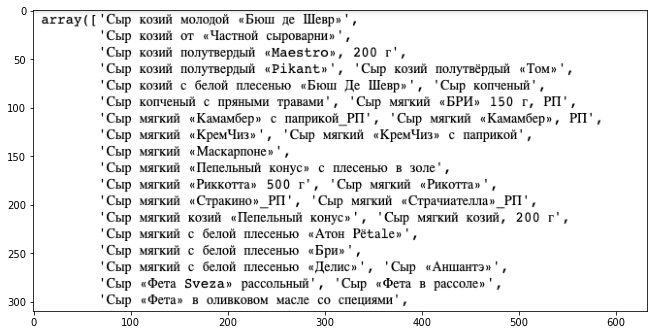

In [501]:
cheese_im = mpimg.imread('../input/cheese_wrong.png')
plt.figure(figsize=(11, 6))
plt.imshow(cheese_im)

### Яйца куриные, 10 шт.

In [107]:
id = 1501
MAE = MAE_df.loc[MAE_df['rosstat_id'] == id, 'MAE'].values[0]
plot_multiple_ts(week_index[week_index['rosstat_id'] == id].cpi_rosstat,
                 week_index[week_index['rosstat_id'] == id].my_cpi,
                 title_text=f'Недельный индекс: Яйца куриные, 10 шт. MAE = {MAE}')

In [282]:
print(len(df_inference[df_inference['pred_category'] == 'Яйца куриные, 10 шт.'].product_name.unique()))
df_inference[df_inference['pred_category'] == 'Яйца куриные, 10 шт.'].product_name.unique()

7


array(['Яйцо домашнее от кур бесклеточного содержания',
       'Яйцо куриное домашнее шт.', 'Яйцо куриное С0',
       'Яйцо куриное С0, 20 шт', 'Яйцо куриное С1',
       'Яйцо куриное С1 белое, 20 шт', 'Яйцо куриное С2'], dtype=object)

In [283]:
print(len(df_inference[df_inference['query_goods'] == 'Яйца куриные, 10 шт.'].product_name.unique()))
df_inference[df_inference['query_goods'] == 'Яйца куриные, 10 шт.'].product_name.unique()

20


array(['Яйцо домашнее от кур бесклеточного содержания',
       'Яйцо куриное домашнее шт.', 'Яйцо куриное С0',
       'Яйцо куриное С0, 20 шт', 'Яйцо куриное С1',
       'Яйцо куриное С1 белое, 20 шт', 'Яйцо куриное С2',
       'Шницель куриный в яйце с картофельным пюре',
       'Яйца Маркет Перекресток куриные С1 20шт',
       'Яйца Роскар Счастливая курица С1 коричневые 10шт',
       'Яйца Роскар Счастливая курица СО коричневые 10шт',
       'Яйца куриные Волжанин С1 10шт', 'Яйца куриные Волжанин С1 30шт',
       'Яйца куриные Волжанин СО 10шт', 'Яйца куриные Волжанин СО 6шт',
       'Яйца куриные Волжанин белые С1 10шт',
       'Яйца куриные Волжанин белые С1 20шт',
       'Яйца куриные Волжанин белые СО 10шт',
       'Филе куриное Вкусные истории жаренное в яйце с Рисом и Овощами 250г',
       'Боул грин Грабли BOX с яйцом запеченной курицей и йогуртовым соусом песто 185г'],
      dtype=object)

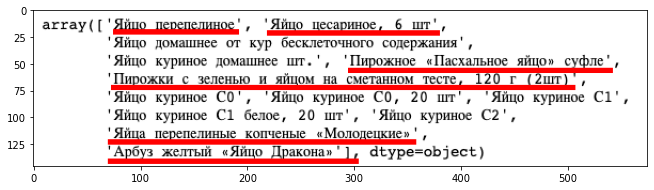

In [500]:
eggs_im = mpimg.imread('../input/eggs_wrong.png')
plt.figure(figsize=(11, 6))
plt.imshow(eggs_im)

### Помидоры свежие, кг

In [108]:
id = 2623
MAE = MAE_df.loc[MAE_df['rosstat_id'] == id, 'MAE'].values[0]
plot_multiple_ts(week_index[week_index['rosstat_id'] == id].cpi_rosstat,
                 week_index[week_index['rosstat_id'] == id].my_cpi,
                 title_text='Недельный индекс: Помидоры свежие, кг')

In [285]:
print(len(df_inference[df_inference['pred_category'] == 'Помидоры свежие, кг'].product_name.unique()))
df_inference[df_inference['pred_category'] == 'Помидоры свежие, кг'].product_name.unique()

116


array(['Томаты вяленые в масле', 'Томаты вяленые в масле, 250 г',
       'Томаты Кумато', 'Томаты Махитос',
       'Томаты Пинк Парадайз Узбекистан',
       'Томаты Пинк Парадайз Узбекистан, 350 г',
       'Томаты Пинк Парадайз отборные, 500 г', 'Томаты вес_РП',
       'Томаты желтые', 'Томаты коктейльные на ветке',
       'Томаты коктейльные розовые, 500 гр', 'Томаты красные',
       'Томаты красные Бакинские', 'Томаты красные Бакинские, 400 г',
       'Томаты красные на ветке', 'Томаты Махитос Азербайджан',
       'Томаты Пинк Парадайз отборные, 350 г', 'Томаты розовые',
       'Томаты розовые Азербайджан', 'Томаты розовые Биф',
       'Томаты розовые Дагестан', 'Томаты розовые Узбекистан, 430 г',
       'Томаты сливка желтые', 'Томаты сливка красные',
       'Томаты сливка розовые, 500 гр', 'Томаты черри Кумато, 250 г',
       'Томаты Бриозо, 500 г', 'Томаты черри розовые, 500 г',
       'Томаты розовые Азербайджан, 600 гр',
       'Томаты розовые Дагестан, 500 гр', 'Томаты сливка р

In [286]:
print(len(df_inference[df_inference['query_goods'] == 'Помидоры свежие, кг'].product_name.unique()))
df_inference[df_inference['query_goods'] == 'Помидоры свежие, кг'].product_name.unique()

80


array(['Томаты Кумато', 'Томаты Махитос',
       'Томаты Пинк Парадайз Узбекистан',
       'Томаты Пинк Парадайз Узбекистан, 350 г',
       'Томаты Пинк Парадайз отборные, 500 г', 'Томаты вес_РП',
       'Томаты желтые', 'Томаты красные', 'Томаты красные Бакинские',
       'Томаты красные Бакинские, 400 г', 'Томаты красные на ветке',
       'Томаты Махитос Азербайджан',
       'Томаты Пинк Парадайз отборные, 350 г', 'Томаты розовые',
       'Томаты розовые Азербайджан', 'Томаты розовые Биф',
       'Томаты розовые Дагестан', 'Томаты розовые Узбекистан, 430 г',
       'Томаты сливка желтые', 'Томаты сливка красные',
       'Томаты сливка розовые, 500 гр', 'Томаты Бриозо, 500 г',
       'Томаты розовые Азербайджан, 600 гр',
       'Томаты розовые Дагестан, 500 гр', 'Томаты сливка розовые',
       'Томаты Кривянские, 500 г', 'Томаты Iposea сушеные в масле 280 г',
       'Томаты розовые Кабардинка, 500 гр', 'Томаты розовые Краснодар',
       'Томаты розовые Краснодар, 500 гр',
       'Тома

In [489]:
set(df_inference[df_inference['pred_category'] == 'Помидоры свежие, кг'] \
    .product_name.unique()) - set(df_inference[df_inference['query_goods'] == 'Помидоры свежие, кг'] \
                            .product_name.unique())

{'Ассорти из Томатов (желтый Махитос, розовый, красный Махитос, кумато), 500 г',
 'Ассорти из Томатов Махитос, 900 г'}

### Недельный индекс общий

In [109]:
MAE = week_gen_index.loc[:, 'difference'].sum() / week_gen_index.loc[:, 'difference'].shape[0]
plot_multiple_ts(week_gen_index.cpi_rosstat,
                 week_gen_index.my_cpi, title_text=f'Недельный индекс общий без квантилей. MAE = {MAE}')

### Кумулятивный индекс

In [110]:
plot_multiple_ts((week_gen_index['cpi_rosstat'] - 100).cumsum(),
                 (week_gen_index['my_cpi'] - 100).cumsum(), title_text='Кумулятивный индекс общий')

### Топ худших и лучших категорий

In [332]:
MAE_df.sort_values(by='MAE').head(5)

,rosstat_id,MAE,rosstat_name
2,114,0.581412,"Куры охлажденные и мороженые, кг"
24,2201,0.630053,Хлеб из ржаной муки и из смеси муки ржаной и п...
13,1124,0.667209,"Творог, кг"
1,113,0.685675,"Свинина (кроме бескостного мяса), кг"
3,116,0.730891,"Баранина (кроме бескостного мяса), кг"


In [333]:
MAE_df.sort_values(by='MAE').tail(5)

,rosstat_id,MAE,rosstat_name
36,2623,3.209971,"Помидоры свежие, кг"
33,2604,3.651472,"Свёкла столовая, кг"
32,2603,4.113530,"Лук репчатый, кг"
31,2601,4.378826,"Капуста белокочанная свежая, кг"
38,2711,5.621236,"Бананы, кг"


In [116]:
id = 2711
MAE = MAE_df.loc[MAE_df['rosstat_id'] == id, 'MAE'].values[0]
plot_multiple_ts(week_index[week_index['rosstat_id'] == id].cpi_rosstat,
                 week_index[week_index['rosstat_id'] == id].my_cpi,
                 title_text='Недельный индекс: Свекла, кг')

## Разметка данных

### Импорт данных

In [3]:
%%time
diksi = pd.read_csv('../input/fmcg_diksi_20220504-112953.csv', sep=';')
diksi.head()

columns = diksi.columns

df = pd.read_csv('../input/food_prices_2022_08.csv', header=None)#, nrows=50000000)
df.columns = columns
df.head()

CPU times: user 3min 59s, sys: 3min 27s, total: 7min 27s
Wall time: 10min 52s


,company_id,download_dt,section,category,subcategory,product_name,price_current,price_old,url_prodinfo,units
0,1,2022-06-07 01:23:00,NaN,Говядина,Говядина,Внешняя часть бедра говяжья без кости свежемор...,819.01,NaN,category/myasnye/myaso/govyadina/vneshnyaya-ch...,Новосибирская обл.
1,1,2022-06-07 01:23:00,NaN,Говядина,Говядина,Говядина без кости Мясоделов глазной мускул ох...,814.0,NaN,category/myasnye/myaso/govyadina/myasodelov-b-...,Новосибирская обл.
2,1,2022-06-07 01:23:00,NaN,Говядина,Говядина,Голяшка Мираторг говяжья для оссо буко заморож...,1199.0,NaN,category/myasnye/myaso/govyadina/golyashka-mir...,Новосибирская обл.
3,1,2022-06-07 01:23:00,NaN,Говядина,Говядина,Голяшка говяжья Б/К Мираторг замороженная,2178.0,NaN,category/myasnye/myaso/govyadina/golyashka-gov...,Новосибирская обл.
4,1,2022-06-07 01:23:00,NaN,Говядина,Говядина,Грудинка говяжья мраморная замороженная ПРАЙМБИФ,7254.0,NaN,category/myasnye/myaso/govyadina/grudinka-govy...,Новосибирская обл.


In [9]:
# df_vkusvill_moscow = df[(df['company_id'] == 4)&(df['units'] == 'Москва и область')]
vkusvill_perek = df[(df['company_id'].isin([4, 8]))&(df['units'] == 'Москва и область')]
vkusvill_perek.to_csv('vkusvill_perek.csv', index=False)

In [5]:
%%time
df1 = pd.DataFrame(columns=['product_name'])
df1['product_name'] = pd.Series(df.product_name.unique()).apply(str)
# df1 = df.drop_duplicates(subset=['product_name'])[['company_id', 'download_dt', 'product_name']]
# df1['product_name'] = df1['product_name'].apply(str)
df1.head()

CPU times: user 19.3 s, sys: 11.9 s, total: 31.1 s
Wall time: 32.2 s


,product_name
0,Внешняя часть бедра говяжья без кости свежемор...
1,Говядина без кости Мясоделов глазной мускул ох...
2,Голяшка Мираторг говяжья для оссо буко заморож...
3,Голяшка говяжья Б/К Мираторг замороженная
4,Грудинка говяжья мраморная замороженная ПРАЙМБИФ


### Разбиение на train/test

In [3]:
# train_df = df1[~df1.query_goods.isnull()].copy()
# train_df = df1[df1['query_goods'] != 'Прочее']

train_df = pd.read_excel('train_df_lem.xlsx')
train_df

,company_id,download_dt,product_name,query_goods,tokens,encoded_tokens
0,1,2022-07-11 03:29:56,"Йогурт Фруате персик и груша 1.5%, 950г БЗМЖ","Йогурт, кг",йогурт фруата персик и груша бзмжа,"[56, 71, 86, 39, 76, 92, 1, 44, 76, 39, 52, 92..."
1,16,2022-07-30 10:11:59,Котлета из индейки натуральная Пава Пава ГВУ 600г,"Мясо индейки, кг",котлета из индейка натуральный пава пава гву,"[72, 71, 92, 58, 33, 92, 52, 1, 36, 16, 1, 36,..."
2,10,2022-01-02 06:57:22,Мед Pchelove Гречишный 1.3 кг,"Мёд пчелиный натуральный, кг",мёд pchelove гречишный,"[41, 48, 61, 1, 9, 3, 17, 8, 90, 1, 85, 8, 1, ..."
3,16,2022-04-30 11:09:06,Шоколад горький Победа 72% какао 250г,"Шоколад, кг",шоколад горький победа какао,"[30, 71, 72, 71, 58, 52, 61, 1, 86, 71, 76, 54..."
4,1,2022-07-12 06:52:59,"Коньяк Айвазовский 3 года, 0,5л","Коньяк ординарный отечественный, л",коньяк айвазовский год,"[72, 71, 63, 54, 74, 72, 1, 52, 56, 53, 52, 16..."
...,...,...,...,...,...,...
86102,8,2022-04-30 00:09:46,Суп Yelli Сибирский с белыми грибами и перловк...,Супы(прочее),суп yelli сибирский с белый гриб и перловка,"[4, 39, 24, 1, 57, 8, 90, 90, 83, 1, 4, 36, 62..."
86103,8,2022-06-07 04:16:07,Кофе в зернах Tchibo Barista Espresso натураль...,"Кофе натуральный в зернах и молотый, кг",кофе в зерно tchibo barista espresso натуральн...,"[72, 71, 44, 33, 1, 53, 1, 16, 33, 76, 63, 71,..."
86104,6,2022-07-10 04:03:38,"Десерт ""Ehrmann"" Grand Dessert пудинг с белым ...",Шоколад(прочее),десерт ehrmann grand dessert пудинг с белый шо...,"[61, 33, 4, 33, 76, 92, 1, 8, 17, 12, 64, 55, ..."
86105,8,2022-06-07 01:10:47,Торт Ресторанная коллекция Трюфельный 1.4кг,"Торты, кг",торт ресторанный коллекция трюфельный,"[92, 71, 76, 92, 1, 76, 33, 4, 92, 71, 76, 52,..."


In [6]:
train_df = train_df.assign(tokens=train_df.product_name.progress_apply(tokenize_text))

d = []
# for senq in train_df[train_df['query_goods'] != 'Прочее'].tokens.values:
for senq in train_df.tokens.values:
    d += senq
    
d = list(set(d))

vocab = dict()
vocab = {d[i]: i for i in range(2, len(d))}
vocab['<Unknown>'] = 1
vocab['<Pad>'] = 0
reverse_vocab = dict([(value, key) for (key, value) in vocab.items()])
reverse_vocab

train_df = train_df.assign(encoded_tokens=train_df.tokens.progress_apply(encode_review))
train_df.head()

100%|█████████████████████████████████| 86107/86107 [00:00<00:00, 176517.88it/s]


,company_id,download_dt,product_name,query_goods,tokens,encoded_tokens
0,1,2022-07-11 03:29:56,"Йогурт Фруате персик и груша 1.5%, 950г БЗМЖ","Йогурт, кг","[йогурт, фруате, персик, и, груша, бзмж]","[21612, 15309, 17244, 20873, 2474, 23459]"
1,16,2022-07-30 10:11:59,Котлета из индейки натуральная Пава Пава ГВУ 600г,"Мясо индейки, кг","[котлета, из, индейки, натуральная, пава, пава...","[12168, 19961, 11396, 21683, 3838, 3838, 10611]"
2,10,2022-01-02 06:57:22,Мед Pchelove Гречишный 1.3 кг,"Мёд пчелиный натуральный, кг","[мед, pchelove, гречишный]","[20375, 12540, 9270]"
3,16,2022-04-30 11:09:06,Шоколад горький Победа 72% какао 250г,"Шоколад, кг","[шоколад, горький, победа, какао]","[15374, 5426, 22108, 20887]"
4,1,2022-07-12 06:52:59,"Коньяк Айвазовский 3 года, 0,5л","Коньяк ординарный отечественный, л","[коньяк, айвазовский, года]","[24370, 22852, 595]"


In [833]:
vocab

{'marini': 2,
 'джованни': 3,
 'розовый': 4,
 'хулиган': 5,
 'гостеприимный': 6,
 'топ': 7,
 'рулетка': 8,
 'карнавал': 9,
 '6-11год': 10,
 'класический': 11,
 'овсяно-миндальный': 12,
 'фругурт': 13,
 'сталковский': 14,
 'banana-crush': 15,
 'миндаль-изя': 16,
 'хотнинский': 17,
 'чер': 18,
 'клеёнка': 19,
 'грибок': 20,
 'тримминг': 21,
 'origami': 22,
 'pennoni': 23,
 'шоколад/трюфель': 24,
 'зинфандель': 25,
 'сыромороженое': 26,
 'свиные-люкс': 27,
 'персик/маракуйя': 28,
 'halloween': 29,
 'фрумб': 30,
 'culture': 31,
 'amapola': 32,
 'prof-press': 33,
 'woseba': 34,
 'a.': 35,
 'шитьё': 36,
 'балк': 37,
 'манго-красная': 38,
 'кувшин': 39,
 'обуховский': 40,
 'фрэнч': 41,
 'д/горячее': 42,
 'массовый': 43,
 'весна': 44,
 'ульянка': 45,
 'olive-pomace': 46,
 'carrot': 47,
 'babushkas': 48,
 'тайско': 49,
 'wet': 50,
 'костивакуумный': 51,
 'лимонадъ': 52,
 'ростбиф': 53,
 'яблоко-изюм': 54,
 'спэниша': 55,
 'клубника-баблгам-чёрный': 56,
 'turmeric': 57,
 'валуйки': 58,
 'senses'

In [938]:
len(vocab)

24668

In [7]:
labels = dict()
labels_to_names = dict()

labels = {train_df.query_goods.unique()[i]: i for i in range(len(train_df.query_goods.unique()))}
labels_to_names = {i: train_df.query_goods.unique()[i] for i in range(len(train_df.query_goods.unique()))}

for k,v in labels.items():
    train_df.loc[train_df['query_goods'] == k, 'label'] = str(v)
    print(k, v)
    
train_df

Йогурт, кг 0
Мясо индейки, кг 1
Мёд пчелиный натуральный, кг 2
Шоколад, кг 3
Коньяк ординарный отечественный, л 4
Пшено, кг 5
Овощи замороженные, кг 6
Колбаса сырокопченая, кг 7
Вино(прочее) 8
Прочее 9
Макаронные изделия из пшеничной муки высшего сорта(прочее) 10
Масло сливочное, кг 11
Колбаса(прочее) 12
Хлеб(прочее) 13
Масло(прочее) 14
Жевательная резинка, упаковка 15
Вода минеральная и питьевая, л 16
Говядина бескостная, кг 17
Картофель, кг 18
Сметана, кг 19
Консервы мясные, кг 20
Булочные изделия сдобные из муки высшего сорта штучные, кг 21
Сосиски, сардельки, кг 22
Масло оливковое, л 23
Шоколад(прочее) 24
Грибы свежие, кг 25
Молоко питьевое цельное пастеризованное 2,5-3,2% жирности, л 26
Куры охлажденные и мороженые, кг 27
Консервы фруктово-ягодные для детского питания, кг 28
Зефир, пастила, кг 29
Овощи натуральные консервированные, маринованные, кг 30
Овсяные хлопья "Геркулес", кг 31
Горох и фасоль(прочее) 32
Сыры сычужные твердые и мягкие, кг 33
Колбаса полукопченая и варено-копч

,company_id,download_dt,product_name,query_goods,tokens,encoded_tokens,label
0,1,2022-07-11 03:29:56,"Йогурт Фруате персик и груша 1.5%, 950г БЗМЖ","Йогурт, кг","[йогурт, фруате, персик, и, груша, бзмж]","[21612, 15309, 17244, 20873, 2474, 23459]",0
1,16,2022-07-30 10:11:59,Котлета из индейки натуральная Пава Пава ГВУ 600г,"Мясо индейки, кг","[котлета, из, индейки, натуральная, пава, пава...","[12168, 19961, 11396, 21683, 3838, 3838, 10611]",1
2,10,2022-01-02 06:57:22,Мед Pchelove Гречишный 1.3 кг,"Мёд пчелиный натуральный, кг","[мед, pchelove, гречишный]","[20375, 12540, 9270]",2
3,16,2022-04-30 11:09:06,Шоколад горький Победа 72% какао 250г,"Шоколад, кг","[шоколад, горький, победа, какао]","[15374, 5426, 22108, 20887]",3
4,1,2022-07-12 06:52:59,"Коньяк Айвазовский 3 года, 0,5л","Коньяк ординарный отечественный, л","[коньяк, айвазовский, года]","[24370, 22852, 595]",4
...,...,...,...,...,...,...,...
86102,8,2022-04-30 00:09:46,Суп Yelli Сибирский с белыми грибами и перловк...,Супы(прочее),"[суп, yelli, сибирский, с, белыми, грибами, и,...","[16357, 24419, 19388, 18248, 4769, 1671, 20873...",35
86103,8,2022-06-07 04:16:07,Кофе в зернах Tchibo Barista Espresso натураль...,"Кофе натуральный в зернах и молотый, кг","[кофе, в, зернах, tchibo, barista, espresso, н...","[15477, 2606, 7689, 7465, 9786, 3445, 10801, 7...",43
86104,6,2022-07-10 04:03:38,"Десерт ""Ehrmann"" Grand Dessert пудинг с белым ...",Шоколад(прочее),"[десерт, ehrmann, grand, dessert, пудинг, с, б...","[8104, 16259, 5962, 18271, 8274, 18248, 8828, ...",24
86105,8,2022-06-07 01:10:47,Торт Ресторанная коллекция Трюфельный 1.4кг,"Торты, кг","[торт, ресторанная, коллекция, трюфельный]","[24078, 18347, 18018, 1125]",51


In [34]:
f = open('vocab.bin', 'wb')
pickle.dump(vocab, f)
f.close()

f = open('reverse_vocab.bin', 'wb')
pickle.dump(reverse_vocab, f)
f.close()

f = open('labels.bin', 'wb')
pickle.dump(labels, f)
f.close()

f = open('labels_to_names.bin', 'wb')
pickle.dump(labels_to_names, f)
f.close()

In [ ]:
df_stores_region.loc[df_stores_region['store_id'] == '4', 'region_id']

In [ ]:
f = open('vocab.bin', 'rb')
dic = pickle.load(f)
print(len(dic))

In [8]:
max_seq_len = train_df.assign(num=train_df.encoded_tokens.apply(len)).num.max()

X = padding(train_df.encoded_tokens, 9)
# X = padding(train_df.tokens, max_seq_len)
y = train_df.label.apply(int)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [941]:
x_train.max()

24667

### 105 (my)

In [7]:
rosstat_id = 105
rosstat_name = 'Фарш мясной, кг'
p_yes = ['фарш'] # MUST INCLUDE
p_no = [
"перец|перч|минтай|семг|сёмг|форел|рыб|треск|оливк|минт|трубоч|фрикадел|кролик|вега|растительного|без мяса|фаршир|фарш(ем|а|у)",
'приправ|пельмен|соев|немясо|растительный'

# etc
# "( (с|со|и|для|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

310


### 106 (my)

In [8]:
rosstat_id = 106
rosstat_name = 'Пельмени, манты, равиоли, кг'
p_yes = ["пельмени|манты|равиоли|хинкали|курз|г(ё|е)дз|дим-сам"] # MUST INCLUDE
p_no = [
"перец|перч|минтай|семг|сёмг|форел|рыб|треск|оливк|минт|трубоч|торт|хлеб|творог|сыр|тунц|краб|кальмар|муксун|манго|сомом",
'масло|тесто|креветк|щук|овощами|грибами|картофел|утк|лосос|кролик|веган|ягодами|пармезаном|моцарел|картош|косули|оленин',
'камбал|осьминог|не пельмени'

# etc
# "( (с|со|и|для|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

936


### 105/106 (other)

In [224]:
rosstat_id = 106
rosstat_name = 'Пельмени, манты, равиоли(прочее)'
p_yes = ["пельмени|манты|равиоли|хинкали|курзе|г(ё|е)дз|дим-сам"] # MUST INCLUDE
p_no = [
    'хлеб'
# "перец|перч|минтай|семг|сёмг|форел|рыб|треск|оливк|минт|трубоч|торт|хлеб|творог|сыр",
# 'масло|тесто'

# etc
# "( (с|со|и|для|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) - set(df1[df1['query_goods'] == 'Пельмени, манты, равиоли, кг']['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

193


### 107 (my)

In [9]:
rosstat_id = 107
rosstat_name = 'Печень говяжья, кг'
p_yes = ['(?=.*печ(е|ё)н)(?=.*(говя(ж|д)))|(?=.*(говя(ж|д))(?=.*печ(е|ё)н))'] # MUST INCLUDE
p_no = [
'чиабатта|котлет|пюре|паштет|риет|каша|оладьи'
# etc
# "( (с|со|и|для|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

26


### 111

In [10]:
rosstat_id = 111
rosstat_name = 'Говядина (кроме бескостного мяса), кг'
p_yes = [
#     'говя','телят',
    '(?=.*(говя|телят))(?=.*(кост|н/к|р(е|ё)бр))'
        ]
p_no = [
"безкост|бескост|б/к|филе|иле|без кост|вырезк",

"пюр|туш|раг|печ|обжар|прян|в/к",
"вар|вял|копч|мрамор|нарезк|гуляш",
"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон|азу",

"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл|шаурм",
"зраз|кебаб|котлет|бризол|тефтел|купат|отбивн|рулет|стрипс|биточ",
"фрикад|хинкал|мант|пельм|шарик|фарш",
"вермишель|паста|ветчин|лапш|поджарк",
"балык|бастурм|суджук",

"заливн|холоде|холодц|голов|студ|почк|субпр|оболоч|сердц|печен|ще|язы|сало",
"снек|набор|суп|бульон|заправка|приправа|кетчуп|соус|кубик|сухар|тартар|чипс",
"джерк|желатин|паштет|приправ|расстегай",
"завтрак|обед|беляш|бешбар|сервел|каша",
"главпродукт|кострец",
"черев|гренк|харчо|бекон|сушён|хаш|ежик|кусок|мускул",

# rosstat
"антрекот|лангет|поджарка|гуляш|бефстроганов|азу|вырезка|медальон|ромштекс|шашлык|духов",
# etc
# "( (с|со|и|для) )",
# "([0-9][0-9](| )г)"
]


# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

92


### 112 (my)

In [11]:
#my
rosstat_id = 112
rosstat_name = 'Говядина бескостная, кг'
p_yes = ['говя','телят']

p_no = [
"на кости|косточка", "каша", "ребр|рёбр", "н/к", "фарш", 
"вар|вял|копч|мрамор|нарезк|рис|томлен|гедз|пицц|веган|купаты",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл|шаурм|стейк|батькин|кутаб",

"хинкал|мант|пельм|шарик|фарш|мрам|плов|булгур|самса|бешбармак|стриплойн|фрикадельк",
"вермишель|паста|ветчин|лапш|чиабат|лагман|блин|беляш|лазанья|суджук|кронидов|желе |кебабчичи|с костью",
"пюр|туш|раг|печ|обжар|прян|в/к|консер|рибай|немясо|пирог|треугольник|котлет|нога|ноги|позы|полба",

"заливн|холоде|холодц|голов|студ|почк|субпр|оболоч|печен|сало|бекон|растител|желатин|паштет|сушён|купаты",
"снек|набор|суп|бульон|заправка|приправа|кетчуп|соус|кубик|сухар|тартар|чипс|харч|борщ|окрошк|картоф|щи|хаш",
'гренк|ежик|балык|бастурм|джерк|свинин|кури|расстегай|гречкой|сервелат|миньон|макарон|овощ|греч|жаркое|маринад ',


# rosstat

# etc
# "( (с|со|и) )",
# "([0-9][0-9](| )г)"
]


# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

540


### 111/112 (other)

In [225]:
#my
rosstat_id = 112
rosstat_name = 'Говядина(прочее)'
p_yes = ['говя','телят', 'стейк']

p_no = [
    'форель|приправа|специи|лосось|зубатк|палтус|сардельк|семг|треск|цыпл|акула|кета'
# "на кости|косточка", "каша", "ребр|рёбр", "н/к", "фарш", 
# "вар|вял|копч|мрамор|нарезк",
# "сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл|шаурм",

# "фрикад|хинкал|мант|пельм|шарик|фарш|мрам",
# "вермишель|паста|ветчин|лапш|поджарк|чиабат",
# "пюр|туш|раг|печ|обжар|прян|в/к|консер",

# "заливн|холоде|холодц|голов|студ|почк|субпр|оболоч|сердц|печен|ще|язы|сало|бекон|растител|желатин|паштет|сушён",
# "снек|набор|суп|бульон|заправка|приправа|кетчуп|соус|кубик|сухар|тартар|чипс|харч|борщ|окрошк|картоф|щи|хаш",
# 'гренк|ежик|балык|бастурм|джерк',


# rosstat

# etc
# "( (с|со|и) )",
# "([0-9][0-9](| )г)"
]


# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'].isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1288


### 113

In [12]:
rosstat_id = 113
rosstat_name = 'Свинина (кроме бескостного мяса), кг'
p_yes = [
#     'свин(и|о|а|ы)',
        '(?=.*(свин(и|о|а|ы)))(?=.*(кост|н/к|р(е|ё)бр|рульк))'
]
p_no = [
"безкост|бескост|б/к|филе|иле|край|без кост|вырезк|приправа ",
# "пюр|туш|раг|печ|обжар|прян|в/к",
"вар|вял|копч|мрамор|нарезк|гуляш|жаркое|рагу|котлета|шашлык",
# "стейк|мякот|тримминг|медальон|шашл",

# "сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл|шаурм",
# "зраз|кебаб|котлет|бризол|тефтел|купат|отбивн|рулет|стрипс|биточ",
# "фрикад|хинкал|мант|пельм|шарик|фарш",
# "вермишель|паста|ветчин|лапш|поджарк|нарезк",
# "балык|бастурм|суджук",

# "бекон|сало|голов|уш|заливн|холоде|холодц|студ|почк|субпр|оболоч|сердц|печен|ще|язы",
# "снек|набор|суп|бульон|заправка|приправа|кетчуп|соус|кубик|сухар|тартар|чипс",
# "джерк|желатин|паштет|приправ",
# "завтрак|обед|ланч|по-",
# "главпродукт",
# "черев|каша",
# # etc
# "( (и) )",
# "( [0-9][0-9](| )г)"
]
'Ребрышки свиные Ближние горки Пряные для запекания охлажденные 0.6-1.0 кг'
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

165


### 114

In [13]:
rosstat_id = 114
rosstat_name = 'Куры охлажденные и мороженые, кг'
p_yes = [r'((^| )кур(и|ы)(.*?))', 'цыпл', 'грудк', 'тушка'] # MUST INCLUDE
p_no = [
"курильс","кукуруз",

"пюр|раг|печ|обжар|прян|в/к",
"вар|вял|копч|мрамор|нарезк|гуляш",

"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл|шаурм",
"зраз|кебаб|котлет|бризол|тефтел|купат|отбивн|рулет|стрипс|биточ|картофел",
"фрикад|хинкал|мант|пельм|шарик|фарш|скумбр|гусь|горбуш|цесарк|минт",
"вермишель|паста|ветчин|лапш|поджарк|нарезк|окорок|кролик|палтус|зубатк|рисом|фасолью|штучка",

"я(и|й)ц|голов|заливн|холоде|холодц|студ|почк|субпр|оболоч|сердц|печен|ще|язы|желудк|гречкой",
"снек|набор|суп|бульон|заправка|приправ|кетчуп|соус|кубик|сухар|тартар|чипс|хрум|корн|мед",
"наггетс|грил|олад|пенне|хамон|томл|мойв|сардин|кальмар|форель|сазан|навага|гуся|мельница|буженина|сэндвич",
"джерк|желатин|паштет|приправ|гиоза|перец|омлет|салат|борщ|хек|судак|окунь|лосось|утиная|говядина",
"веган|растит|кляр|улитк|паниров|пицц|спец|стейк|фрикас|фунчоз|бейгл|блюд|лемонем|тушеный",
"завтрак|обед|ланч|по-|табак|риет|блин|гедз|маринад|прорез|игрушк|дорада|конгрио|сдоба|феттучини",
"главпродукт|утк|куриной|перепел|кармашек|утен|митбол|деликатес|плов|сибас|макрурус|каша|шашлык|стерлядь",
"черев|чахохбил|окороч|терияки|голен|окорочк|бедр|смесь|из курицы|с курицей|индейк|витушка|вятушка|будро",
"щука|кета|утёнка|булгуром|овощами|горошком|бёдр|ног(а|и) |ежик|карп|утиной|сациви|собственном",
"желе|жульен|лапы|с/с|золотой|сырной|кожа |вертушка|осетр|крокеты|нагетсы|палочки|семга|буррито|муксун",
"омуль|картон|байтсы|жюльен"
# etc
# "( (с|со|и|для|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

591


### 115 (my)

In [14]:
rosstat_id = 115
rosstat_name = 'Окорочка куриные, кг'
p_yes = [r'((^| )кур(и|ы)(.*?))', 'окороч', 'б(у|е|ё)др', 'голен|ног(а|и) |лап(а|ы) '] # MUST INCLUDE
p_no = [
"курильс","кукуруз",
# "охлажд|морож",
"пюр|туш|раг|печ|обжар|прян|в/к",
"вар|вял|копч|мрамор|нарезк|гуляш",

"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл|шаурм|ежи",
"зраз|кебаб|котлет|бризол|тефтел|купат|отбивн|рулет|стрипс|биточ",
"фрикад|хинкал|мант|пельм|шарик|фарш",
"вермишель|паста|ветчин|лапш|поджарк|нарезк|говя(д|ж)",

"я(и|й)ц|голов|уш|заливн|холоде|холодц|студ|почк|субпр|оболоч|сердц|печен|ще|язы|желудк",
"снек|набор|суп|бульон|заправка|приправ|кетчуп|соус|кубик|сухар|тартар|чипс|хрум|корн",
"наггетс|грил|олад|теляч|барашк|собственном|angus|молоко |специи|желе|ж(у|ю)льен",
"джерк|желатин|паштет|приправ|пирог|томлён|гиоза|каша|перец|сырной|курицей|фрикасе|мельница",
"веган|растит|борщ|жюльен|запеканка|салат|гедз|маринад|сухой|пирож|панировка|слойка|пицца|греч|специя",
"завтрак|обед|ланч|по-|индейк|стейк|кролик|ягнен|осьминог|буженин|сэндвич|перепел|свиные",
"главпродукт|блин|беф|щи|чиаб|пекар|кафе|лазан|панин|пенне|плов|кармаш|ризот|улит|митбол|риет|блюдо",
"черев|грудк|крыл|шашл|фил|терияк|косточке|чахохбил|смесь|сердечк|медальоны|шеи|ут|лап|желуд|масса",
"минога|крокеты|нагетсы|цыпленок-бройлер |буррито"
# etc
# "( (с|со|и|для|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

366


### 116

In [15]:
rosstat_id = 116
rosstat_name = 'Баранина (кроме бескостного мяса), кг'
p_yes = ['(?=.*(баран[^к]))(?=.*(кост|н/к|р(е|ё)бр))']
p_no = [
"безкост|бескост|б/к|филе|иле|край|без кост|вырезк",
"пюр|туш|раг|печ|обжар|прян|в/к",
"вар|вял|копч|мрамор|нарезк|гуляш|жаркое|азу",
"стейк|мякот|тримминг|медальон|шашл",

"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл|шаурм",
"зраз|кебаб|котлет|бризол|тефтел|купат|отбивн|рулет|стрипс|биточ",
"фрикад|хинкал|мант|пельм|шарик|фарш",
"вермишель|паста|ветчин|лапш|поджарк|нарезк",
"балык|бастурм|суджук",

"бекон|сало|курдю|голов|уш|заливн|холоде|холодц|студ|почк|субпр|оболоч|сердц|печен|ще|язы",
"снек|набор|суп|бульон|заправка|приправа|кетчуп|соус|кубик|сухар|тартар|чипс",
"джерк|желатин|паштет|приправ",
"завтрак|обед|ланч|по-",
"главпродукт|люля|жир|плов",
"черев",
# etc
# "( (с|со|и) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

58


### 116 (other)

In [226]:
rosstat_id = 116
rosstat_name = 'Баранина(прочее)'
p_yes = ['баран[^к]']
p_no = [
# "безкост|бескост|б/к|филе|иле|край|без кост|вырезк",
# "пюр|туш|раг|печ|обжар|прян|в/к",
# "вар|вял|копч|мрамор|нарезк|гуляш|жаркое|азу",
# "стейк|мякот|тримминг|медальон|шашл",

# "сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл|шаурм",
# "зраз|кебаб|котлет|бризол|тефтел|купат|отбивн|рулет|стрипс|биточ",
# "фрикад|хинкал|мант|пельм|шарик|фарш",
# "вермишель|паста|ветчин|лапш|поджарк|нарезк",
# "балык|бастурм|суджук",

# # "бекон|сало|курдю|голов|уш|заливн|холоде|холодц|студ|почк|субпр|оболоч|сердц|печен|ще|язы",
# "снек|набор|суп|бульон|заправка|приправа|кетчуп|соус|кубик|сухар|тартар|чипс",
# "джерк|желатин|паштет|приправ",
# "завтрак|обед|ланч|по-",
# "главпродукт|люля|жир",
# "черев",
# etc
# "( (с|со|и|для|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'].isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

119


### 117 (my)

In [16]:
rosstat_id = 117
rosstat_name = 'Свинина бескостная, кг'
p_yes = ['свин(и|о|а|ы)']
p_no = [
# "безкост|бескост|б/к|филе|иле|край|без кост|вырезк",
"пюр|туш|раг|печ|обжар|прян|в/к",
"ребр|рёбр|на кост|н/к|ножк|рульк|мясные кости|свиные кости",
"вар|вял|копч|мрамор|нарезк|гуляш|жаркое",
# "стейк|мякот|тримминг|медальон|шашл",

"сардельк|колбас|сосис|шпик|бургер|чебу|чевап|ролл|шаурм",
"зраз|кебаб|бризол|тефтел|купат|отбивн|рулет|стрипс|биточ",
"хинкал|мант|пельм|шарик|фарш",
"вермишель|паста|ветчин|лапш|нарезк",
"балык|бастурм|суджук",

"бекон|сало|голов|уш|заливн|холоде|холодц|студ|почк|субпр|оболоч|сердц|запечен|ще|язы",
"снек|набор|суп|бульон|заправка|приправа|кетчуп|соус|кубик|сухар|тартар|чипс",
"джерк|желатин|паштет|приправ|котлет|капуст|плов|бефстроганов|ежик",
"завтрак|обед|ланч|по-|смесь|хамон|специи|сырокопч|гренк|борщ|щи",
"главпродукт|карбонад|буженин|снэк|прошутто|маринад |фрикадел|котлет|петрен",
"черев|беляш|поркетта|бульмен|вялен|равиол|бельмеш|каша|пирожк|ноги|желе|купаты",
# etc
# "( (с|со|и) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

436


### 113/117 (other)

In [227]:
rosstat_id = 117
rosstat_name = 'Свинина(прочее)'
p_yes = ['свин(и|о|а|ы)']
p_no = [
# "безкост|бескост|б/к|филе|иле|край|без кост|вырезк",
# "пюр|туш|раг|печ|обжар|прян|в/к",
# "ребр|рёбр|на кост|н/к|ножк|рульк|мясные кости|свиные кости",
# # "вар|вял|копч|мрамор|нарезк|гуляш|жаркое",
# # "стейк|мякот|тримминг|медальон|шашл",

# "сардельк|колбас|сосис|шпик|бургер|чебу|чевап|ролл|шаурм",
# "зраз|кебаб|котлет|бризол|тефтел|купат|отбивн|рулет|стрипс|биточ",
# "фрикад|хинкал|мант|пельм|шарик|фарш",
# "вермишель|паста|ветчин|лапш|нарезк",
# "балык|бастурм|суджук",

# "бекон|сало|голов|уш|заливн|холоде|холодц|студ|почк|субпр|оболоч|сердц|печен|ще|язы",
# "снек|набор|суп|бульон|заправка|приправа|кетчуп|соус|кубик|сухар|тартар|чипс",
# "джерк|желатин|паштет|приправ",
# "завтрак|обед|ланч|по-|смесь|хамон|специи|сырокопч",
# "главпродукт|карбонад|буженин|снэк|прошутто",
# "черев",
# # etc
# "( (с|со|и) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

668


### 119 (my)

In [17]:
rosstat_id = 119
rosstat_name = 'Мясо индейки, кг'
p_yes = ['индейк'] # MUST INCLUDE
p_no = [
"перец|перч|минтай|семг|сёмг|форел|рыб|треск|оливк|минт|трубо|фарш|заливн|долм|бекон",
"рулет|карпач|колбас|пашт|пюр|сард|сосиск|пельмен|ветчин|сервел|бужен|пастром|бульон",
'туш|снек|кнут|риет|пате|джерк|приправ|маринад |maggi|холодец|фрикадел|рис',
"бефстрог|биточк|чиабат|ежик|котлет|азу|крем|пудинг|салат|сэндвич|гречкой|паст(а|ой)|томл(е|ё)н|киш|тефтел",
"суш(е|ё)н|маришаль|копч(е|ё)н|греч|бейгл|собственн|чипс|наггетс|блюдо|травы|митбол",
"кураг|тортелл|отварное|гуляш|вялен|крокет|шарик|борщ|овощами|гушт|хлеб|штучка|перцем|тандур",
"блин|зраз|г(е|ё)дз|каша|смесь |нут|студень|сендвич|суп |вареник|чевапчичи|панини|фарфалле|круассан|артишок|злак|купаты"
# etc
# "( (с|со) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

498


### 201

In [18]:
rosstat_id = 201
rosstat_name = 'Колбаса вареная, кг'
p_yes = [
'(?=.*колбас)(?=.*(вареная|варёная|вар |докторская|любительская))',
'(?=.*(вареная|варёная|вар |вар.|докторская|любительская))(?=.*колбас)',
]
p_no = [
"серве|сарвела|вар(е|ё)но-|полукопч|сырокопч|охотн|с/к|сальчи|колбаск|сосиск",
"салям|в/к|п/к|нарезка|жареная|запеч|копч|кров|ливер|вакуум|ветчин|баварские",
"веган|растит",
"сыр"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1623


### 202

In [19]:
rosstat_id = 202
rosstat_name = 'Сосиски, сардельки, кг'
p_yes = ['(^|( |^с ))(сосиски|сардельки|шпикачки|купаты)']
p_no = ["приправ|смесь|соус|тест|дог|кетчуп",
"веган|растит|копч",
"завтрак|обед|ланч|готов",
"вял|туш|раг|печ|обжар|пирож|булоч|набор|слойка"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

2113


### 204

In [20]:
rosstat_id = 204
rosstat_name = 'Колбаса полукопченая и варено-копченая, кг'
p_yes = [
    '(?=.*колбас)(?=.*(с(а|е)рвела|вар(е|ё)но-|варёно-|полукопч|п/к|в/к))',
    '(?=.*(с(а|е)рвела|вар(е|ё)но-|варёно-|полукопч|п/к|в/к))(?=.*колбас)'
] 
p_no = [
"сырокопч|охотн|вар(е|ё)ная|с/к|сальчи|колбаск",
"докторская|любит|карбонад|ветчин",
"нарезк|вакуум|голен|сыр|бедро",
"веган|растит|грудка|грудинка|лопатка|птица",
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1406


### 205 (my)

In [21]:
rosstat_id = 205
rosstat_name = 'Колбаса сырокопченая, кг'
p_yes = [
    '(?=.*колбас)(?=.*(с/к|сыро|сух|полусух))',
    '(?=.*(с/к|сыро|сух|полусух))(?=.*колбас)',
    'салям|советск|зернист|столич|брауншвейг|суджук|сальчич'
] 
p_no = [
"икра|сухар|сахар|хлеб|пельм|кекс|грудин|горчиц|рис|котлет|пицц|конфет|шампанск|водка",
"вар|докторская|любит|карбонад|ветчин|в/к|полукопч|жар|охлажд|заморож|п/к|студень|бекон",
"нарезк|вакуум|голен|сосиск|холодец|мороженое|батон|творог|булоч|фарш|квас|снек|салат",
"веган|растит|коньяк|сыровял|сыр |сырок |сельд|колбаск|нуга|шейка|окорок|сардельк|плавленый|милано",
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1166


### 201/204/205 (other)

In [228]:
rosstat_id = 205
rosstat_name = 'Колбаса(прочее)'
p_yes = [
    'колбас'
] 
p_no = [
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'].isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

2036


### 208 (my)

In [22]:
rosstat_id = 208
rosstat_name = 'Мясокопчености, кг'
p_yes = [
    '(?=.*(свин|гов|баран|кур|рул|окорок|корей|бек|карбон|бужен|шейк|ветч|груд|мясо))(?=.*(копч|запеч|вар|жар|прес))',
    '(?=.*(копч|вар|запеч|жар|прес))(?=.*(свин|гов|баран|кур|рул|окорок|корей|бек|карбон|бужен|шейк|ветч|груд|мясо))'
] 
p_no = [
# "сырокопч|охотн|вар(е|ё)ная|с/к|сальчи|колбаск|салям",
"докторская|любит|в/к|полукопч|жар|охлажд|заморож|п/к|сосиск|игрушк|каша|фетуч|курага|лапша",
"нарезк|вакуум|голен|сыр|чипс|сухар|рулет|кукл|краб|поваренная|фарш|суп|яйц|соус|смесь|хлеб",
"веган|растит|паприка|приправ|соус|говядиной|говяжьей|колбас|беф|миди|кукуруз|паштет|масло|прошут|рагу",
"салат|с(э|е)ндвич|феттучини|пельмен|котлет|биточк|icancook|креветк|сардел|сосиск|пряник|шпикачк|вареник|рис"
# "( (с|со|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

764


### 208 (other)

In [229]:
rosstat_id = 208
rosstat_name = 'Мясокопчености(прочее)'
p_yes = [
    '(?=.*(свин|гов|баран|кур|рул|окорок|корей|бек|карбон|бужен|шейк|ветч|груд|мясо))(?=.*(копч|запеч|вар|жар|прес))',
    '(?=.*(копч|вар|запеч|жар|прес))(?=.*(свин|гов|баран|кур|рул|окорок|корей|бек|карбон|бужен|шейк|ветч|груд|мясо))'
] 
p_no = [
# "сырокопч|охотн|вар(е|ё)ная|с/к|сальчи|колбаск|салям",
# "докторская|любит|в/к|полукопч|жар|охлажд|заморож|п/к|сосиск|игрушк|каша|фетуч|курага|лапша",
# "нарезк|голен|сыр|чипс|сухар|рулет|кукл|краб|поваренная|фарш|суп|яйц|соус|смесь|хлеб",
# "веган|растит|паприка|приправ|соус|говядиной|говяжьей|колбас|беф|миди|кукуруз|паштет|масло|прошут|рагу",
# "( (с|со|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'].isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

570


### 209 (my)

In [23]:
rosstat_id = 209
rosstat_name = 'Кулинарные изделия из птицы, кг'
p_yes = [
    '(?=.*(кур|цыпл|утк|гус|инд))(?=.*(вар|копч|жар|запеч|грил|полукопч))',
    '(?=.*(вар|копч|жар|запеч|грил|полукопч))(?=.*(кур|цыпл|утк|гус|инд))'
] 
p_no = [
# "сырокопч|охотн|вар(е|ё)ная|с/к|сальчи|колбаск|салям",
"вар|докторская|любит|в/к|охлажд|заморож|п/к|сосиск|смесь|феттучини|пирожок",
"нарезк|вакуум|голен|сыр|чипс|сухар|кукуруз|капуста|паста|игрушка|блин|боул",
"веган|растит|приправ|колбас|орех|минд|икр|маринад|салат|салям|сервел|суп|пюр|котлет",
# "( (с|со|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

72


### 302

In [24]:
rosstat_id = 302
rosstat_name = 'Консервы мясные для детского питания, кг'
p_yes = [
'(?=.*пюре)(?=.*(индейк|говяд|мяс|телят|кур(о|и)|крол|баран|ягн))',
'(?=.*(индейк|говяд|мяс|телят|кур(о|и)|крол|баран|ягн))(?=.*пюре)'
] 
p_no = [
"карто|капуст|овощ|рис|каш",
"суп|бульон", 
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл|шаурм",
"зраз|кебаб|котлет|бризол|тефтел|купат|отбивн|рулет|стрипс|биточ",
"фрикад|хинкал|мант|пельм|шарик|фарш|грудк|рагу",
# etc
# "( (с|со) )"
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

127


### 303 (my)

In [25]:
rosstat_id = 303
rosstat_name = 'Консервы мясные, кг'
p_yes = [
"туш"
] 
p_no = [
"карто|капуст|овощ|рис|каш|макарон|конфет|игрушк|набор|заморож|соус|наггет|лазан|шашлык|крол|рагу|хлеб|части|ассорти|перепел|охлажд",
"суп|бульон|тушка|лапша|потрошки|гречка|ветчина|филе|изделия|тушения|куриные", 
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл|шаурм|водка|настойка",
"зраз|кебаб|котлет|бризол|тефтел|купат|отбивн|рулет|стрипс|биточ|чахохбили",
"фрикад|хинкал|мант|пельм|шарик|фарш|грудк|салат|вафл|смесь|панировке|крылышки|цыпл",
# etc
# "( (с|со) )"
]
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

477


### 401 (my)

In [26]:
rosstat_id = 401
rosstat_name = 'Рыба живая и охлажденная, кг'
p_yes = [#r'((рыб|хек|барабульк|минтай|горбуш|палтус|пикша|путассу|хек|тунец|дорад|камбал|кижуч|сибас|тунец|терпуг|нерк|наваг|ряпушк|треск)(.*?)морож(.*?))|((.*?)морож(.*?)(рыб|хек|барабульк|минтай|горбуш|палтус|пикша|путассу|хек|тунец|дорад|камбал|кижуч|сибас|тунец|терпуг|нерк|наваг|ряпушк|треск)(.*?))'
r'((.*?)(рыб|окун|треск|хек|карп|толстолоб|судак|амур|камбал|минтай|тилапия|сазан|мойв)(.*?)(жив|охлажд)(.*?))'
] # MUST INCLUDE
p_no = [
"медал|потрош|форел|лосос|семг|сёмг|осетр|осётр|белуг|севр|нельм|муксун|сиг|игра|суп|котлет|карпаччо",

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

73


### 403 (my)

In [27]:
rosstat_id = 403
rosstat_name = 'Рыба охлажденная и мороженая разделанная лососевых пород, кг'
p_yes = [
r'((.*?)(форел|лосос|семг|сёмг|кет|кижуч|нерк|нельм)(.*?)(морож|охлажд)(.*?))'
] # MUST INCLUDE
p_no = [
"стейк|безкост|бескост|б/к|филе|иле|безкост|панировк|треугольник|мини-киш|палочки|порции|кнели|фрикадельк",
"медал|осетр|осётр|белуг|севр|нельм|муксун|сиг|игра|суп|горбуш|сом|щук|пикш|окун|цыпл|котл|шаш|сибас|сазан|карп|грудинк|тушк",
'капуст|картофель|смесь|опята|шампиньоны|маркет|овощ|пельмен|пирог|пирож|колбас|пицца|индейк|торт|блин',
"перепеч"

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

131


### 404 (my)

In [28]:
rosstat_id = 404
rosstat_name = 'Филе рыбное, кг'
p_yes = [#r'((рыб|хек|барабульк|минтай|горбуш|палтус|пикша|путассу|хек|тунец|дорад|камбал|кижуч|сибас|тунец|терпуг|нерк|наваг|ряпушк|треск)(.*?)морож(.*?))|((.*?)морож(.*?)(рыб|хек|барабульк|минтай|горбуш|палтус|пикша|путассу|хек|тунец|дорад|камбал|кижуч|сибас|тунец|терпуг|нерк|наваг|ряпушк|треск)(.*?))'
r'((.*?)(рыб|окун|треск|хек|карп|толстолоб|судак|амур|камбал|минтай|тилапия|мойв)(.*?)(фил)(.*?))'
] # MUST INCLUDE
p_no = [
# "стейк|безкост|бескост|б/к|филе|иле|безкост",
# "икр",
"медал|потрош|форел|лосос|семг|сёмг|осетр|осётр|белуг|севр|нельм|муксун|сиг|игра|суп|нагг|вял|копч|бургер|палоч|добро|суш|набор|х/к",
"кляр|котлет|картофел|ломтики|соус|приправ|паниров|масле"
# "бзмж|креветк|мороженое|багет|котлет|бургер|овощ|фрукт|ягод|гриб|горож",
# "клубник|вишн|малин|осьм|яблок|бекон|бедро|блин|раздела|биф",
# "капуст|краб|суп|картоф|кальм|торт|миди|тест|пицца|смесь|тушк|улитк",
# "наггетс|пирожн|пирог|пюре|фарш|палочк|пирожн|фасол|мороженое",

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

212


### 405 (my)

In [29]:
rosstat_id = 405
rosstat_name = 'Рыба соленая, маринованная, копченая, кг'
p_yes = [#r'((рыб|хек|барабульк|минтай|горбуш|палтус|пикша|путассу|хек|тунец|дорад|камбал|кижуч|сибас|тунец|терпуг|нерк|наваг|ряпушк|треск)(.*?)морож(.*?))|((.*?)морож(.*?)(рыб|хек|барабульк|минтай|горбуш|палтус|пикша|путассу|хек|тунец|дорад|камбал|кижуч|сибас|тунец|терпуг|нерк|наваг|ряпушк|треск)(.*?))'
r'((.*?)(рыб|окун|треск|хек|карп|толстолоб|судак|амур|камбал|минтай|тилапия|салака|сайра|мойв|горбуш)(.*?)(сол|марин|копч|х/к|г/к)(.*?))'
] # MUST INCLUDE
p_no = [
"медал|потрош|форел|лосос|семг|сёмг|осетр|осётр|белуг|севр|нельм|муксун|сиг|игра|суп",
"икра|карпач|масле|соломк|икорк|огур|чипсы|пирог|печень|салат"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

251


### 409 (my)

In [30]:
rosstat_id = 409
rosstat_name = 'Рыба мороженая разделанная (кроме лососевых пород), кг'
p_yes = [#r'((рыб|хек|барабульк|минтай|горбуш|палтус|пикша|путассу|хек|тунец|дорад|камбал|кижуч|сибас|тунец|терпуг|нерк|наваг|ряпушк|треск)(.*?)морож(.*?))|((.*?)морож(.*?)(рыб|хек|барабульк|минтай|горбуш|палтус|пикша|путассу|хек|тунец|дорад|камбал|кижуч|сибас|тунец|терпуг|нерк|наваг|ряпушк|треск)(.*?))'
r'((.*?)(рыб|потрош|окун|треск|хек|карп|толстолоб|судак|амур|камбал|минтай|тилапия|мойв)(.*?)(морож)(.*?))'
] # MUST INCLUDE
p_no = [
"стейк|безкост|бескост|б/к|филе|иле|безкост|пирог|пельмен",
"форел|лосос|семг|сёмг|кет|кижуч|нерк|нельм|нераздел",
"медал|осетр|осётр|белуг|севр|нельм|муксун|сиг|игра|суп|горбуш|сом|щук|пикш|цыпл|котл|шаш|сибас|сазан|грудинк|тушк",
'коктейл|ледяная|мидии|непотрош|блин|палочк|треугол|креветк|карпач|зраз|паниров'

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

57


### 411

In [31]:
rosstat_id = 411
rosstat_name = 'Рыба мороженая неразделанная, кг'
p_yes = [#'(?=.*морож)(?=.*(рыб|хек|барабульк|минтай|горбуш|палтус|пикша|путассу|хек|тунец|дорад|камбал|кижуч|сибас|тунец|терпуг|нерк|наваг|ряпушк|треск))',
         r'((рыб|хек|барабульк|минтай|горбуш|палтус|пикша|путассу|хек|тунец|дорад|камбал|кижуч|сибас|тунец|терпуг|нерк|наваг|ряпушк|треск)(.*?)морож(.*?))|((.*?)морож(.*?)(рыб|хек|барабульк|минтай|горбуш|палтус|пикша|путассу|хек|тунец|дорад|камбал|кижуч|сибас|тунец|терпуг|нерк|наваг|ряпушк|треск)(.*?))'
] # MUST INCLUDE
p_no = [
"стейк|безкост|бескост|б/к|филе|иле|безкост",
"икр|кнели|гарниром|крокет|панировк",
"медал|потрош|форел|лосос|семг|сёмг|осетр|осётр|белуг|севр|нельм|муксун|сиг",
"бзмж|креветк|мороженое|багет|котлет|бургер|овощ|фрукт|ягод|гриб|горож",
"клубник|вишн|малин|осьм|яблок|бекон|бедро|блин|раздела|биф|коктейл|треугольник",
"капуст|краб|суп|картоф|кальм|торт|миди|тест|пицца|смесь|тушк|улитк",
"наггетс|пирожн|пирог|пюре|фарш|палочк|пирожн|фасол|мороженое|зраз|пирож|рулет|пельмен",

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

50


### 412 (my)

In [32]:
rosstat_id = 412
rosstat_name = 'Икра лососевых рыб, отечественная, кг'
p_yes = [r'((.*?)(икра)(.*?)(форел|лосос|семг|сёмг|кет|кижуч|нерк|нельм|горбуш)(.*?))',
         r'((.*?)(форел|лосос|семг|сёмг|кет|кижуч|нерк|нельм|горбуш)(.*?)(икра)(.*?))'
] # MUST INCLUDE
p_no = [
"печен",
# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

273


### 413 (my)

In [33]:
rosstat_id = 413
rosstat_name = 'Соленые и копченые деликатесные продукты из рыбы, кг'
p_yes = [
r'((.*?)(осетр|осётр|севрюг|белуг|стерляд|нельм|муксун|омул|сиг|лосос|форел|семг|сёмг|кет|кижуч|нерк|щук|язь|корюшк)(.*?)(сол(е|ё)н|копч(е|ё)|вял)(.*?))',
    r'((.*?)(сол|копч|вял)(.*?)(осетр|осётр|севрюг|белуг|стерляд|нельм|муксун|омул|сиг|лосос|форел|семг|сёмг|кет|кижуч|нерк|щук|язь|корюшк)(.*?))'
] # MUST INCLUDE
p_no = [
"медал|потрош|игра|суп|горбуш|сельд|икр|огурц|гриб|попкорн|томат|овощ|перец|чеснок|черемш|паштет|кетчуп",
'соль|колбаса|мимоза|сервелат|маслин|брускетта|креветк|сыр|опята|солянка|соусе|колбаски|соус |пицца|чипсы',

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

584


### 414 (my)

In [34]:
rosstat_id = 414
rosstat_name = 'Креветки мороженые неразделанные, кг'
p_yes = ["креветк"
] # MUST INCLUDE
p_no = [
"медал|потрош|игра|суп|горбуш|сельд|икр|огурц|гриб|попкорн|томат|овощ|перец|чеснок|черемш|паштет|кетчуп",
"тигр|раздел|рассол|лангуст|очищ|голов|сухар|шашл|чипс|пельм|паст|сыр|крем|лапш|жар|шпаж",
"салат|ролл|сэндвич|вок|оливки|рис|г(е|ё)дза|паниров|дамплинг|равиол|кальмар|арахис|коктейл|соус|масл",
"котлет|фасол|бобы|ассорти|заливк|лосось|палочки|боул|поке"

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

113


### 415 (my)

In [35]:
rosstat_id = 415
rosstat_name = 'Кальмары мороженые, кг'
p_yes = ["кальмар"
] # MUST INCLUDE
p_no = [
"суш|кольц|стружк|копч|вял|крок|коктейл|соломк|полоск|крем|салат|сухар|шашл|колбас",
"котлет|зраз|наггетс|пельмен|заливк|гриль|рассол|паста|масле|морковь|берег|треугольн|икра",
"мидии|гёдз|краб|майонез|соус|желе|специям|креветк|панировк|перепече|смесь|палочк",
"солянк|фунчоз|гедз"

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

92


### 501 (my)

In [36]:
rosstat_id = 501
rosstat_name = 'Сельдь соленая, кг'
p_yes = [
r'((.*?)(сельд)(.*?)(сол|марин|копч)(.*?))'
] # MUST INCLUDE
p_no = [
"медал|потрош|форел|лосос|семг|сёмг|осетр|осётр|белуг|севр|нельм|муксун|сиг|игра|суп|фил|икр",
"картоф|огурц|помидор"

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

81


### 502 (my)

In [37]:
rosstat_id = 502
rosstat_name = 'Филе сельди соленое, кг'
p_yes = [
r'((.*?)(сельд|селёд)(.*?)(фил)(.*?)(сол|марин|копч)(.*?))|((фил)(.*?)(сельд|селёд)(.*?))'
] # MUST INCLUDE
p_no = [
"медал|потрош|форел|лосос|семг|сёмг|осетр|осётр|белуг|севр|нельм|муксун|сиг|игра|суп|икр",
"вялен"

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

70


### 604 (my)

In [38]:
rosstat_id = 604
rosstat_name = 'Консервы рыбные натуральные и с добавлением масла, кг'
p_yes = [
r'((.*?)(консерв|в масл|печень)(.*?)(треск|тун|минт|скумбр|налим|шпрот|сайр|сардин|макрел|горбуш|анчоус)(.*?))|((треск|тун|минт|скумбр|налим|шпрот|сайр|сардин|макрел|горбуш|анчоус)(.*?)(консерв|в масл|печень)(.*?))',
    'шпрот|кильк|сардин|анчоус'
] # MUST INCLUDE
p_no = [
"стейк|безкост|бескост|б/к|филе|иле|безкост|икр|вино|тофу|соус |арахис|сушен",
"форел|лосос|семг|сёмг|кет|кижуч|нерк|нельм|нераздел|анчоусами|оливки",
"медал|осетр|осётр|белуг|севр|нельм|муксун|сиг|игра|суп|сом|щук|пикш|цыпл|котл|шаш|сибас|сазан|грудинк|тушк|томат|паштет",

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

436


### 605 (my)

In [39]:
rosstat_id = 605
rosstat_name = 'Консервы рыбные в томатном соусе, кг'
p_yes = [
r'((.*?)(томат)(.*?)(треск|тун|минт|скумбр|налим|шпрот|сайр|сардин|макрел|горбуш|кильк|кеф|бычк|анчоус)(.*?))|((треск|тун|минт|скумбр|налим|шпрот|сайр|сардин|макрел|горбуш|кильк|кеф|бычк|анчоус)(.*?)(томат)(.*?))'
] # MUST INCLUDE
p_no = [
"стейк|безкост|бескост|б/к|филе|иле|безкост|икр|риет|гренки",
"форел|лосос|семг|сёмг|кет|кижуч|нерк|нельм|нераздел|томатами",
"медал|осетр|осётр|белуг|севр|нельм|муксун|сиг|игра|суп|сом|щук|пикш|цыпл|котл|шаш|сибас|сазан|грудинк|тушк",

# etc
# "( (с|со|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

170


### 701

In [40]:
rosstat_id = 701
rosstat_name = 'Масло сливочное, кг'
p_yes = [r'((.*?)масло(.*?)(слив|крест)(.*?))|((.*?)(слив|крест)(.*?)масло(.*?))']# MUST INCLUDE
p_no = [
    "шокол|фрукт|ягод|рыб|сел(ё|е)д|корн|пельмен|маслом|масле|набор",
    # etc
# "( (с|со|и|для|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

656


### 802 (my)

In [41]:
rosstat_id = 802
rosstat_name = 'Масло оливковое, л'
p_yes = [r'((.*?)масло(.*?)олив(.*?))|((.*?)олив(.*?)масло(.*?))']# MUST INCLUDE
p_no = [
    "шокол|фрукт|ягод|рыб|сел(ё|е)д|корн|пряност|чипс|розмарин|уксус|шампунь|перчик",
    'набор|мыло|крем|оливковым|подсолнеч|песто|лимон|базилик|трюфел|чеснок|коктейль',
    "добавле|оливками|томат|оливки|ароматизир|перцем|имбир|апельсин|пирог|орегано|чили|вкусом|ароматом"
    # etc
# "( (с|со|и|для|в) )",
# "( [0-9][0-9](| )г)"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1006


### 803

In [42]:
rosstat_id = 803
rosstat_name = 'Масло подсолнечное, л'
p_yes = ['((.*?)масло(.*?)подсолн(.*?))|((.*?)подсолн(.*?)масло(.*?))'] 
p_no = ["чеснок|перец|перц|смес|оливк|чесноч|кунжутн|чили|томат",
        '(((.*?) с (.*?))|((.*?) со (.*?)))|((.*?) [12][0-9][0-9]г(.*?))',
#         '((.*?) [12][0-9][0-9] г(.*?))|((.*?) [12][0-9][0-9]мл(.*?))|((.*?) [12][0-9][0-9] мл(.*?))'
       ] # MUST NOT INCLUDE

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

243


### 803 (other)

In [230]:
rosstat_id = 803
rosstat_name = 'Масло(прочее)'
p_yes = ['масло '] 
p_no = [
#     "чеснок|перец|перц|смес",
#         '(((.*?) с (.*?))|((.*?) со (.*?)))|((.*?) [12][0-9][0-9]г(.*?))',
#         '((.*?) [12][0-9][0-9] г(.*?))|((.*?) [12][0-9][0-9]мл(.*?))|((.*?) [12][0-9][0-9] мл(.*?))'
       ] # MUST NOT INCLUDE

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1453


### 1001

In [43]:
rosstat_id = 1001
rosstat_name = 'Маргарин, кг'
p_yes = [r'((.*?)маргарин(.*?))|((.*?)спред(.*?))']
p_no = ["чеснок|перец|перц|смес",
# '( (с|со) )',
# '( [0-9][0-9](| )г)'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

77


### 1102

In [44]:
rosstat_id = 1102
rosstat_name = 'Сметана, кг'
p_yes = ['((?=.*сметана)(?=.*(.*?)(1[56789]|20)(.*?)))'] # MUST INCLUDE
p_no = ["веган|растит|напиток|набор|с замен",'шт|по',
    "чипс|сухар|соус |гренк|луковые|травами|30%|25%",
#     '( (с|со) )',
#     '( [0-9][0-9](| )(г|мл))'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

939


### 1103 (my)

In [45]:
rosstat_id = 1103
rosstat_name = 'Кисломолочные продукты, кг'
p_yes = ['кефир |биокефир|ряженк|простокваша|варенец|ацидофилин|снежок'] # MUST INCLUDE
p_no = ["веган|растит|набор|с замен",'шт|по|снежок',
    "чипс|сухар|соус |гренк|шашл|хлеб|пирож|коктейл|булоч|сосиск",
#     '( (с|со) )',
#     '( [0-9][0-9](| )(г|мл))'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1420


### 1111

In [46]:
rosstat_id = 1111
rosstat_name = 'Молоко питьевое цельное пастеризованное 2,5-3,2% жирности, л'
p_yes = ['(?=.*молоко)(?=.*((.*?)(паст)))(?=.*((.*?)[23](.*?)%))']
p_no = ["утп|ультра|у/п|стерилиз",'шт|по',
        "кефир|йог|сух|ряж|варенец|снежок|бифи|сметан|катык|тан|айран|масло|ацидо",
        "соев|сух|топл|сгущ|козье|3,4|3,5|3.5|4%|3.3%|3,8%|3.4|3.6|6%|3,7|4.0%|3.7%",
        "продукт|веган|растит|напиток|набор",
#         '( (с|со) )',
#         '( (|[12])[0-9][0-9](| )(г|мл))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

339


### 1112

In [47]:
rosstat_id = 1112
rosstat_name = 'Молоко питьевое цельное стерилизованное 2,5-3,2% жирности, л'
# p_yes = [r'(((?=.*((.*?)ульт(.*?))|(((.*?)утп(.*?))|((.*?)стер(.*?))|((.*?)у/п(.*?))))(((.*?)[23](.*?))|((.*?)[23](.*?))))|((((.*?)[23][.,](.*?))|((.*?)[23](.*?)))(?=.*((.*?)ульт(.*?))|(((.*?)утп(.*?))|((.*?)стер(.*?))|((.*?)у/п(.*?))))))'] # MUST INCLUDE
# p_no = ["продукт","шт"," пастер","молочный","по","кефир","коз","сгущ","топл",
# r'(((.*?) [456][%](.*?))|((.*?)[–-][456][%](.*?))|(.*?)[456][.,](.*?))|(((.*?) с (.*?))|((.*?) со (.*?)))|((.*?) [0-9][0-9]мл(.*?))|((.*?) [0-9][0-9] мл(.*?))|((.*?) [0-9][0-9]г(.*?))|((.*?) [0-9][0-9] г(.*?))|((.*?) [12][0-9][0-9]г(.*?))|((.*?) [12][0-9][0-9] г(.*?))|((.*?) [12][0-9][0-9]мл(.*?))|((.*?) [12][0-9][0-9] мл(.*?))'] # MUST NOT INCLUDE

p_yes = ['молоко']#['(?=.*молоко)(?=.*((.*?)(утп|ульт|у/п|стерил")))(?=.*((.*?)[23](.*?)%))']
p_no = ['шт|по', 'паст|молоком|1%|3,5|0,5%|1,8%|1.8%|3.7%|4%|0%|3,4|6%|8.5%|5%|4.2%|3,8%|3,9%|3.8%|4.7%',
        "кефир|йог|сух|ряж|варенец|снежок|бифи|сметан|катык|тан|айран|масло|ацидо|сливк|простокваша|сыр",
        "соев|сух|топл|сгущ|коз|кокос|сгущен|творож|вафл|пюре|десерт|морожен|пахта",
        "продукт|веган|растит|напиток|набор|сосиск|сыр|творог|торт|карамел|молокоотсос|пирож|конфет|шоколад",
#         '( (с|со) )',
#         '( (|[12])[0-9][0-9](| )(г|мл))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

302


### 1116 (my)

In [48]:
rosstat_id = 1116
rosstat_name = 'Сливки питьевые, л'

p_yes = ['сливки']
p_no = ['шт|по', 'кофе|чай|крем|соус|десерт|зефир|мороженое|галет|крекер|творог|напиток|пюре|смесь|сух|кокос|печенье|ирис|конфет',
        '30%|23%|сгущен|22%|33%|35%|пудинг|36%|26%|сгущён|33 %|×|взбит|34%|campina|йогурт|пирожн|38%'
#         '( (с|со) )',
#         '( (|[12])[0-9][0-9](| )(г|мл))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

364


### 1102/1103/1111/1112/1116 (other)

In [231]:
rosstat_id = 1116
rosstat_name = 'Кисломолочные продукты(прочее)'

p_yes = ['сливки', 'молоко ', 'кефир |биокефир |ряженк|простокваша|варенец|ацидофилин|снежок', 'сметана ']
p_no = [
#     'шт|по', 'кофе|чай|крем|соус|десерт|зефир|мороженое|галет|крекер|творог|напиток|пюре|смесь|сух|кокос|печенье|ирис|конфет',
#         '( (с|со) )',
#         '( (|[12])[0-9][0-9](| )(г|мл))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1806


### 1123

In [49]:
rosstat_id = 1123
rosstat_name = 'Смеси сухие молочные для детского питания, кг'
p_yes = [r'((смесь(.*?)молоч)|(молоч(.*?)смесь))'] # MUST INCLUDE
p_no = ["коктей|пе(ч|к)|йогурт"]#re.compile(r'((((.*?) с (.*?))|((.*?) со (.*?)))|((.*?) [0-9][0-9]мл(.*?))|((.*?) [0-9][0-9] мл(.*?))|((.*?) [0-9][0-9]г(.*?))|((.*?) [0-9][0-9] г(.*?)))') # MUST NOT INCLUDE

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

236


### 1124

In [50]:
rosstat_id = 1124
rosstat_name = 'Творог, кг'
p_yes = ['(?=.*творог)']#(?=.*(.*?)( [56789]|[12][0-9])(.*?)%)']
p_no = ["продукт|веган|растит|набор|с замен|сыр|творог(ом|а)",
    "з(е|ё)рн|пюре|варен|творогом|блинч|сдоба|пирог|биотворог|шоколад|детский|мягкий|абрикос|изюм|вишня|клубник",
    "ананас|груша|банан|малина|козий|козьего|манг|персик|наполнит|агуша|черник|растишка|вишн|малин|смородин|землян",
    "сметан|злаки|закваск|сливой|инжир|ягода|сливками|яблок|сгущ|семен|мандарин|дыня"
#     'шт|по',
#     '( (с|со) )',
#     '( (|[12])[0-9][0-9](| )(г|мл))'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

993


### 1124 (other)

In [232]:
rosstat_id = 1124
rosstat_name = 'Творог(прочее)'
p_yes = ['(?=.*творог )']#(?=.*(.*?)( [56789]|[12][0-9])(.*?)%)']
p_no = [
#     "продукт|веган|растит|набор|с замен|сыр|творог(ом|а)",
#     "з(е|ё)рн|пюре|варен|творогом|блинч|сдоба|пирог",
#     'шт|по',
#     '( (с|со) )',
#     '( (|[12])[0-9][0-9](| )(г|мл))'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

140


### 1125 (my)

In [51]:
rosstat_id = 1125
rosstat_name = 'Йогурт, кг'
p_yes = ['йогурт ']
p_no = ["продукт|веган|растит|набор|с замен",
    "з(е|ё)рн",
    'йогурт(ом|овый|овое|овой|а|ово)|каша|батончик|мармелад|конфет|напиток|пирожн|заквас',
    'шампунь|торт|вафли|пюре|мыло|schogetten|коктейль|гель|ritter|альпен|леденц|кашка',
    "мороженое|джелато"
#     '( (с|со) )',
#     '( (|[12])[0-9][0-9](| )(г|мл))'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

2410


### 1126 (my)

In [52]:
rosstat_id = 1126
rosstat_name = 'Сырки творожные, глазированные шоколадом, кг'
p_yes = [r'((.*?)сыр(ок|ки)(.*?)творож(.*?))|((.*?)творож(.*?)сыр(ок|ки)(.*?))']
p_no = ["продукт|веган|растит|набор|с замен",
    "з(е|ё)рн",
    'шт|по',
#     '( (с|со) )',
#     '( (|[12])[0-9][0-9](| )(г|мл))'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

247


### 1127 (my)

In [53]:
rosstat_id = 1127
rosstat_name = 'Молоко сгущенное с сахаром, кг'
p_yes = [r'((.*?)сгущ(.*?)молок(.*?))|((.*?)молок(.*?)сгущ(.*?))']
p_no = ["продукт|веган|растит|набор|с замен|пряник|сироп|плетёнк",
    "з(е|ё)рн|трубоч|кокос|варен|какао|кофе|творог",
    'шт|по|мороженое|сырок|крем|слойка|конфет|соев|пирож|курабье|печенье|блин|вафел',
#     '( (с|со) )',
#     '( (|[12])[0-9][0-9](| )(г|мл))'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

146


### 1201

In [54]:
rosstat_id = 1201
rosstat_name = 'Сыры сычужные твердые и мягкие, кг'
p_yes = ['сыр ']
p_no = [
"копч|нарезк",
"коз|швейц|адыг|осетин|сулуг|брынз|домаш|колб|молод|карат|чечил|сухар|печенье|чебупел|хотпикс|чипс|пирог|попкорн",
"моцар|mozzar|мягк|кр(и|е)м|cream|ricotta|рикот|mascar|маскар",
"плав|ртый|творож|bur|ракле|racl|фета|кукуруз|салат|высуш|лапша", 
"продукт|замен|растит|веган|масл|плавл|антипаст|начос|пицц|блин|майонез",
"от джона|нут|косич|палочк|сливки|тофу|снек|брынз|хруст|рассол|тарелк|овеч|оливк|приправ|паштет",
"( (с|со) )",
# "( [0-9][0-9](| )г)"
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1897


### 1202 (my)

In [55]:
rosstat_id = 1202
rosstat_name = 'Сыры плавленые, кг'
p_yes = [r'((.*?)сыр(.*?)плавл(.*?))|((.*?)плавл(.*?)сыр(.*?))']
p_no = [
"продукт",

# "( (с|со) )",
# "( [0-9][0-9](| )г)"
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

781


### 1203 (my)

In [56]:
rosstat_id = 1203
rosstat_name = 'Национальные сыры и брынза, кг'
p_yes = ['адыгейск|осетин|сулугун|брынз|швейц']
p_no = [
"продукт|соль|ассорт|пирог|сэндвич|пирож|лепешк|салат|плавлен|колбас|ржаник|сервел|хлеб|вареник",
"морожен|рулет|леденц|картин|торт|пазл|шоколад|палочк"

# "( (с|со) )",
# "( [0-9][0-9](| )г)"
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

239


### 1203 (other)

In [233]:
rosstat_id = 1203
rosstat_name = 'Сыры(прочее)'
p_yes = ['сыр ']
p_no = [
# "продукт|соль|ассорт|пирог",

# "( (с|со) )",
# "( [0-9][0-9](| )г)"
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

2047


### 1302 (my)

In [57]:
rosstat_id = 1302
rosstat_name = 'Овощи натуральные консервированные, маринованные, кг'
p_yes = [r'((.*?)(огур|томат|помидор|пер(ец|цы)|горош|кукуруз|фасоль)(.*?)(консерв|марин|сол(е|ё)н|малосол)(.*?))|((.*?)(консерв|марин|сол(е|ё)н|малосол)(.*?)(огур|томат|помидор|пер(ец|цы)|горош|кукуруз|фасоль)(.*?))',]
p_no = [
"продукт|заморож|зуб|приправ|кильк|spice|сыр|айс|шт|отвар|мини|вес|магия|kotanyi|смесь|chef|прорезыватель|шоколад|неочищ|воздуш|лосось|бычк|peppermania",
'паста|батон|пюре|протеин|четыре перца|черный горошек|горошек черный|душистый горошек',
"ассорти|салат|гриль|закуска|йогурт|сиг|соус |коктейл|рыбка|хлеб|чипсы|стейк|гренк|сухарик",
"рассольник|анчоус|сардин|скумбрия|бедро|крылья|артишок|крыло|тан|масло |сельдь"
# "( (с|со) )",
# "( [0-9][0-9](| )г)"
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

474


### 1303

In [58]:
rosstat_id = 1303
rosstat_name = 'Консервы овощные для детского питания, кг'
p_yes = ['(?=.*пюре)(?=.*(капуст|овощ|морко|горох|тыкв|томат|кабач|чечев|боб|нут|фасол|баклаж|semper))']  # MUST INCLUDE
p_no = [ 
"фрукт",
"рыб|треск|кет|судак|хек|минт",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл",
"зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|шарик|оладь",
"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон|бефстроганов|теляч|цыпл",
"питьев|суп|томат|биточк|сиченик|говядин|телятин|инд|кролик|семг|форель|курочк",
"спагетти|лазанья|горбуш"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

139


### 1304 (my)

In [59]:
rosstat_id = 1304
rosstat_name = 'Консервы томатные, кг'
p_yes = ['(?=.*(томат))(?=.*(паст|пюр|соус|сок|порош))']  # MUST INCLUDE
p_no = [
"картоф|индейк|говяд|мяс|телят|кур|кетч", 
"крол|баран|ягн|фрукт",
"рыб|треск|кет|судак|хек|минт",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл",
"зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|шарик|оладь",
"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон|бефстроганов|теляч|цыпл",
"суп|питьев",
"с пюре|перец|обжар|соусе|соку|соусом|соке|стирал|лазанья|приправ|крем|антипасти|шт|сокосодержащ"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

506


### 1305 (my)

In [79]:
rosstat_id = 1305
rosstat_name = 'Кетчуп, кг'
p_yes = ['кетчуп', 'сальса', 'болоньезе', 'неаполитанский']  # MUST INCLUDE
p_no = [
    'чипс|кукуруз|сухар|снек|набор|солом|тофу|сметана|пельмени|смесь|микс|лапша',
    'суп|колбас|хлеб|уксус|салат|лазанья|филе|пирог|пирог|круассан|паста|кекс|фарш',
    'приправа|джелато|десерт|спагетти|сыр|детский|равиоли|мороженое|мясо|чебудог'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

340


### 1401 (my)

In [92]:
rosstat_id = 1401
rosstat_name = 'Соки фруктовые, л'
p_yes = ['сок', 'нектар']  # MUST INCLUDE
p_no = [
"кусок|соком|соку|соке|соко|мисок|сосок|песок|сока|высокий|колбасок",
"сокровищ|приправ|тесто|напиток|вода|набор|томат|десерт|соус|печенье",
"красок|досок|коктейл|мармелад|батончик|колбас|сыр|мясо|коласок",
"сироп|нектарин|пенка|шампунь|минтай|мед|йогурт|пластилин"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i[1000:]
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1523


### 1402

In [100]:
rosstat_id = 1402
rosstat_name = 'Консервы фруктово-ягодные для детского питания, кг'
p_yes = [r'((?=.*(пюре|паста))(?=.*(фрукт|ягод|агуша|фруто|ябл|банан|груш)))']  # MUST INCLUDE
p_no = [
"капуст|овощ|морко|горох|тыкв|томат|кабач|чечев|боб|нут|фасол|баклаж|батонч",
"картоф|индейк|говяд|мяс|телят|кур|barline|bionergy", 
"крол|баран|ягн|желе |конфет",
"рыб|треск|кет|судак|хек|минт|крем |йогурт",
"сок|напиток|питьев|кафе|х|\*", 
"зуб",
"морож",
"кг"]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

420


### 1501

In [115]:
rosstat_id = 1501
rosstat_name = 'Яйца куриные, 10 шт.'
p_yes = [
#     '(?=.*я(и|й)ц)(?=.*[123][05](.*?)шт)',
        '(?=.*я(и|й)ц)']#(?=.*кур)']  # MUST INCLUDE
p_no = [
     "перепел|шок|фазан|сахар|игр|яйцом|цесарин|глазунья|пасхал|яйце|макарон",
     "арбуз|смесь|яиц |майонез|бальзам|яичный|пирог|конфет|печенье|сюрприз"
#      "6(| )шт",
#  '( (c|с) )',
#  '( [0-9][0-9]( |)г)'
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

540


### 1501 (other)

In [234]:
rosstat_id = 1501
rosstat_name = 'Яйца(прочее)'
p_yes = [
#     '(?=.*я(и|й)ц)(?=.*[123][05](.*?)шт)',
        '(?=.*я(и|й)ц)']  # MUST INCLUDE
p_no = [
#      "перепел|шок|вар|фазан|сахар|игр",
#      "6(| )шт",
#  '( (c|с) )',
#  '( [0-9][0-9]( |)г)'
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
products_i = list(set(products_i) - set(df1[df1['query_goods'] == 'Яйца куриные, 10 шт.']['product_name'].values))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

824


### 1601

In [119]:
rosstat_id = 1601
rosstat_name = 'Сахар-песок, кг'
p_yes = ['(^сахар)']#['((?=.*сахар)(?=.*песок))']
p_no = ['коричн|трост|кленов|пальмов|кокосов',
"кусок|рафин|пресс|кус|жидк|колот|порц",
"замен|пудр|карандаш|декор|вата|мастик|соты",
"ванил|фрукт|виногр|темн|карамел|леденц|финик|апельс",
# etc
"( (с|со|и|в) )"
]

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

50


### 1701

In [126]:
rosstat_id = 1701
rosstat_name = 'Печенье, кг'
p_yes = ['печенье|крекер']
p_no = [
"печеньем|крекер(ом|ам)",
"шоколад|(c|с)hoco|сло(е|ё)ное|глазури|глазурью|глазирован|сол(е|ё)н|начин",
"варенье|цукат|морожен|джелато|коктейль|молочный",
"батон|набор|сухар|сэндвич|мюсли|йогурт|каша|мини",
"смесь|суфле|сырок|пюре|рисов|чипс",

"протеин|фрукт|кокос|кунжут|имбир|гранола|банан|брокколи",
"цитрус|апельсин|лимон|малин|манго|вишня|джем|крем|мармелад|миндал",
"белк|моло|м(е|ё)д|клюква|земляни|черни",
"оре(ш|х)|сгущен|клубни|ябло(к|ч)",
"халв|flav|какао|инжир|тирамису|творо|грильяж",
"св(ё|е)кла|тыкв|морков|тмин|льн(а|я)|фундук|арахис|фисташк|сыр|ванил",

"италия|датск|denmak|сша|греция|франция|британ|бельги|япон",
"детское|детей|заварное|восточные|сироп|растворим",

"сорбит|стеви|глютен|лактоз|фруктоз|vegan|веган|дрожж|мальтит",

"(\s|^)tuc(\s|$)|\.a\.w\.|twix|konti|kонтik|контик|lotte|oreo",
# etc
"( (с|со) )"
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

433


### 1701 (other)

In [235]:
rosstat_id = 1701
rosstat_name = 'Печенье(прочее)'
p_yes = ['печенье |крекер ']
p_no = [
# "печеньем|крекер(ом|ам)",
# "шоколад|(c|с)hoco|сло(е|ё)ное|глазури|глазурью|глазирован|сол(е|ё)н|начин",
# "варенье|цукат|морожен|джелато|коктейль|молочный",
# "батон|набор|сухар|сэндвич|мюсли|йогурт|каша|мини",
# "смесь|суфле|сырок|пюре|рисов|чипс",

# "протеин|фрукт|кокос|кунжут|имбир|гранола|банан|брокколи",
# "цитрус|апельсин|лимон|малин|манго|вишня|джем|крем|мармелад|миндал",
# "белк|моло|м(е|ё)д|клюква|земляни|черни",
# "оре(ш|х)|сгущен|клубни|ябло(к|ч)",
# "халв|flav|какао|инжир|тирамису|творо|грильяж",
# "св(ё|е)кла|тыкв|морков|тмин|льн(а|я)|фундук|арахис|фисташк|сыр|ванил",

# "италия|датск|denmak|сша|греция|франция|британ|бельги|япон",
# "детское|детей",

# "сорбит|стеви|глютен|лактоз|фруктоз|vegan|веган|дрожж|мальтит",

# "(\s|^)tuc(\s|$)|\.a\.w\.|twix|konti|kонтik|контик|lotte|oreo",
# # etc
# "( (с|со|и|в) )"
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1350


### 1702 (my)

In [198]:
rosstat_id = 1702
rosstat_name = 'Пряники, кг'
p_yes = ['пряник']
p_no = [
"торт|сироп|напиток|шоколад|печенье|палочк|набор|мука|варенье|мороженое",
# etc
"( (в) )"
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

173


### 1707 (my)

In [211]:
rosstat_id = 1707
rosstat_name = 'Зефир, пастила, кг'
p_yes = ['зефир', 'пастил']
p_no = [
"торт|сироп|напиток|шоколад|печенье|лак|мармелад|шампунь|мыло|сухарик|батончик|наклейки|палочк|спагетти",
"десерт|красител|гель|пластилин|зефиром|пастильные|набор|конфет|пастилки|пектин|бад|мороженое|пенка|сыр",
# etc
# "( (с|со|и|в) )"
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

452


### 1708 (my)

In [221]:
rosstat_id = 1708
rosstat_name = 'Какао, кг'
p_yes = ['какао']
p_no = [
"торт|сироп|напиток|шоколад|печенье|лак|мармелад|шампунь|мыло|драже|бобы|пирожное",
"десерт|красител|гель|пластилин|кофе|конфет|без|пищ|вафл|круасс|пребиотик|хлопья|фундук",
"кафе|крем|пудра|масло|финик|сырок|коктейл|корж|банан|смузи|профитрол|мороженое|молоко|глазурь|сливки|батон",
# etc
"( (с|со) )"
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

36


### 1711 (my)

In [235]:
rosstat_id = 1711
rosstat_name = 'Карамель, кг'
p_yes = ['карамель']
p_no = [
"торт|сироп|напиток|шоколад|печенье|лак|мармелад|шампунь|мыло",
"десерт|красител|гель|пластилин|макарон|мороженое",
"панна|батонч|яблок|коф|паст|хлеб|кекс|завтрак|кот",
"чай|чиз|пирож|мюсл|эклер|зефир|пан|приправ|тарт|конструктор",
"коктейл|рулет|вафл|попкорн|ирис|игруш|магнит|творчес|творож",
"йогурт|пирог|пудинг|заменител|протеин|сыр|топпинг|конфет|сахар",
"донат|сироп|батон|баточ|арахис|творог|макарун|barline|драже",
"медовик|крем|соль|подушечк|даниссимо|фондан|рогалик|брауни",
"кукуруза|л(ё|е)д|круассан|джелато|молоко|пончик|слойка|трубочк",
# etc
"( (в) )"
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

128


### 1712

In [237]:
rosstat_id = 1712
rosstat_name = 'Конфеты мягкие, глазированные шоколадом, кг'
p_yes = ['(?=.*(конфеты|конфет))(?=.*шоколад(е|ной))']
p_no = ['toffee|вафел|вафл|(kit(.*?)kat)|жевательн',
'коньяк|ромом|лик(ё|е)р|liqu(eu|o)r|alco|бренди|зефир|мармелад'] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

146


### 1714 (my)

In [246]:
rosstat_id = 1714
rosstat_name = 'Шоколад, кг'
p_yes = ['шоколад ']
p_no = ['toffee|(kit(.*?)kat)|жевательн',
'коньяк|лик(ё|е)р|liqu(eu|o)r|alco|бренди|зефир|пирожн|эклер|яйцо |кейк-поп|панкейк|вафли ',
'конфет|напиток|морож|дольк|десерт|паст|банан|коктейл|кукис|батонч|на меду|сгущенное|кофе |набор|творожок ',
'рулет|гранола|профитрол|печенье |смесь|попкорн |торт |арахис |протеин |пудинг |маршмеллоу |подушечки ',
'гейнер |сырок |заменитель |краситель |донат |завтрак |сироп |топпинг |1л|сыр |горячий |драже |гель|danone|семечки |масса ',
'даниссимо|йогурт|лед|джелато|мюсли|кокт.'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1552


### 1714 (other)

In [236]:
rosstat_id = 1714
rosstat_name = 'Шоколад(прочее)'
p_yes = ['шоколад']
p_no = [
#     'toffee|(kit(.*?)kat)|жевательн',
# 'коньяк|лик(ё|е)р|liqu(eu|o)r|alco|бренди|зефир|пирожн|эклер|яйцо |кейк-поп|панкейк|вафли ',
# 'конфет|напиток|морож|дольк|десерт|паст|банан|коктейл|кукис|батонч|на меду|сгущенное|кофе |набор|творожок ',
# 'рулет|гранола|профитрол|печенье |смесь|попкорн |торт |арахис |протеин |пудинг |маршмеллоу |подушечки ',
# 'гейнер |сырок |заменитель |краситель |донат |завтрак |сироп |топпинг |1л|сыр |горячий |драже |гель|danone|семечки |масса '
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
products_i = list(set(products_i) - set(df1[~df1['query_goods'].isnull()]['product_name'].values))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

5498


### 1715 (my)

In [256]:
rosstat_id = 1715
rosstat_name = 'Кексы, рулеты, кг'
p_yes = ['кекс', 'рулет']
p_no = [
    'горбуш|сом|с(е|ё)мг|сельд|индейк|утк|смесь|творч|игрушк|пазл|лаваш|куриц',
    'тесто|краб|мука|мармелад|набор|копч|сыр|курин|цыпл|торт|халяль|мороженое|пирожное|морож'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

359


### 1716 (my)

In [259]:
rosstat_id = 1716
rosstat_name = 'Торты, кг'
p_yes = ['торт ']
p_no = [
    'горбуш|сом|с(е|ё)мг|сельд|индейк|утк|смесь|творч|игрушк',
    'тесто|краб|мука|мармелад|набор|копч|курин|цыпл|вафел|заморож|батонч|тортиль',
    'торта|пирож|alpen|печенье|макарон|десерт|конфет|холодец|морожен'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

986


### 1716 (other)

In [237]:
rosstat_id = 1716
rosstat_name = 'Торты(прочее)'
p_yes = ['торт ']
p_no = [
#     'горбуш|сом|с(е|ё)мг|сельд|индейк|утк|смесь|творч|игрушк',
#     'тесто|краб|мука|мармелад|набор|копч|курин|цыпл|вафел|заморож|батонч|тортиль',
#     'торта|пирож|alpen|печенье|макарон|десерт|конфет|холодец'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) - set(df1[df1['query_goods'] == 'Торты, кг']['product_name'].values))
print(len(products_i))
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

206


### 1717 (my)

In [167]:
rosstat_id = 1717
rosstat_name = 'Жевательная резинка, упаковка'
p_yes = ['жеват', 'резин', 'жвач']
p_no = [
    'горбуш|с(е|ё)мг|сельд|индейк|утк|смесь|творч|игрушк|мороженое|банковск',
    'тесто|краб|мука|мармелад|набор|копч|сыр|курин|цыпл|вафел|заморож|батонч|тортиль',
    'торта|пирож|alpen|печенье|макарон|десерт|конфет|холодец|драж|блокнот|точилк|сироп',
    'скетч|книжк|каранд|дневник|карамель|таблет|тарел|волос|ирис|кофеты|папка|паста|бад'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

443


### 1718 (my)

In [168]:
rosstat_id = 1718
rosstat_name = 'Конфеты шоколадные натуральные и с добавками, кг'
p_yes = ['(?=.*(конфеты|конфет))(?=.*шоколад)|(?=.*шоколад)(?=.*(конфеты|конфет))']
p_no = ['toffee|вафел|вафл|(kit(.*?)kat)|грильяж|жевательн',
'коньяк|ромом|лик(ё|е)р|liqu(eu|o)r|alco|бренди|зефир|шоколаде|живые|шоколадной'] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

309


### 1718 (other)

In [238]:
rosstat_id = 1718
rosstat_name = 'Конфеты(прочее)'
p_yes = ['конфет']
p_no = [
#     'toffee|вафел|вафл|(kit(.*?)kat)|грильяж|жевательн',
# 'коньяк|ромом|лик(ё|е)р|liqu(eu|o)r|alco|бренди|зефир|шоколаде|живые|шоколадной'
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1015


### 1801 (my)

In [169]:
rosstat_id = 1801
rosstat_name = 'Варенье, джем, повидло, кг'
p_yes = ['варенье', 'джем', 'повидло', 'конфитюр']
p_no = ['пюре', 'вареньем', 'повидлом', 'джемом',
       'конфет','кейк', 'жели', 'пект', 'пончик',
       'сыр', 'морож', 'макарон', 'сырок', 'глазиров',
       'бриош', 'творог', 'виски', 'пирожн', 'розанч'] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1190


### 1802 (my)

In [170]:
rosstat_id = 1802
rosstat_name = 'Мёд пчелиный натуральный, кг'
p_yes = ['м(е|ё)д']
p_no = ['пюре', 'вареньем', 'повидлом', 'джемом',
       'конфет','кейк', 'жели', 'пект', 'пончик',
       'сыр', 'морож', 'макарон', 'сырок', 'глазиров',
       'бриош', 'творог', 'виски', 'пирожн', 'розанч', 'медовик',
       'напит', 'медальон', 'м(е|ё)дом', 'медовый', 'гозинак',
       'шоколад', 'миндал', 'кеш', 'орех', 'латте', 'торт',
       'карам', 'хлеб', 'кусоч', 'игр', 'завтрак', 'гранол',
       'мюсл', 'хлопья', 'кофе', 'чай', 'каш', 'финик', 'печенье',
       'соск', 'поил', 'леден', 'марм', 'гриб', 'апп', 'молок', 'краск',
       'паштет', 'сосиск', 'аква', 'творч', 'блин', 'лимон', 'гель',
       'пастил', 'соус', 'корниш', 'отруб', 'чипс', 'салфет', 'помидор',
       'альбом', 'бальз', 'конструкт', 'батон', 'марин', 'туш', 'дневн', 'томат',
       'приправ', 'фил', 'сдоб', 'йог', 'сироп', 'сахар', 'бул', 'смет', 'ряж',
       'риет', 'комбуч', 'изюм', 'кревет', 'шейк', 'медв', 'бифидок', 'вино',
       'прян', 'кеф', 'паст', 'настойк', 'джин', 'вод', 'сал', 'ореш', 'крем',
       'суфл', 'кафе'] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

508


### 1902 (my)

In [171]:
rosstat_id = 1902
rosstat_name = 'Кофе натуральный растворимый, кг'
p_yes = ['(?=.*(кофе )(?=.*((раствор))))']
p_no = ['пюре', 'вареньем', 'повидлом', 'джемом|молот',
#        'конфет','кейк', 'жели', 'пект', 'пончик',
#        'сыр', 'морож', 'макарон', 'сырок', 'глазиров',
#        'бриош', 'творог', 'виски', 'пирожн', 'розанч', 'медовик',
#        'напит', 'медальон', 'м(е|ё)дом', 'медовый', 'гозинак',
#        'шоколад', 'миндал', 'кеш', 'орех', 'латте', 'торт',
#        'карам', 'хлеб', 'кусоч', 'игр', 'завтрак', 'гранол',
#        'мюсл', 'хлопья', 'чай', 'каш', 'финик', 'печенье',
#        'соск', 'поил', 'леден', 'марм', 'гриб', 'апп', 'молок', 'краск',
#        'паштет', 'сосиск', 'аква', 'творч', 'блин', 'лимон', 'гель',
#        'пастил', 'соус', 'корниш', 'отруб', 'чипс', 'салфет', 'помидор',
#        'альбом', 'бальз', 'конструкт', 'батон', 'марин', 'туш', 'дневн', 'томат',
#        'приправ', 'фил', 'сдоб', 'йог', 'сироп', 'сахар', 'бул', 'смет', 'ряж',
#        'риет', 'комбуч', 'изюм', 'кревет', 'шейк', 'медв', 'бифидок', 'вино',
#        'прян', 'кеф', 'паст', 'настойк', 'джин', 'вод', 'сал', 'ореш', 'крем',
#        'суфл', 'кофейн', 'декофеинизированный', 'з(е|ё)рн', 'молотый', 'капс',
#        'кафе', 'собой', 'кокт', 'яблок', 'сливки', 'стакан', 'галет',
#        'пропит', 'марш', 'спец', 'пищ', 'жев', 'ликер', 'жвач', 'тетр', 'пак',
#        'шт', '3в1'
       ] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

360


### 1903

In [172]:
rosstat_id = 1903
rosstat_name = 'Чай черный байховый, кг'
p_yes = [r'(((?=.*чай)(?=.*ч(е|ё)рный))|(?=.*ч(е|ё)рный)(?=.*чай))']
p_no = ['саше|пирамид|\sпак|капсул|bags|стик', 
        '(в\s+|\d\s*)(пак|пир|шт|bags|стик)',
        '\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)+\s*г',
        'холодн|напиток|безалк|набор|игрушкой',
        'чайниц',
        '(\d|,|\.)+\s*(мл|л)',
        # etc
        "((.*?)25(| )г)|((.*?)шт(.*?))|x25|25$",
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

476


### 1904 (my)

In [173]:
rosstat_id = 1904
rosstat_name = 'Кофе натуральный в зернах и молотый, кг'
p_yes = ['(?=.*(кофе )(?=.*((з(е|ё)рн)|(молот))))']
p_no = ['пюре', 'вареньем', 'повидлом', 'джемом',
       'конфет','кейк', 'жели', 'пект', 'пончик',
       'сыр', 'морож', 'макарон', 'сырок', 'глазиров',
       'бриош', 'творог', 'виски', 'пирожн', 'розанч', 'медовик',
       'напит', 'медальон', 'м(е|ё)дом', 'медовый', 'гозинак',
       'миндал', 'кеш', 'орех', 'латте', 'торт',
       'карам', 'хлеб', 'кусоч', 'игр', 'завтрак', 'гранол',
       'мюсл', 'хлопья', 'чай', 'каш', 'финик', 'печенье',
       'соск', 'поил', 'леден', 'марм', 'гриб', 'апп', 'молок', 'краск',
       'паштет', 'сосиск', 'аква', 'творч', 'блин', 'лимон', 'гель',
       'пастил', 'соус', 'корниш', 'отруб', 'чипс', 'салфет', 'помидор',
       'альбом', 'бальз', 'конструкт', 'батон', 'марин', 'туш', 'дневн', 'томат',
       'приправ', 'фил', 'сдоб', 'йог', 'сироп', 'сахар', 'бул', 'смет', 'ряж',
       'риет', 'комбуч', 'изюм', 'кревет', 'шейк', 'медв', 'бифидок', 'вино',
       'прян', 'кеф', 'паст', 'настойк', 'джин', 'вод', 'сал', 'ореш',
       'суфл', 'кофейн', 'декофеинизированный', 'капс',
       'кафе', 'собой', 'кокт', 'яблок', 'стакан', 'галет',
       'пропит', 'марш', 'спец', 'пищ', 'жев', 'ликер', 'жвач', 'тетр', 'пак',
       'шт', '3в1', 'растворимый', 'сублим'] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

878


### 1905 (my)

In [174]:
rosstat_id = 1905
rosstat_name = 'Чай черный байховый пакетированный, 25 пакетиков'
p_yes = [r'(((?=.*чай)(?=.*ч(е|ё)рный)(.*?)(×|x|х|\*)|(?=.*ч(е|ё)рный)(?=.*чай)(.*?)(×|x|х|\*)))'
        ]
p_no = ['саше|капсул|bags|стик',
        'холодн|напиток|безалк|набор|игрушкой',
        'чайниц',
        '(\d|,|\.)+\s*(мл|л)',
        # etc
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

574


### 1906 (my)

In [175]:
rosstat_id = 1906
rosstat_name = 'Чай зеленый, кг'
p_yes = [r'(((?=.*чай)(?=.*зел(е|ё)н))|(?=.*зел(е|ё)н)(?=.*чай))']
p_no = ['саше|пирамид|\sпак|капсул|bags|стик', 
        '(в\s+|\d\s*)(пак|пир|шт|bags|стик)',
        '\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)+\s*г',
        'холодн|напиток|безалк|набор|игрушкой',
        'чайниц|морож|чиз|кофе|мармел|ч(е|ё)рный|батон|конфет',
        '(\d|,|\.)+\s*(мл|л)',
        # etc
        "((.*?)25(| )г)|((.*?)шт(.*?))|x25|25$",
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

161


### 1906 (other)

In [239]:
rosstat_id = 1906
rosstat_name = 'Чай/кофе(прочее)'
p_yes = ['чай', 'кофе']
p_no = [
#     'саше|пирамид|\sпак|капсул|bags|стик', 
#         '(в\s+|\d\s*)(пак|пир|шт|bags|стик)',
#         '\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)+\s*г',
#         'холодн|напиток|безалк|набор|игрушкой',
#         'чайниц|морож|чиз|кофе|мармел|ч(е|ё)рный|батон|конфет',
#         '(\d|,|\.)+\s*(мл|л)',
#         # etc
#         "((.*?)25(| )г)|((.*?)шт(.*?))|x25|25$",
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

2183


### 2001 (my)

In [176]:
rosstat_id = 2001
rosstat_name = 'Майонез, кг'
p_yes = ['майонез']  # MUST INCLUDE
p_no = [
    'чипс|кукуруз|сухар|снек|набор|солом',
    'мид|сельд|икр|капуст|рыб|салат|шашл|кальмар|тунц|панин|батон'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

766


### 2002

In [177]:
rosstat_id = 2002
rosstat_name = 'Соль поваренная пищевая, кг'
p_yes = ['((?=.*соль)(?=.*поварен))|((?=.*поварен)(?=.*соль))',
'((?=.*соль)(?=.*экстра))|((?=.*экстра)(?=.*соль))',
'((?=.*соль)(?=.*пищ))|((?=.*пищ)(?=.*соль))']
p_no = ['йод|иод|нитрит|морск|ч(е|ё)рн|роз',
'фасоль',
# "( (с|со) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

79


### 2004 (my)

In [178]:
rosstat_id = 2004
rosstat_name = 'Перец черный (горошек), кг'
p_yes = ['((?=.*перец)(?=.*ч(е|ё)рный))|((?=.*ч(е|ё)рный))(?=.*перец)']
p_no = ['йод|иод|нитрит|морск|роз',
'фасоль|соус|кетч|чипс|попкорн',
"( (с|со) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

238


### 2007 (my)

In [179]:
rosstat_id = 2007
rosstat_name = 'Сухие супы в пакетах, кг'
p_yes = ['knorr', 'maggi', 'быстросуп', 'ролтон', 'podravka', 'бигланч', r'((.*?)сух(.*?)суп(.*?))',
        'приправыч', 'кнорр', 'суперсуп', 'gallina', 'everyday']
p_no = ['йод|иод|нитрит|морск|роз',
'фасоль|соус|кетч|чипс|попкорн|сыр |паштет',
'терияк|приправ|второе|заправка|специя|салат|колбаса|айвар|пюре|помидоры|молока|запекания',
'дрожжи|фарш|зажарка|панировка|спагетти|гречка|кускус|мякоть|плов|каша|пицца|чеснок ',
# "( (с|со|и|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

255


### 2007 (other)

In [240]:
rosstat_id = 2007
rosstat_name = 'Супы(прочее)'
p_yes = ['суп ']
p_no = [
#     'йод|иод|нитрит|морск|роз',
# 'фасоль|соус|кетч|чипс|попкорн',
# 'терияк|приправ|второе|заправка|специя|салат|колбаса|айвар|пюре|помидоры|молока|запекания',
# 'дрожжи|фарш|зажарка|панировка|спагетти',
# "( (с|со|и|в) )"
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

472


### 2101

In [180]:
rosstat_id = 2101
rosstat_name = 'Мука пшеничная, кг'
p_yes = [r'(((?=.*мука)(?=.*пшен))|((?=.*пшен)(?=.*мука)))']
p_no = [r'обойн|блин|пицц|макарон', r'италия|финляндия|франция|словения']

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

177


### 2201

In [181]:
rosstat_id = 2201
rosstat_name = 'Хлеб из ржаной муки и из смеси муки ржаной и пшеничной, кг'
p_yes = ['(((?=.*(хлеб|багет)\s)(?=.*(ржан|ржи|рж-|подов)))|((?=.*(ржан|ржи|рж-|подов))(?=.*(хлеб|багет)\s)))']
p_no = ['батон',
        'коноплян|льнян|кукурузный|кукурузной|безглютенов|без(\s*)глютен|заморожен',
        'говядин|печеночн|свинин|молок|кефир|нутовый|овсяный|горчичн|хлопья|хлебцы|батончик',
        'булочк|булка|ватрушк|гренк|греч(к|н|иш)|корж|круассан|крупа|лаваш|лепешк|мука',
        'ов(е|ё)с|отруби|палочки|печенье|пирож|плюшк|пшеница|пшено|рожь|ролл|сдоба',
        'витушк|улитк|слойк|смесь|соломка|сочник|сухарик|колечко|чиабат|тартин|пита|чипсы'
        'орех|ореш|чернослив|кураг|изюм|сухофрукт|творо(г|ж)|шоколад|клюкв|яблок|тыкв',
        'мясной|чесно(ч|к)|томат|помидор|оливк|сыр|ветчин|луком',
        'аmerican|sandwich|harry|эстония|финский|земгальск|сэндвич|quickbury|тостов',
        'германия|бурже|франция|австрия|испания|италия',
        'йод|ваф(ель|ли)|фрукт|м(е|ё)до|карамель|киноа|чиа|топинамбур|марципан|йогурт',
        # etc# etc
"( (с|со) )",
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

451


### 2204 (my)

In [182]:
rosstat_id = 2204
rosstat_name = 'Булочные изделия сдобные из муки высшего сорта штучные, кг'
p_yes = ['булочк', 'сдоб', 'лепеш', 'бриош', 'штол', 'штриц', 'слойк', 'плюшк', 'рогалик', 'крендел', 'коржик']
p_no = [
'баранки|лепешки|печенье|дрожжи|крендельки|булочки|издели(я|е)|пирог|тесто|крендели',
'сушки|печеньки|соломка|штрудель|десерт|рогалики|рожки|пирожное|майонез|рулет|сухари',
'ветчина|гамбургер|батон|рожок|×|\*|пазл|три кота|мороженое',
        # etc# etc
# "( (с|со) )",
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

903


### 2205 (my)

In [183]:
rosstat_id = 2205
rosstat_name = 'Бараночные изделия, кг'
p_yes = ['баранк', 'сушк', 'палочк', 'соломк', 'сушечк']
p_no = [
'жерех|краб|вял|кета|шоколад|манго|сол(е|ё)но-суш|макарон|пряник',
'карамель|морковь|игрушк|сыр|кукуруз|конфет|филе|рыб',
'творож|печенье|путассу|чипс|посыпка|капуста|св(е|ё)кла|ватные|рис',
'кальмар|яблоч|яйц|морков|рожное|мороженое|корица|сушеный|сол/суш|сушеная|фарш|мармелад',
'охлажд|барбекю|бутылк|паста|котлет|кукл|марш| из ',
        # etc# etc
# "( (с|со) )",
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

470


### 2206 (my)

In [184]:
rosstat_id = 2206
rosstat_name = 'Хлопья из злаков (сухие завтраки), кг'
p_yes = ['хлопья', 'шарики кукурузные', 'шарики рисовые', 'шарики пшеничные', 'подушечки']
p_no = [
'ritter|овсян|гречн|заварн|медальон|джем|макарон|печенье|смесь|полбян|сыр|конфет|alpen',
'сушк|альпен|паниров|дрожжи|геркулес',
        # etc# etc
"( (с|со) )",
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

248


### 2206 (other)

In [241]:
rosstat_id = 2206
rosstat_name = 'Хлопья из злаков(прочее)'
p_yes = ['хлопья', 'шарики кукурузные', 'шарики рисовые', 'шарики пшеничные', 'подушечки']
p_no = [
# 'ritter|овсян|гречн|заварн|медальон|джем|макарон|печенье|смесь|полбян|сыр|конфет|alpen',
# 'сушк|альпен|паниров|дрожжи|геркулес',
#         # etc# etc
# "( (с|со) )",
       ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

176


### 2207

In [185]:
rosstat_id = 2207
rosstat_name = 'Хлеб и булочные изделия из пшеничной муки различных сортов, кг'
p_yes = ['(((?=.*(хлеб|багет)\s)(?=.*пш))|((?=.*пш)(?=.*(хлеб|багет)\s)))',
        '(((?=.*(хлеб|багет)\s)(?=.*бел))|((?=.*бел)(?=.*(хлеб|багет)\s)))'
    ]#[r'хлеб\s']
p_no = [
    'коноплян|льнян|кукурузный|кукурузной|безглютенов|без(\s*)глютен|заморожен',
    'говядин|печеночн|свинин|молок|кефир|нутовый|овсяный|горчичн|хлопья|хлебцы|батончик',
    'булочк|булка|ватрушк|гренк|греч(к|н|иш)|корж|круассан|крупа|лаваш|лепешк|мука',
    'ов(е|ё)с|отруби|палочки|печенье|пирож|плюшк|пшеница|пшено|рожь|ролл|сдоба',
    'витушк|улитк|слойк|смесь|соломка|сочник|сухарик|колечко|чиабат|тартин|пита|чипсы',
    'орех|ореш|чернослив|кураг|изюм|сухофрукт|творо(г|ж)|шоколад|клюкв|яблок|тыкв',
    'колбасн|мясной|чесно(ч|к)|томат|помидор|оливк|сыр|ветчин|луком',
    'аmerican|sandwich|harry|эстония|финский|земгальск|сэндвич|quickbury|тостов',
    'германия|бурже|франция|австрия|испания|италия',
    'йод|ваф(ель|ли)|фрукт|м(е|ё)до|карамель|киноа|чиа|топинамбур|марципан',
    '(ржа|ржи|рж)'
  
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

217


### 2207 (other)

In [242]:
rosstat_id = 2207
rosstat_name = 'Хлеб(прочее)'
p_yes = ['хлеб |багет '
    ]#[r'хлеб\s']
p_no = [
#     'коноплян|льнян|кукурузный|кукурузной|безглютенов|без(\s*)глютен|заморожен',
#     'говядин|печеночн|свинин|молок|кефир|нутовый|овсяный|горчичн|хлопья|хлебцы|батончик',
#     'булочк|булка|ватрушк|гренк|греч(к|н|иш)|корж|круассан|крупа|лаваш|лепешк|мука',
#     'ов(е|ё)с|отруби|палочки|печенье|пирож|плюшк|пшеница|пшено|рожь|ролл|сдоба',
#     'витушк|улитк|слойк|смесь|соломка|сочник|сухарик|колечко|чиабат|тартин|пита|чипсы',
#     'орех|ореш|чернослив|кураг|изюм|сухофрукт|творо(г|ж)|шоколад|клюкв|яблок|тыкв',
#     'колбасн|мясной|чесно(ч|к)|томат|помидор|оливк|сыр|ветчин|луком',
#     'аmerican|sandwich|harry|эстония|финский|земгальск|сэндвич|quickbury|тостов',
#     'германия|бурже|франция|австрия|испания|италия',
#     'йод|ваф(ель|ли)|фрукт|м(е|ё)до|карамель|киноа|чиа|топинамбур|марципан',
#     '(ржа|ржи|рж)'
  
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

3234


### 2301

In [186]:
rosstat_id = 2301
rosstat_name = 'Рис шлифованный, кг'
p_yes = ["(^| )рис "]
p_no  = ["нешлиф|необр",
         "коричн|бур(ого|ым|ый)|дик(ий|им|ог)|ч(е|ё)рн(ый|ым|ог)|красн(ый|ым|ог)|девзир",
         "ошпар|red|приправа", 
         "готов|отвар|смесь|печенье",
         "хлеб|хлоп|напит|каша|ризотт|плов|суши|батонч|чипс|гранол",
         "по-",
         "riso", "gallo",
         "пакет|\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)|[1-2][0-9][0-9]",
         # etc
# "( (с|со|и|для|в) )"
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

294


### 2301 (other)

In [243]:
rosstat_id = 2301
rosstat_name = 'Рис(прочее)'
p_yes = ["(^| )рис "]
p_no  = [
#     "нешлиф|необр",
#          "коричн|бур(ого|ым|ый)|дик(ий|им|ог)|ч(е|ё)рн(ый|ым|ог)|красн(ый|ым|ог)|девзир",
#          "ошпар|red|приправа", 
#          "готов|отвар|смесь|печенье",
#          "хлеб|хлоп|напит|каша|ризотт|плов|суши|батонч|чипс|гранол",
#          "по-",
#          "riso", "gallo",
#          "пакет|\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)|[1-2][0-9][0-9]",
         # etc
# "( (с|со|и|для|в) )"
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

295


### 2302 (my)

In [187]:
rosstat_id = 2302
rosstat_name = 'Крупа манная, кг'
p_yes = ["манка", "манная"]#['(?=.*рис)(?=.*шлиф)']
p_no  = [
'лагман|лангман',
         # etc
"( (с|со|и|для|в) )"
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

58


### 2303

In [188]:
rosstat_id = 2303
rosstat_name = 'Пшено, кг'
p_yes = ['пшено|((пш(е|ё)нная|пшеничная)(.*?)крупа)|(крупа(.*?)(пш(е|ё)нная|пшеничная))|кускус|булгур']
p_no  = ['дробл(е|ё)н|смесь|рис|манная|десертн|цукат',
         '(в\s+|\d\s*)(пак|шт)',
         'отвар|готов|твор',
         '\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)+\s*г',
         "пакет|\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)|[1-2][0-9][0-9]",
         # etc
"( (с|со) )"
         
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

128


### 2303 (other)

In [244]:
rosstat_id = 2303
rosstat_name = 'Пшено(прочее)'
p_yes = ['пшено|((пш(е|ё)нная|пшеничная)(.*?)крупа)|(крупа(.*?)(пш(е|ё)нная|пшеничная))|кускус|булгур']
p_no  = [
#     'дробл(е|ё)н|смесь|рис|манная|десертн|цукат',
#          '(в\s+|\d\s*)(пак|шт)',
#          'отвар|готов|твор',
#          '\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)+\s*г',
#          "пакет|\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)|[1-2][0-9][0-9]",
#          # etc
# "( (с|со|в|и|для) )"
         
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

103


### 2306 (my)

In [189]:
rosstat_id = 2306
rosstat_name = 'Горох и фасоль, кг'
p_yes = ['горох', 'фасоль']
p_no  = ['дробл(е|ё)н|смесь|рис|манная|десертн|цукат|креветк|морков',
         '(в\s+|\d\s*)(пак|шт)',
         'отвар|готов|твор|суп|мука|приправа|зелень|проростки|хлопья|перекус',
         '\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)+\s*г',
         "пакет|\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)|[1-2][0-9][0-9]",
         # etc
"( (с|со) )"
         
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

447


### 2306 (other)

In [245]:
rosstat_id = 2306
rosstat_name = 'Горох и фасоль(прочее)'
p_yes = ['горох', 'фасоль']
p_no  = [
#     'дробл(е|ё)н|смесь|рис|манная|десертн|цукат',
#          '(в\s+|\d\s*)(пак|шт)',
#          'отвар|готов|твор|суп|мука|приправа|зелень|проростки|хлопья|перекус',
#          '\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)+\s*г',
#          "пакет|\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)|[1-2][0-9][0-9]",
#          # etc
# "( (с|со|в|и|для) )"
         
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

175


### 2307

In [190]:
rosstat_id = 2307
rosstat_name = 'Крупа гречневая-ядрица, кг'
p_yes = ["((греч(н|иш)|греча|гречка)(.*?)крупа)|(крупа(.*?)(греч(н|иш)|греча|гречка))"]
p_no  = ["смесь|ассорти",
         "отвар|готов",
         "(в\s+|\d\s*)(пак|шт)",
         "пакет|\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)|[1-2][0-9][0-9]",
         # etc
"( (с|со|и|в|для) )"
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

89


### 2308 (my)

In [191]:
rosstat_id = 2308
rosstat_name = 'Крупы овсяная и перловая, кг'
p_yes = ['овсян', 'перлов']
p_no  = ["смесь|ассорти|молоко|йогурт|кисель|окно|макарон|шоколад|морож|пюре|кашк",
         "отвар|готов|геркулес|печенье|напиток|сироп|овсяный|хлопья|мука|хлеб|батон",
         "(в\s+|\d\s*)(пак|шт)",
         "пакет|\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)|[1-2][0-9][0-9]",
         # etc
"( (с|со) )"
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

139


### 2309 (my)

In [192]:
rosstat_id = 2309
rosstat_name = 'Овсяные хлопья "Геркулес", кг'
p_yes = [r'((.*?)овсян(.*?)(хлоп|каша)(.*?))',
         r'((.*?)(хлоп|каша)(.*?)овсян(.*?))'
        ]
p_no  = ["смесь|йогурт|кисель|окно|макарон|шоколад|пюре|набор|наггетс",
         "отвар|печенье|напиток|сироп|мука|хлеб|батон|котлеты|питьевой|десерт|гречн|кукуруз",
#          "(в\s+|\d\s*)(пак|шт)",
#          "пакет|\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)",
         # etc
# "( (с|со|и|в|для) )"
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

524


### 2309 (other)

In [246]:
rosstat_id = 2309
rosstat_name = 'Крупы(прочее)'
p_yes = ['хлопья|крупа'
        ]
p_no  = [
#     "смесь|йогурт|кисель|окно|макарон|шоколад|пюре|набор|наггетс",
#          "отвар|печенье|напиток|сироп|мука|хлеб|батон|котлеты|питьевой|десерт|гречн|кукуруз",
#          "(в\s+|\d\s*)(пак|шт)",
#          "пакет|\d+(.*?)(×|x|х|\*)\s*(\d|,|\.)",
         # etc
# "( (с|со|и|в|для) )"
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

112


### 2401

In [193]:
rosstat_id = 2401
rosstat_name = 'Вермишель, кг'
p_yes = ['вермишел']
p_no  = ['вермишелью|посыпк(а|и)',
         'булгур|бекон|сыр|фунчоза|анаком|(быстр(.*)приготовл)|рис|томат|вкусом|бульон',
         'китай|япон|вьетнам|говя(дин|ж)|кури(н|ц)|гриб|соусом|карто(фел|шк)|амарант',
         'франция|испания|италия|германия',
         # etc
# "( (с) )"
         
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

64


### 2403

In [194]:
rosstat_id = 2403
rosstat_name = 'Макаронные изделия из пшеничной муки высшего сорта, кг'
p_yes = ["макаро(н|нн)ы"]
p_no  = ["блюд|заморо|отвар|готов|охлажд|флотски|лазанья|карбонар|гуляш|ручной",
         "греч(н|иш)|кукуруз|рис|овс|(без(.*)глютен)|чечеви|амарант|ячмен|нут",
         "набор",
         "soba|соба|wok|udon|вок|удон|noodl|водоросл|ветчин|вермишел",
         "соус|трюфел|шпинат|киноа|гриб|шампиньон|мяс|говя(д|ж)|свинин|чернил|сыр|песто|побег|я(и|й)(ц|ч)|оре(х|ш)",
         "франция|испания|италия|германия|латвия",
         # etc
# "( (с) )"
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1213


### 2403 (other)

In [247]:
rosstat_id = 2403
rosstat_name = 'Макаронные изделия из пшеничной муки высшего сорта(прочее)'
p_yes = ["макаро(н|нн)ы"]
p_no  = [
#     "блюд|заморо|отвар|готов|охлажд|флотски|лазанья|карбонар|гуляш|ручной",
#          "греч(н|иш)|кукуруз|рис|овс|(без(.*)глютен)|чечеви|амарант|ячмен|нут",
#          "набор",
#          "soba|соба|wok|udon|вок|удон|noodl|водоросл|ветчин|вермишел",
#          "соус|трюфел|шпинат|киноа|гриб|шампиньон|мяс|говя(д|ж)|свинин|чернил|сыр|песто|побег|я(и|й)(ц|ч)|оре(х|ш)",
#          "франция|испания|италия|германия|латвия",
         # etc
# "( (с) )"
        ]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

207


### 2501

In [195]:
rosstat_id = 2501
rosstat_name = 'Картофель, кг'
p_yes = ['картофель']
p_no = ["батат",
"сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
"вар|пюр|туш|раг|печ|жаре|грил|вял|консерв",
"очищен|морож|шинк|рез|продукт|фруктов",

"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл", 
"зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
"фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
"сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот",
"зефир|пастила|шоколад",
"залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар",
"сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад",
'картофельн(ый|ым|ые)',

"шт",
"завтрак|обед|ланч",
'( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

216


### 2501 (other)

In [248]:
rosstat_id = 2501
rosstat_name = 'Картофель(прочее)'
p_yes = ['картофель ']
p_no = [
#     "батат",
# "сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
# "вар|пюр|туш|раг|печ|жаре|грил|вял|консерв",
# "очищен|морож|шинк|рез|продукт|фруктов",

# "стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон",
# "сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл", 
# "зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
# "фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
# "сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот",
# "зефир|пастила|шоколад",
# "залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар",
# "сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад",
# 'картофельн(ый|ым|ые)',

# "шт",
# "завтрак|обед|ланч",
# '( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

136


### 2601

In [196]:
rosstat_id = 2601
rosstat_name = 'Капуста белокочанная свежая, кг'
p_yes = ['капуста ']
p_no = ["цветн|кит|брок|брюс|кваш|к/к|красн|конич",
    "кольраби|пекин|савой|романеско|кудряв|кимчи|морск",

"сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
"вар|пюр|туш|раг|печ|жаре|грил|вял|консерв",
"очищен|морож|шинк|рез|продукт|фруктов",

"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл", 
"зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
"фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
"сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот|корей|смес|немец|чой",
"зефир|пастила|шоколад",
"залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар",
"сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад",

"шт",
"завтрак|обед|ланч",
'( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

46


### 2601 (other)

In [249]:
rosstat_id = 2601
rosstat_name = 'Капуста белокочанная свежая(прочее)'
p_yes = ['капуста ']
p_no = [
#     "цветн|кит|брок|брюс|кваш|к/к|красн|конич",
#     "кольраби|пекин|савой|романеско|кудряв|кимчи|морск",

# "сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
# "вар|пюр|туш|раг|печ|жаре|грил|вял|консерв",
# "очищен|морож|шинк|рез|продукт|фруктов",

# "стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон",
# "сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл", 
# "зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
# "фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
# "сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот|корей|смес|немец|чой",
# "зефир|пастила|шоколад",
# "залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар",
# "сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад",

# "шт",
# "завтрак|обед|ланч",
# '( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

519


### 2602 (my)

In [197]:
rosstat_id = 2602
rosstat_name = 'Зелень свежая, кг'
p_yes = ['укроп|петрушка|лук зеленый|кинза|сельдерей|шпинат|руккола|тархун|мята|базилик']
p_no = ['ассорти|напиток|лимонад|сыр|тунец|морск|краб|карам|горшоч|сок|сорб|пюре',
'жвач|жеват|шокол|мохит|окрошк|чай|торт|безе|мармел|йогурт|конфет|кетч|драже|леден',
'вода|смуз|масло|соус|майонез|десерт|мороженое|приготовл|песто|макарон|приправ|закуск',
'сироп|сибас|крекер|жев|ликер|чипс|бульон|смесь|комбуя|barline|набор|\+|микс|батон|хлеб|салат|специя|измельч',
'( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
] 

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

413


### 2603

In [198]:
rosstat_id = 2603
rosstat_name = 'Лук репчатый, кг'
p_yes = ['лук(.*?)реп']
p_no = ["жар|порей|туш|зел|красн|ялт|салат|шалот|очищ|маринов",

"сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
"вар|пюр|туш|раг|печ|жаре|грил|вял|консерв",
"очищен|морож|шинк|рез|продукт|фруктов",

"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл", 
"зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
"фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
"сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот",
"зефир|пастила|шоколад|суш|спец",
"залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар",
"сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад",

"шт",
"завтрак|обед|ланч",
'( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

52


### 2604

In [199]:
rosstat_id = 2604
rosstat_name = 'Свёкла столовая, кг'
p_yes = ['св(е|ё)кл']
p_no = [
"сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
"вар|пюр|туш|раг|печ|жаре|грил|вял|консерв",
"очищен|морож|шинк|рез|продукт|фруктов",

"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл", 
"зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
"фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
"сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот|вафл|икр|закус|корей",
"зефир|пастила|шоколад",
"залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар|перекус",
"сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад",

"шт",
"завтрак|обед|ланч",
'( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

50


### 2605

In [200]:
rosstat_id = 2605
rosstat_name = 'Морковь, кг'
p_yes = ['морковь']#re.compile(r'(((.*?)[123][ .,](.*?)кг(.*?)))')  # MUST INCLUDE


p_no = [
'мини|бел|желт|бэби|корей',

"сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
"вар|пюр|туш|раг|печ|жаре|грил|вял|консерв",
"очищен|морож|шинк|рез|продукт|фруктов",

"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл", 
"зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
"фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
"сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот|вафл|торт|смес",
"зефир|пастила|шоколад",
"залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар",
"сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад",

"шт",
"завтрак|обед|ланч",
'( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

69


### 2605 (other)

In [250]:
rosstat_id = 2605
rosstat_name = 'Морковь(прочее)'
p_yes = ['морковь']#re.compile(r'(((.*?)[123][ .,](.*?)кг(.*?)))')  # MUST INCLUDE


p_no = [
# 'мини|бел|желт|бэби|корей',

# "сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
# "вар|пюр|туш|раг|печ|жаре|грил|вял|консерв",
# "очищен|морож|шинк|рез|продукт|фруктов",

# "стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон",
# "сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл", 
# "зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
# "фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
# "сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот|вафл|торт|смес",
# "зефир|пастила|шоколад",
# "залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар",
# "сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад",

# "шт",
# "завтрак|обед|ланч",
# '( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

277


### 2611 (my)

In [201]:
rosstat_id = 2611
rosstat_name = 'Чеснок, кг'
p_yes = ['чеснок']


p_no = [
'ассорт|сыр|сок|гренки|кетч|лаваш|соус|песто|краб|майонез|мидии|салями|хлеб|масло|приправ|спец|солен|хрен|брец',
'( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

115


### 2621

In [202]:
rosstat_id = 2621
rosstat_name = 'Огурцы свежие, кг'
p_yes = ['огурец|огурцы']
p_no = [
"сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
"вар|пюр|туш|раг|печ|жаре|грил|вял|консерв",
"очищен|морож|шинк|рез|продукт|фруктов",

"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл", 
"зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
"фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
"сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот|сироп|дяд|корей",
"зефир|пастила|шоколад",
"залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар",
"сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад",

"шт",
"завтрак|обед|ланч",
'( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
  ] # MUST NOT INCLUDE

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

155


### 2623

In [203]:
rosstat_id = 2623
rosstat_name = 'Помидоры свежие, кг'
p_yes = ['помидор|томат']
p_no = [
"автомат",
"черри|кокт",

"сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
"вар|пюр|туш|раг|печ|жаре|грил|вял|консерв",
"очищен|морож|шинк|рез|продукт|фруктов",

"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон|кильк|макарон|скумбр|крекер|сельд",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл|торт", 
"зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
"фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
"сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот",
"зефир|пастила|шоколад",
"залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар|лапша",
"сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад|лечо|песто",

"шт",
"завтрак|обед|ланч",
'( (c|с|со|и) )',
# '([0-9]( |)(г|мл|л|м))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

340


### 2624 (my)

In [204]:
rosstat_id = 2624
rosstat_name = 'Грибы свежие, кг'
p_yes = ['гриб|шампиньон|вешенк|лисич']
p_no = [
'белые|грузди|трюфел|рыжик|напиток|грибная|грибной|грибное|грибочки|сухар|чай|паст|картон|кефир|сыр',
'игрушка|аппликация|карп|смесь|суп|погремушка|марин|сол|ассорти|чипс|салат|макарон|жюльен|вареник|майонез',
'( (c|с|со|и) )',
# '([0-9]( |)(г|мл|л|м))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

248


### 2624 (other)

In [251]:
rosstat_id = 2624
rosstat_name = 'Грибы(прочее)'
p_yes = ['грибы ']
p_no = [
# 'белые|грузди|трюфел|рыжик|напиток|грибная|грибной|грибное|грибочки|сухар|чай|паст|картон|кефир|сыр',
# 'игрушка|аппликация|карп|смесь|суп|погремушка|марин|сол|ассорти|чипс|салат|макарон|жюльен|вареник|майонез',
# '( (c|с|со|и) )',
# '([0-9]( |)(г|мл|л|м))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

230


### 2631 (my)

In [205]:
rosstat_id = 2631
rosstat_name = 'Овощи замороженные, кг'
p_yes = ['(((капуста|брокколи|фасоль|картофель|овощ|смес|горош)(.*?)морож)|(морож(.*?)(капуста|брокколи|фасоль|картофель|овощ|смес|горош)))']
p_no = [
'медальон|суп|соус|котлет|ягод|гриб|рис|мороженое|морск'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

539


### 2701

In [206]:
rosstat_id = 2701
rosstat_name = 'Яблоки, кг'
p_yes = ['(^яблок)|(metro(.*?)яблок)|(\d(| )г(.*?)яблок)']
p_no = [
"сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
"вар|пюр|туш|раг|печ|жаре|грил|вял|консерв|суш",
"очищен|морож|шинк|рез|продукт|фруктов",

"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл", 
"зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
"фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
"сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот",
"зефир|пастила|шоколад",
"залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар",
"сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад",

"шт",
"завтрак|обед|ланч",
'( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

209


### 2702 (my)

In [207]:
rosstat_id = 2702
rosstat_name = 'Груши, кг'
p_yes = ['груш']
p_no = [
    'грушей|игруш|пюре|йогурт|твор|сок|лед|вафл|смуз|каша',
    'паст|лайф|чай|десерт|бис|завтр|пирож|батон|конф|напит|жел|мармел',
    'пенк|т(е|ё)ма|хлеб|торт|нект|комп|лимон|сидр|соус|джем|снек|шокол',
    'морож|сыр|варен|пиц|узвар|чипс|овсян|сушки|квас|сироп|штруд|няня',
    'слойка|жидк|палат|томат'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

89


### 2703 (my)

In [208]:
rosstat_id = 2703
rosstat_name = 'Апельсины, кг'
p_yes = ['апельсин']
p_no = [
    'грушей|игруш|пюре|йогурт|твор|сок|лед|вафл|смуз|каша',
    'паст|лайф|чай|десерт|бис|завтр|пирож|батон|конф|напит|жел|мармел',
    'пенк|т(е|ё)ма|хлеб|торт|нект|комп|лимон|сидр|соус|джем|снек|шокол',
    'морож|сыр|варен|пиц|узвар|чипс|овсян|сушки|квас|сироп|штруд|няня',
    'слойка|жидк|палат|томат|манго|веган|рикот|драж|кофе|аскорб|печен',
    'цукат|аром|приправ|смес|марш|гель|туррон|шар|помад|прян|карам|зефир',
    'микс|масло|лосось|вкус|апельсин(овый|ами|ом|овом)|жеват|изотон|пищ|экстракт',
    'сорбет|суфле|цедра|суш|сол|бул|джин|пломб|комбуч'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

53


### 2704 (my)

In [209]:
rosstat_id = 2704
rosstat_name = 'Виноград, кг'
p_yes = ['виноград']
p_no = [
    'грушей|игруш|пюре|йогурт|твор|сок|лед|вафл|смуз|каша',
    'паст|лайф|чай|десерт|бис|завтр|пирож|батон|конф|напит|жел|мармел',
    'пенк|т(е|ё)ма|хлеб|торт|нект|комп|лимон|сидр|соус|джем|снек|шокол',
    'морож|сыр|варен|пиц|узвар|чипс|овсян|сушки|квас|сироп|штруд|няня',
    'слойка|жидк|палат|томат|манго|веган|рикот|драж|кофе|аскорб|печен',
    'цукат|аром|приправ|смес|марш|гель|туррон|шар|помад|прян|карам|зефир',
    'микс|масло|лосось|вкус|апельсин(овый|ами|ом|овом)|жеват|изотон|пищ|экстракт',
    'сорбет|суфле|цедра|суш|сол|бул|джин|пломб|комбуч|виноградн(ый|ым|ые)',
    'чурч|морс|кислот|набор|резин|молоч|сухофрукт|водка'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

106


### 2705 (my)

In [210]:
rosstat_id = 2705
rosstat_name = 'Лимоны, кг'
p_yes = ['лимон']
p_no = [
    'грушей|игруш|пюре|йогурт|твор|сок|лед|вафл|смуз|каша',
    'паст|лайф|чай|десерт|бис|завтр|пирож|батон|конф|напит|жел|мармел',
    'пенк|т(е|ё)ма|хлеб|торт|нект|комп|сидр|соус|джем|снек|шокол',
    'морож|сыр|варен|пиц|узвар|чипс|овсян|сушки|квас|сироп|штруд|няня',
    'слойка|жидк|палат|томат|манго|веган|рикот|драж|кофе|аскорб|печен',
    'цукат|аром|приправ|смес|марш|гель|туррон|шар|помад|прян|карам|зефир',
    'микс|масло|лосось|вкус|апельсин(овый|ами|ом|овом)|жеват|изотон|пищ|экстракт',
    'сорбет|суфле|цедра|суш|сол|бул|джин|пломб|комбуч|виноградн(ый|ым|ые)',
    'чурч|морс|кислот|набор|резин|молоч|сухофрукт|водка|лимон(ад|ный|ом|ной|ная|а)',
    'рулет|глазур|кетч|нуга|улитк|карандаш|подгуз|лайм|вода|перец|рыба|сочень',
    'форель|лик(е|ё)р|груш|жвач|имбир'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

32


### 2706 (my)

In [211]:
rosstat_id = 2706
rosstat_name = 'Сухофрукты, кг'
p_yes = ['сухофрукт|кураг|чернослив|суш(ен|ён)']
p_no = [
    'шоколад|конфет|чернослив(ом|а)|сухофрукт(ов|ами)|курагой',
    'морож|пюре|творог|компот|батон|снек|лаваш|каш|имбир|орех',
    'сол(ен|ён)|икр|паштет|миндал|морск|гриб|колбас|ядро|вобла|вод',
    'горбуш|чай|кеш|фундук|лайф|печен|кедр|мят|приправ|чесн|фасол|сухогруз',
    'полосат|кальм|минт|путас|рыб|таран|био|джек|продукт|помидор|томат',
    'боб|пекан|макад|лукум|мак|спирул|кант|масл|картоф|лук|морков|перец',
    'св(е|ё)кл|мяс|тыкв|семеч|шиит|мюсл|олен|суфл|сыр|кинз|узвар|йогурт',
    'гуяб|кум|семена|сумах|соус|батат|трав|густер|соломк|корюшк|миди|базил|можжев|укроп',
    'шейк|вобл|петруш|майоран|розм|тимьян|ореган|лещ|лист|галангал|творож|карас',
    'форел|свин|чипс|индейк|кролик|лещ|розел|масса|десерт|овсян|с(е|ё)мг|мучн'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

365


### 2711

In [212]:
rosstat_id = 2711
rosstat_name = 'Бананы, кг'
p_yes = ['бананы']
p_no = ["мини",
"сол|маринов|cол|бочк|т(е|ё)рт|паст|чищ|рез",
"вар|пюр|туш|раг|печ|жаре|грил|вял|консерв",
"очищен|морож|шинк|рез|продукт|фруктов|суш",

"стейк|ростбиф|мякот|ромштекс|бифштекс|тримминг|медальон",
"сардельк|колбас|сосис|шниц|шпик|бургер|чебу|чевап|ролл", 
"зраз|кебаб|котлет|купат|отбивн|рулет|стрипс|олад|пиро|бутер",
"фрикад|хинкал|мант|пельм|шарик|фарш|поджарк|ветчин|крылья|наггетс|пицц",
"сок|напиток|ассорти|нектар|коктейль|(й|и)огурт|творо|бифи|смузи|желе|чай|компот|конфет",
"зефир|пастила|шоколад",
"залив|набор|микс|суп|салат|бульон|заправка|приправ|кетчуп|соус|тартар",
"сн(э|е)к|чипс|багет|кубик|сухар|чипс|хлеб|лаваш|батон|мюсл|каш|мармелад",

"шт",
"завтрак|обед|ланч",
'( (c|с|со|и) )',
# '( [0-9][0-9]( |)(г|мл|л|м))'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

19


### 2712 (my)

In [213]:
rosstat_id = 2712
rosstat_name = 'Орехи, кг'
p_yes = ['орех|фундук|миндаль|грецк|кешью|кедров|фисташк']
p_no = [
    'арахис|кафе|напит|конфет|шоколад|кекс|рулет|орех(ом|ами)',
    'фисташков(ое|ый)|торт|десерт|молоч|глазур|морож|клюкв|клубник',
    'кокос|манго|изюм|фундуком|мармелад|пастил|халв|колбас|паст',
    'м(е|ё)д|пирож|печен|круасс|драж|мюсл|хлоп|коф|чай|грецкого|гранола',
    'хумус|брускет|фрукт|йогурт|батон|начинк|эклер|миндальная|ореховым|бисквит|трубочка',
    'финик|пищ|гриб|опят|кедровый|урбеч|галлет|ветчин|творог|фисташк(ой|ами|овая)',
    'миндальн(ый|ые|ое)|чурч|нуга|ореховая|подароч|коктейл|вкус|шарик|филе|масло',
    'мыло|вафл|крем|сырок|продукт|ореховые|приправ|мука|соус|пудинг|каша|варен',
    'сироп|плитка|козин|сервел|пирог|вину|barline|мускатный|сыр|салат|ореховый',
    'водка|настойка|карамел|мяс|чипс|пломбир|сахар|сол|лепест|подосиновики'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

384


### 2712 (other)

In [252]:
rosstat_id = 2712
rosstat_name = 'Орехи(прочее)'
p_yes = ['орех |орехи |арахис ']
p_no = [
#     'арахис|кафе|напит|конфет|шоколад|кекс|рулет|орех(ом|ами)',
#     'фисташков(ое|ый)|торт|десерт|молоч|глазур|морож|клюкв|клубник',
#     'кокос|манго|изюм|фундуком|мармелад|пастил|халв|колбас|паст',
#     'м(е|ё)д|пирож|печен|круасс|драж|мюсл|хлоп|коф|чай|грецкого|гранола',
#     'хумус|брускет|фрукт|йогурт|батон|начинк|эклер|миндальная|ореховым|бисквит|трубочка',
#     'финик|пищ|гриб|опят|кедровый|урбеч|галлет|ветчин|творог|фисташк(ой|ами|овая)',
#     'миндальн(ый|ые|ое)|чурч|нуга|ореховая|подароч|коктейл|вкус|шарик|филе|масло',
#     'мыло|вафл|крем|сырок|продукт|ореховые|приправ|мука|соус|пудинг|каша|варен',
#     'сироп|плитка|козин|сервел|пирог|вину|barline|мускатный|сыр|салат|ореховый',
#     'водка|настойка|карамел|мяс|чипс|пломбир|сахар|сол|лепест|подосиновики'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

399


### 2713 (my)

In [214]:
rosstat_id = 2713
rosstat_name = 'Ягоды замороженные, кг'
p_yes = ['((ягод|клубник|вишн|облепих|черник|малин|ежевик|голубик|смород|черешн|клюкв|землян)(.*?)морож)|(морож(.*?)(ягод|клубник|вишн|облепих|черник|малин|ежевик|голубик|смород|черешн|клюкв|землян))']
p_no = [
    'мороженое|блин|десерт|чиз|пирожное|кафе|брамбл|торт|сорбет|чай|пицца|смузи'
]

products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

261


### 2811

In [215]:
# vodka
rosstat_id = 2811
rosstat_name = 'Водка крепостью 40% об.спирта и выше, л'
p_yes = [r'(?=.*водка)(?=.*40\s?\%)']
p_no = ['undefined']

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

112


### 2902 (my)

In [216]:
# vodka
rosstat_id = 2902
rosstat_name = 'Вино виноградное крепленое крепостью до 20% об.спирта, л'
p_yes = [r'(?=.*вино)(?=.*крепл)', 'портвейн']
p_no = ['undefined']

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

11


### 2903 (my)

In [217]:
# vodka
rosstat_id = 2903
rosstat_name = 'Вино виноградное столовое (сухое, полусухое, полусладкое) крепостью до 14% об.спирта и содержанием до 8% сахара, л'
p_yes = [r'(?=.*вино)(?=.*(сух|полусух|сладк))']
p_no = ['безалкогол|игрист|виноградосодерж|винограда']

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

286


### 2811/2902/2903 (other)

In [253]:
# vodka
rosstat_id = 2903
rosstat_name = 'Вино(прочее)'
p_yes = ['вино |водка']
p_no = [
    'игрист'
#     'безалкогол|игрист|виноградосодерж|винограда'
]

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

378


### 3002 (my)

In [218]:
rosstat_id = 3002
rosstat_name = 'Коньяк ординарный отечественный, л'
p_yes = ['коньяк']
p_no = ['безалкогол|игрист|виноградосодерж|винограда|коньяк(ом|а)',
        'сироп|ароматиз|конфет|напиток|настойк|x|aska|cour|remy',
        'vsop|франц|vs|camus|хо|stone|kvint|castle|v|henes'
       
       ]

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

182


### 3002 (other)

In [254]:
rosstat_id = 3002
rosstat_name = 'Коньяк(прочее)'
p_yes = ['коньяк']
p_no = [
#     'безалкогол|игрист|виноградосодерж|винограда|коньяк(ом|а)',
#         'сироп|ароматиз|конфет|напиток|настойк|x|aska|cour|remy',
#         'vsop|франц|vs|camus|хо|stone|kvint|castle|v|henes'
       
       ]

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

127


### 3102 (my)

In [219]:
rosstat_id = 3102
rosstat_name = 'Вино игристое отечественное, л'
p_yes = [r'(?=.*вино)(?=.*(игрист)(?=.*(российск|советск|абрау)))|(?=.*игрист)(?=.*(вино)(российск|советск|абрау))', 'шампанское']
p_no = ['безалкогол|винограда|шоколад|напиток|конфет|mart|prosec|asti|rose',
        'black|ayala|prestige|rimuss|deutz|moet']

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

60


### 3102 (other)

In [255]:
rosstat_id = 3102
rosstat_name = 'Вино игристое(прочее)'
p_yes = [r'(?=.*вино)(?=.*(игрист)(?=.*(российск|советск|абрау)))|(?=.*игрист)(?=.*(вино)(российск|советск|абрау))', 'шампанское']
p_no = [
#     'безалкогол|винограда|шоколад|напиток|конфет|mart|prosec|asti|rose',
#         'black|ayala|prestige|rimuss|deutz|moet'
]

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

14


### 3203 (my)

In [220]:
rosstat_id = 3203
rosstat_name = 'Пиво, л'
p_yes = ['пиво']
p_no = ['безалкогол|разливн|напиток|\*']

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

286


### 3203 (other)

In [256]:
rosstat_id = 3203
rosstat_name = 'Пиво(прочее)'
p_yes = ['пиво']
p_no = [
#     'безалкогол|разливн|напиток|\*'
]

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

79


### 3303 (my)

In [221]:
rosstat_id = 3303
rosstat_name = 'Вода минеральная и питьевая, л'
p_yes = ['вода']
p_no = ['сок|кафе|кокос|набор|ланч|душ|напиток|ввода|макарон|водная|ароматизатор',
        'прорез']

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

1537


### 3305 (my)

In [222]:
rosstat_id = 3305
rosstat_name = 'Напитки газированные, л'
p_yes = ['газиров|лимонад|содов|кола']
p_no = ['квас|минерал|шоколад|сок|вода|айва|гранат|ипанема|салат',
       'набор|микс|творож|батон|тан|пирожн|конфет|смесь|сыр|кафе|котлет|основ|молочн',
       'игра|пряник|лист|карамель|рукола|сбитень|негазиров|слабогазиров|айран|йогурт',
       'дневник|гель|пенка|пазл|молоко|вино|печен|кефир|шокол|ряженк|сироп|маффин|масло',
       'драж|ликер|пив|паст|шамп|мармел|рыб|руккола|колбаса|крупа|рис|фасоль|виски|хлопья|хлеб|сидр']

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

833


### 3403 (my)

In [223]:
rosstat_id = 3403
rosstat_name = 'Мороженое сливочное, кг'
p_yes = ['мороженое|пломбир |эскимо']
p_no = ['торт|пирожное|замороженое|варено|паста|творож|напиток|космет|десерт|смесь',
       'творч|коктейл|творог|набор|пузыр|комплекс|конструкт|ассорти|йогурт',
       'мяс|батон|мыло|филе']

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

2520


### 3305 (other)

In [257]:
rosstat_id = 3305
rosstat_name = 'Напитки газированные(прочее)'
p_yes = ['газиров|лимонад |содов|кола ']
p_no = [
#     'квас|минерал|шоколад|сок|вода|айва|гранат|ипанема|салат',
#        'набор|микс|творож|батон|тан|пирожн|конфет|смесь|сыр|кафе|котлет|основ|молочн',
#        'игра|пряник|лист|карамель|рукола|сбитень|негазиров|слабогазиров|айран|йогурт',
#        'дневник|гель|пенка|пазл|молоко|вино|печен|кефир|шокол|ряженк|сироп|маффин|масло',
#        'драж|ликер|пив|паст|шамп|мармел|рыб|руккола|колбаса|крупа|рис|фасоль|виски|хлопья|хлеб|сидр'
       ]

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

263


### 3403 (other)

In [258]:
rosstat_id = 3403
rosstat_name = 'Мороженое(прочее)'
p_yes = ['мороженое|пломбир |эскимо']
p_no = [
#     'торт|пирожное|замороженое|варено|паста|творож|напиток|космет|десерт|смесь',
#        'творч|коктейл|творог|набор|пузыр|комплекс|конструкт|ассорти|йогурт',
#        'мяс|батон|мыло|филе'
]

# get products by regex
products_i = _get_products_py(p_yes, p_no, df1.product_name.values)
products_i = list(set(products_i) -\
                  set(df1[~df1['query_goods'] \
                                            .isnull()]['product_name'].values))
print(len(products_i))
# products_i
df1.loc[df1.product_name.isin(products_i), 'query_goods'] = rosstat_name

218


### Прочее

In [259]:
df1.loc[df1.query_goods.isnull(), 'query_goods'] = 'Прочее'
# df1.to_excel('Train_dataframe.xlsx', index=False)

In [181]:
df1.to_csv('df1.csv', index=False)

In [59]:
df1 = pd.read_csv('df1.csv')
df1

,company_id,download_dt,product_name,query_goods
0,1,2022-06-07 01:23:00,Внешняя часть бедра говяжья без кости свежемор...,"Окорочка куриные, кг"
1,1,2022-06-07 01:23:00,Говядина без кости Мясоделов глазной мускул ох...,"Говядина бескостная, кг"
2,1,2022-06-07 01:23:00,Голяшка Мираторг говяжья для оссо буко заморож...,"Говядина бескостная, кг"
3,1,2022-06-07 01:23:00,Голяшка говяжья Б/К Мираторг замороженная,"Говядина бескостная, кг"
4,1,2022-06-07 01:23:00,Грудинка говяжья мраморная замороженная ПРАЙМБИФ,Говядина(прочее)
...,...,...,...,...
145458,8,2022-04-29 19:25:34,Папка для тетрадей Пифагор Street Racer А5,Прочее
145459,8,2022-04-29 19:25:34,Папка для тетрадей Юнландия Soft paws А5,Прочее
145460,8,2022-04-29 19:25:34,Пенал ArtSpace Accompany you мягкий 200*55*40мм,Прочее
145461,8,2022-04-29 19:25:34,Пенал ArtSpace Cat style мягкий 200*55*40мм,Прочее


In [260]:
df_other = df1[df1['query_goods'] == 'Прочее'].sample(frac=0.05)
df_other.loc[df_other.query_goods.isnull(), 'query_goods'] = 'Прочее'
df_other

,company_id,download_dt,product_name,query_goods
107795,1,2022-01-01 00:19:20,"Пюре Кокос охлажденное Ponthier, 1 кг",Прочее
718894,8,2022-04-30 13:27:36,Кориандр Kotanyi целый 20г,Прочее
1014019,4,2022-01-01 15:56:59,"Ассорти тунец, марлин, семга хол. копч., 450 г",Прочее
1161645,10,2022-01-02 06:22:20,Приправа Kotanyi с луком и чесноком для картоф...,Прочее
653413,8,2022-04-30 00:09:46,Напиток Schweppes Биттер Лемон 330мл,Прочее
...,...,...,...,...
229296,4,2022-07-10 19:05:40,Патиссон желтый,Прочее
658980,8,2022-06-07 00:03:18,Палочки рыбные Новый океан в панировке 250г,Прочее
60348150,8,2022-02-22 18:20:15,Пазлы умные Malamalama Счет,Прочее
1523894,16,2022-04-30 11:05:19,Каша льняная Лакомства для здоровья яблоко/кор...,Прочее


In [261]:
train_df = df1[df1['query_goods'] != 'Прочее'].copy()
train_df = train_df.append(df_other).sample(frac=1)
train_df

,company_id,download_dt,product_name,query_goods
1184371,10,2022-01-02 07:10:49,Масло Korvel оливковое Экстра Вирджин Крит Дан...,"Масло оливковое, л"
69327,1,2022-07-10 07:30:15,"Сыр Hochland Cremette творожный 65%, 800г БЗМЖ",Сыры(прочее)
521692,5,2022-06-07 04:44:15,"Йогурт питьевой Растишка Яблоко-банан 1,6%, 90 г","Йогурт, кг"
952698,1,2022-01-01 20:36:47,"Молоко Амка ультрапастеризованное 1,5%, 975мл ...",Кисломолочные продукты(прочее)
682373,8,2022-04-30 00:13:32,Масло сладко-сливочное Брест-Литовск 82.5% 180г,"Масло сливочное, кг"
...,...,...,...,...
1160308,10,2022-01-02 06:19:42,Колбаса сырокопченая Альмак Литовская 80 г,"Колбаса сырокопченая, кг"
1496222,16,2022-04-30 10:54:09,Крабовое мясо зам имит Vici 200г,Прочее
79206,1,2022-01-01 00:11:45,Чесночный хлеб С.Пудовъ готовая смесь для тост...,Хлеб(прочее)
54142044,16,2022-08-07 10:29:05,"Ликер непрозрачный Ламоника Лимончелло 30% 0,5л",Прочее


In [262]:
train_df.to_excel('train_df.xlsx', index=False)